#### 1- Imports/Installations

In [2]:
!pip install spacy networkx pyvis nltk

import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import re

import matplotlib.pyplot as plt

!python3 -m spacy download en_core_web_lg

# Load spacy English language model
NER = spacy.load("en_core_web_lg")

# prompt: display all rows in pandas

pd.set_option('display.max_rows', None)

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 8.9 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 3.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
print(spacy.__version__)


3.7.5


In [4]:
print(spacy.__version__)

3.7.5


In [5]:
txt = """London is known for its iconic landmarks like Big Ben and the Tower Bridge.
Edinburgh hosts the famous annual arts festival, the Edinburgh Fringe.
Manchester is home to two of the most famous football clubs in the world.
Birmingham has a rich industrial history and a thriving cultural scene.
Glasgow is Scotland's largest city and known for its vibrant arts community.
Liverpool, the birthplace of The Beatles, attracts music lovers from all over the world.
Cardiff, the capital of Wales, is home to the Millennium Stadium.
Belfast has a fascinating maritime history and is where the Titanic was built.
Bristol is famous for its maritime history and vibrant street art scene.
Leeds is known for its large student population and growing tech industry."""

In [6]:
#txt = "Tesla Inc., founded by Elon Musk, is headquartered in Palo Alto, California, and reported a revenue of $31.5 billion in 2020.D"
doc = NER(txt)
displacy.render(doc, style="ent", jupyter=True)

#### 2- Utility Functions

In [7]:
def extract_entities(text):
  doc = NER(text)
  sent_entity_list = []
  # Loop through sentences, store named entity list for each sentence
  for sent in doc.sents:
    entity_list = [(ent.text.replace('the ', '').replace('\\u003cabbr title=\\', '').strip(), ent.label_) for ent in sent.ents if ent.label_ in ['ORG', 'PERSON'] and (re.match(r'^[^A-Z]', ent.text) is None) and (re.search(r'[^\w\s]', ent.text) is None) and (ent.text not in ['BIC', 'Nielsen Book Services Ltd', 'ImageObject', 'Mobile Landscape', 'Tablet Landscape'])]
    sent_entity_list.append({"sentence": sent, "entities": [i[0] for i in entity_list], "label": [i[1] for i in entity_list]})

  sent_entity_df = pd.DataFrame(sent_entity_list)


  #Removing sentences that do not have any entities
  sent_entity_df_filtered = sent_entity_df[sent_entity_df['entities'].map(len) > 0]
  #sent_entity_df_filtered.head(15)
  return sent_entity_df_filtered

def extract_relationships(sent_entity_df_filtered, year, month, day):
  window_size = 5
  relationships = []

  # relationships are extracted as follows:
  # A window size of 5 sentences will be created
  # Entities found within the same window size of 5 sentences will be considered to be related
  for i in range(sent_entity_df_filtered.index[-1]):
    #end of window should be i+5, but at the end of the dataframe, if i+5 is done
    #we might go out of index, thus a min is used to ensure window does not exceed
    #length of dataframe
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    #using a sum function to merge all character entities in i:end_i window into a single list
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].entities), [])

    #removing duplicated characters in each window (we do not want a relationship of x with x
    #we want relationship between different entities
    char_unique = [char_list[i] for i in range(len(char_list)) if i==0 or char_list[i] != char_list[i-1]]

    #We go through the list of character entities found in a window together
    #The source is the character found first
    #The target is the character entity found next to the first entity found
    if len(char_unique) > 1: #if the list of characters is more than one (no relationship if character is alone in the window)
      for idx, a in enumerate(char_unique[:-1]): #iterating only until second last entity in list, as we are using idx+1 for target (b)
        b = char_unique[idx+1]
        relationships.append({"source": a, "target": b})

  relationships_df = pd.DataFrame(relationships)
  #sort dataframe rows with a->b and b->a
  #sorting dataframe first using source, then using target
  #for instance if their are multiple rows with same source, then those rows will be ordered using target
  relationships_df = pd.DataFrame(np.sort(relationships_df.values, axis=1), columns= relationships_df.columns)
  relationships_df['year'] = year
  relationships_df['month'] = month
  relationships_df['day'] = day
  display(relationships_df.head(15))
  return relationships_df

def extract_networkx_graph(relationships_df):
  #display(relationships_df.head(15))
  #each relationship holds a weight of 1
  relationships_df['value'] = 1
  #let's group by to find edges and their weights using the above value
  non_temporal_network_df = relationships_df.groupby(["source", "target"], sort=False, as_index=False).agg({
    'value': 'sum'
  })
  temporal_network_df = relationships_df.groupby(["year", "source", "target"], sort=False, as_index=False).agg({
    'value': 'sum'
  })

  non_temporal_network_df.sort_values('value', ascending=False, inplace=True)
  temporal_network_df.sort_values(by=['year', 'value'], ascending=[True, False], inplace=True)

  # Create a networkx graph from pandas dataframe
  # Networkx essentially requires a list of dictionaries that specify the source and target
  G_non_temporal = nx.from_pandas_edgelist(non_temporal_network_df, source="source", target="target",
                              edge_attr=["value"], create_using = nx.Graph())

  G_temporal = nx.from_pandas_edgelist(temporal_network_df, source="source", target="target",
                              edge_attr=["value", "year"], create_using = nx.Graph())

  #plt.figure(figsize=(10, 10))
  #pos = nx.kamada_kawai_layout(G)
  #nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
  #plt.show()
  return G_non_temporal, G_temporal, non_temporal_network_df, temporal_network_df

#### 3- Read Data

In [8]:
df_results = pd.read_csv('merged_results.csv')
i = 2
print(df_results.iloc[i]['result_title'])
txt = df_results.iloc[i]['result_text']
doc = NER(txt)
options = {"ents": ["ORG", "PERSON"]}
displacy.render(doc, style="ent", jupyter=True, options=options)

Competition overview - software ecosystem development


In [9]:
text_from_dataset = "2022 NCS ORG acknowledges that more needs to be done. Placing additional security obligations on software manufacturers through the PSTI ORG bill is only part of the solution. Therefore, as part of the NCS ORG , 5 pillars and priority actions have been created: Strengthening the UK cyber ecosystem Building a resilient and prosperous digital UK Taking the lead in the technologies vital to cyber power, building our industrial capability and developing frameworks to secure future technologies Advancing UK ORG global leadership and influence Detecting, disrupting, and deterring adversaries Taking the lead in the technologies is the key pillar where the Digital Security by Design Programme DSbD ORG has been able to influence the UK Cyber Strategy ORG and support the development of a safer future. From the NCS the Government Cyber Security Strategy ORG was subsequently released in 2022, highlighting the UK Government ambitions for its own functions. If the Government wants to achieve the aims set out in the strategy, namely that – “Government’s critical functions will be significantly hardened to cyber-attack by 2025 and we will ensure that all government organisations across the whole public sector are resilient to known vulnerabilities and attack methods by 2030” then fundamental innovative new technology must be developed. That’s why UK Government ORG , through UK Research ORG and Innovation, DSIT and NCSC ORG , are working together on the £300m Digital Security by Design Programme ORG made up of £80m public funding and more than £200m industry co-investment.".split(".")
text_cleaned = [i.strip().replace("ORG", "") for i in text_from_dataset if len(i.strip()) > 0]
'\n'.join(text_cleaned)

'2022 NCS  acknowledges that more needs to be done\nPlacing additional security obligations on software manufacturers through the PSTI  bill is only part of the solution\nTherefore, as part of the NCS  , 5 pillars and priority actions have been created: Strengthening the UK cyber ecosystem Building a resilient and prosperous digital UK Taking the lead in the technologies vital to cyber power, building our industrial capability and developing frameworks to secure future technologies Advancing UK  global leadership and influence Detecting, disrupting, and deterring adversaries Taking the lead in the technologies is the key pillar where the Digital Security by Design Programme DSbD  has been able to influence the UK Cyber Strategy  and support the development of a safer future\nFrom the NCS the Government Cyber Security Strategy  was subsequently released in 2022, highlighting the UK Government ambitions for its own functions\nIf the Government wants to achieve the aims set out in the str

In [10]:
text = """2022 NCS  acknowledges that more needs to be done
Placing additional security obligations on software manufacturers through the PSTI  bill is only part of the solution
Therefore, as part of the NCS  , 5 pillars and priority actions have been created: Strengthening the UK cyber ecosystem Building a resilient and prosperous digital UK Taking the lead in the technologies vital to cyber power, building our industrial capability and developing frameworks to secure future technologies Advancing UK  global leadership and influence Detecting, disrupting, and deterring adversaries Taking the lead in the technologies is the key pillar where the Digital Security by Design Programme DSbD  has been able to influence the UK Cyber Strategy  and support the development of a safer future
From the NCS the Government Cyber Security Strategy  was subsequently released in 2022, highlighting the UK Government ambitions for its own functions
If the Government wants to achieve the aims set out in the strategy, namely that – “Government’s critical functions will be significantly hardened to cyber-attack by 2025 and we will ensure that all government organisations across the whole public sector are resilient to known vulnerabilities and attack methods by 2030” then fundamental innovative new technology must be developed
That’s why UK Government  , through UK Research  and Innovation, DSIT and NCSC  , are working together on the £300m Digital Security by Design Programme  made up of £80m public funding and more than £200m industry co-investment"""

doc = NER(text)
options = {"ents": ["ORG", "PERSON"]}
displacy.render(doc, style="ent", jupyter=True, options=options)

#### 4- Incorporate time series features

In [11]:
df_results = pd.read_csv('merged_results.csv')
#drop uneeded column
df_results.drop('Unnamed: 0', axis=1, inplace=True)

#convert result_date to date
def convert_to_date(row):
  #print(row)
  try:
    result_date = pd.to_datetime(row['result_date'])
    return result_date.strftime('%Y-%m-%d'), result_date.year, result_date.month, result_date.day
  except:
    return None, None, None, None

#convert_to_date(df_results['result_date'][0])
#convert_to_date('ok')
#df_results['result_date'], df_results['result_year'], df_results['result_month'], df_results['result_day'] = df_results.apply(convert_to_date, axis=1)
df_results[['result_date', 'result_year', 'result_month', 'result_day']] = df_results.apply(convert_to_date, axis=1, result_type='expand')
df_results.dropna(subset=['result_date', 'result_text'], inplace=True)
df_results[['result_year', 'result_month', 'result_day']] = df_results[['result_year', 'result_month', 'result_day']].astype(int, errors='ignore')
display(df_results.head())

searched_keyword site_domain  \
0  "digital security by design"         .uk   
1  "digital security by design"         .uk   
2  "digital security by design"         .uk   
3  "digital security by design"         .uk   
4  "digital security by design"         .uk   

                                        result_title result_date  \
0                         Digital Security by Design  2020-11-12   
1                         Digital Security by Design  2022-01-28   
2  Competition overview - software ecosystem deve...  2021-10-04   
3  Global businesses – including Google and Micro...  2019-07-22   
4  CHERI: The Digital Security by Design (DSbD) I...  2019-10-18   

                                          result_url  \
0  https://www.cyberuk.uk/2024/l/t?u=GdWpIZwbo42n...   
1  https://www.digicatapult.org.uk/apply/open-cal...   
2  https://apply-for-innovation-funding.service.g...   
3  https://www.gov.uk/government/news/global-busi...   
4  https://www.cl.cam.ac.uk/research/security/cts...   

                                         result_text  result_year  \
0  functiond, s, id   var js, fjs = d.getElements...         2020   
1  Skip to content   Explore all Catapults  Catap...         2022   
2  document.body.className = document.body.classN...         2021   
3  //<![CDATA[  document.body.className += ' js-e...         2019   
4  Skip to content  |  Access key help           ...         2019   

   result_month  result_day  
0            11          12  
1             1          28  
2            10           4  
3             7          22  
4            10          18

#### 5- Keyword counts

In [12]:
df_results['searched_keyword'].value_counts()

searched_keyword
"Digital Security"              162
"digital security by design"     84
"dsbd"                           50
Name: count, dtype: int64

In [13]:
#df_results = df_results[df_results['searched_keyword'] != '"Digital Security"']

#### 6- Scraped Result Length

In [14]:
len(df_results)

296

#### 7- Create edgelist dataframe

In [15]:
df_final = pd.DataFrame()
for ids, row in df_results.iterrows():
  if 'No text returned.' in row['result_text'] or 'You need to enable JavaScript to run this app.' in row['result_text']:
    print("Continuing iteration")
    continue
  print(f'index: {ids}')
  print(row['result_url'])
  text = row['result_text']
  year = row['result_year']
  month = row['result_month']
  day = row['result_day']
  url = row['result_url']
  if year < 2019:
    continue
  #print(f"Year: {year}, Month: {month}, Day: {day}")
  sent_entity_df_filtered = extract_entities(text)
  if len(sent_entity_df_filtered) == 0:
    continue
  #display(sent_entity_df_filtered.head(15))
  print(type(extract_relationships))
  relationships_df = extract_relationships(sent_entity_df_filtered, year, month, day)
  #print(relationships_df.columns)
  #display(relationships_df.head(15))
  df_final = pd.concat([df_final, relationships_df])
df_final.to_csv('final.csv')

index: 0
https://www.cyberuk.uk/2024/l/t?u=GdWpIZwbo42nSwDry2YZP5PwQul5i2zB8caq5fqXdQR7QG9mqlVpcp771zwB4VZPDWZPAoDUamL3xgOmOdD9yCVzhLlENR360njcSLJf-MXqiJDYrVdsDzQfFZB6RgXpjPlYcoMyYXkDLGqv9hc%3D&t=https%3A%2F%2Fwww.dsbd.tech%2F&i=bWUCB2ZLz_UHhQdHESrB-vltGHWdJYQA
<class 'function'>


source  \
0              Digital Security by Design News Events   
1   Funded Projects Technology Access Programme Pa...   
2                          Digital Security by Design   
3                          Digital Security by Design   
4                          Digital Security by Design   
5                          Digital Security by Design   
6                          Digital Security by Design   
7                                              Google   
8                                              Thales   
9                                     Hewlett Packard   
10                                    Hewlett Packard   
11                                          Microsoft   
12                                          Microsoft   
13                                   Digital Catapult   
14                                   Digital Catapult   

                                               target  year  month  day  
0   Funded Projects Technology Access Programme Pa...  2020     11   12  
1        Technical resources Back Technical resources  2020     11   12  
2        Technical resources Back Technical resources  2020     11   12  
3                     Digital Security by Design DSbD  2020     11   12  
4                     Digital Security by Design DSbD  2020     11   12  
5                     Digital Security by Design DSbD  2020     11   12  
6                                              Google  2020     11   12  
7                                              Thales  2020     11   12  
8                             University of Edinburgh  2020     11   12  
9                             University of Edinburgh  2020     11   12  
10                               University of Oxford  2020     11   12  
11                               University of Oxford  2020     11   12  
12                           University of Manchester  2020     11   12  
13                           University of Manchester  2020     11   12  
14                                             Linaro  2020     11   12

index: 1
https://www.digicatapult.org.uk/apply/open-calls/opportunity/digital-security-by-design/
<class 'function'>


source  \
0                                       Press   
1                              Back Aerospace   
2                              Back Aerospace   
3        Academia Startups Telecoms Transport   
4        Academia Startups Telecoms Transport   
5        Innovation and acceleration Research   
6   Quantum  Programmes  Back Programmes Case   
7         Back Careers Events Labs Newsletter   
8         Back Careers Events Labs Newsletter   
9                            Digital Security   
10                           Digital Security   
11                             Back Aerospace   
12       Academia Startups Telecoms Transport   
13       Academia Startups Telecoms Transport   
14       Innovation and acceleration Research   

                                               target  year  month  day  
0                 Regions Sustainability Team Contact  2022      1   28  
1                 Regions Sustainability Team Contact  2022      1   28  
2   Defence and Security Creative industries Energ...  2022      1   28  
3   Defence and Security Creative industries Energ...  2022      1   28  
4                Innovation and acceleration Research  2022      1   28  
5                                Technologies  Back 5  2022      1   28  
6                                Technologies  Back 5  2022      1   28  
7           Quantum  Programmes  Back Programmes Case  2022      1   28  
8                     Digital Security by Design Open  2022      1   28  
9                     Digital Security by Design Open  2022      1   28  
10       Startups Overview Digital Security by Design  2022      1   28  
11  Defence and Security Creative industries Energ...  2022      1   28  
12  Defence and Security Creative industries Energ...  2022      1   28  
13               Innovation and acceleration Research  2022      1   28  
14                               Technologies  Back 5  2022      1   28

index: 2
https://apply-for-innovation-funding.service.gov.uk/competition/1020/overview
<class 'function'>


source  \
0                           Digital Security   
1   Physical Sciences Research Council EPSRC   
2                           Digital Security   
3   Physical Sciences Research Council EPSRC   
4                           Digital Security   
5   Physical Sciences Research Council EPSRC   
6                           Digital Security   
7   Physical Sciences Research Council EPSRC   
8        DSbD  Technology Hardware Prototype   
9        DSbD  Technology Hardware Prototype   
10                          Digital Security   
11  Physical Sciences Research Council EPSRC   
12       DSbD  Technology Hardware Prototype   
13       DSbD  Technology Hardware Prototype   
14                                   Morello   

                                      target  year  month  day  
0   Physical Sciences Research Council EPSRC  2021     10    4  
1                 UK Research and Innovation  2021     10    4  
2   Physical Sciences Research Council EPSRC  2021     10    4  
3                 UK Research and Innovation  2021     10    4  
4   Physical Sciences Research Council EPSRC  2021     10    4  
5                 UK Research and Innovation  2021     10    4  
6   Physical Sciences Research Council EPSRC  2021     10    4  
7                 UK Research and Innovation  2021     10    4  
8                 UK Research and Innovation  2021     10    4  
9                              Morello Board  2021     10    4  
10  Physical Sciences Research Council EPSRC  2021     10    4  
11                UK Research and Innovation  2021     10    4  
12                UK Research and Innovation  2021     10    4  
13                             Morello Board  2021     10    4  
14                             Morello Board  2021     10    4

index: 3
https://www.gov.uk/government/news/global-businesses-including-google-and-microsoft-back-uk-to-block-cyber-threats-with-new-tech
<class 'function'>


source       target  year  \
0                                           Childcare    Education  2019   
1                                         Departments    Education  2019   
2                                           Childcare    Education  2019   
3                                         Departments    Education  2019   
4   Cyber security                                ...  Departments  2019   
5   Cyber security                                ...       Google  2019   
6                                              Google    Microsoft  2019   
7                                              Google    Microsoft  2019   
8                                              Google    Microsoft  2019   
9                                           Childcare    Education  2019   
10                                        Departments    Education  2019   
11  Cyber security                                ...  Departments  2019   
12  Cyber security                                ...       Google  2019   
13                                             Google    Microsoft  2019   
14                                             Google    Microsoft  2019   

    month  day  
0       7   22  
1       7   22  
2       7   22  
3       7   22  
4       7   22  
5       7   22  
6       7   22  
7       7   22  
8       7   22  
9       7   22  
10      7   22  
11      7   22  
12      7   22  
13      7   22  
14      7   22

index: 4
https://www.cl.cam.ac.uk/research/security/ctsrd/cheri/dsbd.html
<class 'function'>


source  \
0                      Slack Cambridge   
1                      Slack Cambridge   
2                              Project   
3                              Project   
4   Industrial Strategy Challenge Fund   
5   Industrial Strategy Challenge Fund   
6                               Google   
7                     Digital Security   
8                     Digital Security   
9                                EPSRC   
10                                ESRC   
11                               CHERI   
12                               CHERI   
13                     Slack Cambridge   
14                             Project   

                                               target  year  month  day  
0   Z Contact us Department of Computer Science an...  2019     10   18  
1   The Digital Security by Design DSbD Initiative...  2019     10   18  
2   The Digital Security by Design DSbD Initiative...  2019     10   18  
3                 The Digital Security by Design DSbD  2019     10   18  
4                 The Digital Security by Design DSbD  2019     10   18  
5                                           Microsoft  2019     10   18  
6                                           Microsoft  2019     10   18  
7                                              Google  2019     10   18  
8                                               EPSRC  2019     10   18  
9                                                ESRC  2019     10   18  
10                                               UKRI  2019     10   18  
11                                               UKRI  2019     10   18  
12                         Digital Security by Design  2019     10   18  
13  The Digital Security by Design DSbD Initiative...  2019     10   18  
14  The Digital Security by Design DSbD Initiative...  2019     10   18

index: 5
https://digicat.org.uk/3Klzpui?utm_source=facebook&utm_medium=social
<class 'function'>


source                           target  year  month  \
0               Cyber Security  Digital Security by Design DSbD  2023      6   
1               Cyber Security                    UK Government  2023      6   
2   Digital Security by Design                    UK Government  2023      6   
3   Digital Security by Design            Ecosystem Development  2023      6   
4        Ecosystem Development                         Why Care  2023      6   
5               Cyber Security                    UK Government  2023      6   
6   Digital Security by Design                    UK Government  2023      6   
7   Digital Security by Design            Ecosystem Development  2023      6   
8        Ecosystem Development                         Why Care  2023      6   
9                      Success                         Why Care  2023      6   
10  Delivery Team and Contacts                          Success  2023      6   
11  Digital Security by Design                    UK Government  2023      6   
12  Digital Security by Design            Ecosystem Development  2023      6   
13       Ecosystem Development                         Why Care  2023      6   
14                     Success                         Why Care  2023      6   

    day  
0     8  
1     8  
2     8  
3     8  
4     8  
5     8  
6     8  
7     8  
8     8  
9     8  
10    8  
11    8  
12    8  
13    8  
14    8

index: 6
https://www.digicatapult.org.uk/about/press-releases/post/companies-across-the-uk-join-digital-security-by-design-to-validate-next-generation-cybersecurity-technology/
<class 'function'>


source  \
0                                       Press   
1                              Back Aerospace   
2                              Back Aerospace   
3        Academia Startups Telecoms Transport   
4        Academia Startups Telecoms Transport   
5        Innovation and acceleration Research   
6   Quantum  Programmes  Back Programmes Case   
7         Back Careers Events Labs Newsletter   
8         Back Careers Events Labs Newsletter   
9                  Digital Security by Design   
10                 Digital Security by Design   
11                 Digital Security by Design   
12                           Digital Catapult   
13                           Digital Catapult   
14                             Back Aerospace   

                                               target  year  month  day  
0                 Regions Sustainability Team Contact  2022     10    5  
1                 Regions Sustainability Team Contact  2022     10    5  
2   Defence and Security Creative industries Energ...  2022     10    5  
3   Defence and Security Creative industries Energ...  2022     10    5  
4                Innovation and acceleration Research  2022     10    5  
5                                Technologies  Back 5  2022     10    5  
6                                Technologies  Back 5  2022     10    5  
7           Quantum  Programmes  Back Programmes Case  2022     10    5  
8                          Digital Security by Design  2022     10    5  
9                                    Share  Companies  2022     10    5  
10                                   Share  Companies  2022     10    5  
11                                              Press  2022     10    5  
12                                              Press  2022     10    5  
13  Digital Security by Design DSbD  Technology Ac...  2022     10    5  
14  Defence and Security Creative industries Energ...  2022     10    5

index: 7
https://www.businessweekly.co.uk/posts/new-cohort-given-access-to-arm-morello-board-to-trial-cyber-security-solutions
<class 'function'>


source  \
0                                         Arm Morello   
1                                         Arm Morello   
2                                    Digital Catapult   
3                                         Arm Morello   
4                                         Arm Morello   
5   Capability Hardware Enhanced RISC Instructions...   
6                                    Digital Catapult   
7                                         Arm Morello   
8                                         Arm Morello   
9   Capability Hardware Enhanced RISC Instructions...   
10                                        Arm Morello   
11                                        Arm Morello   
12  Capability Hardware Enhanced RISC Instructions...   
13                                         HaC Arcade   
14                                         HaC Arcade   

                                               target  year  month  day  
0                                           News Tech  2024      6    4  
1                                            Newsdesk  2024      6    4  
2                                            Newsdesk  2024      6    4  
3                                    Digital Catapult  2024      6    4  
4   Capability Hardware Enhanced RISC Instructions...  2024      6    4  
5                         Technology Access Programme  2024      6    4  
6                                            Newsdesk  2024      6    4  
7                                    Digital Catapult  2024      6    4  
8   Capability Hardware Enhanced RISC Instructions...  2024      6    4  
9                         Technology Access Programme  2024      6    4  
10                                   Digital Catapult  2024      6    4  
11  Capability Hardware Enhanced RISC Instructions...  2024      6    4  
12                        Technology Access Programme  2024      6    4  
13                        Technology Access Programme  2024      6    4  
14                                            Morello  2024      6    4

index: 8
https://www.sensorit.co.uk/sensor-it-dsbd-follow-up/
<class 'function'>


source                          target  year  \
0                         Lightbox                       Programme  2023   
1                              ARM                       Programme  2023   
2                              ARM         University of Cambridge  2023   
3                           Google         University of Cambridge  2023   
4                           Google                          Thales  2023   
5                           Thales         University of Edinburgh  2023   
6                  Hewlett Packard         University of Edinburgh  2023   
7                  Hewlett Packard            University of Oxford  2023   
8                        Microsoft            University of Oxford  2023   
9                        Microsoft        University of Manchester  2023   
10                Digital Catapult        University of Manchester  2023   
11                Digital Catapult                          Linaro  2023   
12            Kings College London                          Linaro  2023   
13            Kings College London  National Cyber Security Centre  2023   
14  National Cyber Security Centre      UK Research and Innovation  2023   

    month  day  
0      11   26  
1      11   26  
2      11   26  
3      11   26  
4      11   26  
5      11   26  
6      11   26  
7      11   26  
8      11   26  
9      11   26  
10     11   26  
11     11   26  
12     11   26  
13     11   26  
14     11   26

index: 9
https://www.qub.ac.uk/research-centres/csit/news/news-archive/PytiliapartnerswithCSITtodeliverUKRIfundedDigitalSecuritybyDesignProject.html
<class 'function'>


source  \
0   Centre for Secure Information Technologies   
1   Centre for Secure Information Technologies   
2                                      Pytilia   
3           Digital Security by Design Project   
4           Digital Security by Design Project   
5                                      Pytilia   
6                   UK Research and Innovation   
7                                      Pytilia   
8           Digital Security by Design Project   
9           Digital Security by Design Project   
10                                     Pytilia   
11                  UK Research and Innovation   
12                                Sinead Boyle   
13                                 James Grant   
14                                 James Grant   

                                               target  year  month  day  
0   Innovation and Knowledge Centre Academic Centr...  2021     11   30  
1   Innovation and Knowledge Centre Academic Centr...  2021     11   30  
2                                                UKRI  2021     11   30  
3                                                UKRI  2021     11   30  
4                                             Pytilia  2021     11   30  
5                          UK Research and Innovation  2021     11   30  
6                                                UKRI  2021     11   30  
7                                                UKRI  2021     11   30  
8                                                UKRI  2021     11   30  
9                                             Pytilia  2021     11   30  
10                         UK Research and Innovation  2021     11   30  
11                                               UKRI  2021     11   30  
12                                               UKRI  2021     11   30  
13                                       Sinead Boyle  2021     11   30  
14                                      Judith Millar  2021     11   30

index: 10
http://digicat.org.uk/3VS1qzO
<class 'function'>


source  \
0              Digital Security by Design News Events   
1   Funded Projects Technology Access Programme Pa...   
2                               Company type Startups   
3                               Company type Startups   
4                               Cybersecurity Quantum   
5   Digital Catapult Newsletter Digital Security b...   
6                                    Digital Catapult   
7                               Company type Startups   
8                               Cybersecurity Quantum   
9   Digital Catapult Newsletter Digital Security b...   
10                                   Digital Catapult   
11                              Company type Startups   
12                              Cybersecurity Quantum   
13  Digital Catapult Newsletter Digital Security b...   
14                                   Digital Catapult   

                                               target  year  month  day  
0   Funded Projects Technology Access Programme Pa...  2022      3    6  
1        Technical resources Back Technical resources  2022      3    6  
2        Technical resources Back Technical resources  2022      3    6  
3                               Cybersecurity Quantum  2022      3    6  
4                                          Newsletter  2022      3    6  
5                                          Newsletter  2022      3    6  
6   Digital Catapult Newsletter Digital Security b...  2022      3    6  
7                               Cybersecurity Quantum  2022      3    6  
8                                          Newsletter  2022      3    6  
9                                          Newsletter  2022      3    6  
10  Digital Catapult Newsletter Digital Security b...  2022      3    6  
11                              Cybersecurity Quantum  2022      3    6  
12                                         Newsletter  2022      3    6  
13                                         Newsletter  2022      3    6  
14  Digital Catapult Newsletter Digital Security b...  2022      3    6

index: 11
https://www.gov.uk/government/publications/cheri-adoption-and-diffusion-research
<class 'function'>


source            target  year  month  day
0     Childcare         Education  2024      5   15
1   Departments         Education  2024      5   15
2     Childcare         Education  2024      5   15
3   Departments         Education  2024      5   15
4     Childcare         Education  2024      5   15
5   Departments         Education  2024      5   15
6   Departments  Viscount Camrose  2024      5   15
7     Childcare         Education  2024      5   15
8   Departments         Education  2024      5   15
9   Departments  Viscount Camrose  2024      5   15
10    Childcare         Education  2024      5   15
11  Departments         Education  2024      5   15
12  Departments  Viscount Camrose  2024      5   15
13    Childcare         Education  2024      5   15
14  Departments         Education  2024      5   15

index: 12
https://www.sensorit.co.uk/category/case-studies/security/
<class 'function'>


source                          target  year  \
0                         Lightbox                       Programme  2024   
1                              ARM                       Programme  2024   
2                              ARM         University of Cambridge  2024   
3                           Google         University of Cambridge  2024   
4                           Google                          Thales  2024   
5                           Thales         University of Edinburgh  2024   
6                  Hewlett Packard         University of Edinburgh  2024   
7                  Hewlett Packard            University of Oxford  2024   
8                        Microsoft            University of Oxford  2024   
9                        Microsoft        University of Manchester  2024   
10                Digital Catapult        University of Manchester  2024   
11                Digital Catapult                          Linaro  2024   
12            Kings College London                          Linaro  2024   
13            Kings College London  National Cyber Security Centre  2024   
14  National Cyber Security Centre      UK Research and Innovation  2024   

    month  day  
0       1    5  
1       1    5  
2       1    5  
3       1    5  
4       1    5  
5       1    5  
6       1    5  
7       1    5  
8       1    5  
9       1    5  
10      1    5  
11      1    5  
12      1    5  
13      1    5  
14      1    5

index: 13
https://www.firehaus.co.uk/work-blog/2020/12/8/launching-a-ground-breaking-digital-security-brand
<class 'function'>


source  \
0   Digital Security by Design DSbD Programme   
1   Digital Security by Design DSbD Programme   
2   Digital Security by Design DSbD Programme   
3   Digital Security by Design DSbD Programme   
4                           Brand Positioning   
5                                Brand Basics   
6                                Brand Basics   
7                                Brand Basics   
8                                Brand Basics   
9                                Brand Basics   
10                               Brand Basics   
11                                   Firehaus   
12                                   Firehaus   
13                               Brand Basics   
14                                   Firehaus   

                                       target  year  month  day  
0                                        UKRI  2020     12    8  
1                                        UKRI  2020     12    8  
2                                        UKRI  2020     12    8  
3                                        UKRI  2020     12    8  
4   Digital Security by Design DSbD Programme  2020     12    8  
5                           Brand Positioning  2020     12    8  
6                           Brand Positioning  2020     12    8  
7                           Brand Positioning  2020     12    8  
8                           Brand Positioning  2020     12    8  
9                           Brand Positioning  2020     12    8  
10                                   Firehaus  2020     12    8  
11                                   Liz Foot  2020     12    8  
12                                   Liz Foot  2020     12    8  
13                                   Firehaus  2020     12    8  
14                                   Liz Foot  2020     12    8

index: 14
https://www.southampton.ac.uk/research/projects/holistic-design-of-secure-systems-on-capability-hardware
<class 'function'>


source  \
0                                        Postgraduate   
1                                       International   
2                                       International   
3                                        Postgraduate   
4   Health services                               ...   
5                                           Faculties   
6                                             Connect   
7                                             Connect   
8                                       International   
9                                       International   
10                                       Postgraduate   
11  Health services                               ...   
12                                          Faculties   
13                                            Connect   
14                                            Connect   

                                               target  year  month  day  
0   The University of Southampton                 ...  2020     12    7  
1                                        Postgraduate  2020     12    7  
2                                        Postgraduate  2020     12    7  
3                     University Hospital Southampton  2020     12    7  
4                     University Hospital Southampton  2020     12    7  
5   Health services                               ...  2020     12    7  
6                                           Faculties  2020     12    7  
7                                International Office  2020     12    7  
8                                        Postgraduate  2020     12    7  
9                                        Postgraduate  2020     12    7  
10                    University Hospital Southampton  2020     12    7  
11                    University Hospital Southampton  2020     12    7  
12  Health services                               ...  2020     12    7  
13                                          Faculties  2020     12    7  
14                               International Office  2020     12    7

index: 15
https://www.capabilitieslimited.co.uk/current-projects/dsbd-desktop
<class 'function'>


source                               target  \
0           Design Capabilities Limited           UK Research and Innovation   
1           Design Capabilities Limited           UK Research and Innovation   
2   The Digital Security by Design DSbD           UK Research and Innovation   
3           Design Capabilities Limited           UK Research and Innovation   
4   The Digital Security by Design DSbD           UK Research and Innovation   
5           Design Capabilities Limited           UK Research and Innovation   
6   The Digital Security by Design DSbD           UK Research and Innovation   
7                           Arm Morello  The Digital Security by Design DSbD   
8           Design Capabilities Limited           UK Research and Innovation   
9   The Digital Security by Design DSbD           UK Research and Innovation   
10                          Arm Morello  The Digital Security by Design DSbD   
11          Design Capabilities Limited           UK Research and Innovation   
12  The Digital Security by Design DSbD           UK Research and Innovation   
13                          Arm Morello  The Digital Security by Design DSbD   
14                          Arm Morello     Innovate DSbD Platform Prototype   

    year  month  day  
0   2024      5   18  
1   2024      5   18  
2   2024      5   18  
3   2024      5   18  
4   2024      5   18  
5   2024      5   18  
6   2024      5   18  
7   2024      5   18  
8   2024      5   18  
9   2024      5   18  
10  2024      5   18  
11  2024      5   18  
12  2024      5   18  
13  2024      5   18  
14  2024      5   18

index: 16
https://www.refractions.org.uk/projects/discribe
<class 'function'>


source  \
0  Digital Responsibility                      In...   
1                         Digital Security by Design   
2                                               DSbD   
3                                               DSbD   

                                      target  year  month  day  
0                 Digital Security by Design  2024      3   13  
1  Digital Security by Design DSbD Programme  2024      3   13  
2  Digital Security by Design DSbD Programme  2024      3   13  
3       UKRI Digital Security by Design DSbD  2024      3   13

index: 17
https://www.trusttech.cam.ac.uk/perspectives/foundations-trustworthy-design
<class 'function'>


source  \
0                                           Executive   
1   Artificial Intelligence Project Data Trusts In...   
2   Artificial Intelligence Project Data Trusts In...   
3                                Democracy Technology   
4   Artificial Intelligence Project Data Trusts In...   
5                                Democracy Technology   
6                                Democracy Technology   
7   Artificial Intelligence Project Data Trusts In...   
8                                Democracy Technology   
9                                Democracy Technology   
10                                            Digital   
11                                            Digital   
12                                             Ethics   
13                                 Design Foundations   
14                                 Design Foundations   

                                               target  year  month  day  
0                             University and Colleges  2020      8   30  
1                             University and Colleges  2020      8   30  
2   New Media Research Cluster Centre for Risk Stu...  2020      8   30  
3   New Media Research Cluster Centre for Risk Stu...  2020      8   30  
4   New Media Research Cluster Centre for Risk Stu...  2020      8   30  
5   New Media Research Cluster Centre for Risk Stu...  2020      8   30  
6                                               Trust  2020      8   30  
7   New Media Research Cluster Centre for Risk Stu...  2020      8   30  
8   New Media Research Cluster Centre for Risk Stu...  2020      8   30  
9                                               Trust  2020      8   30  
10                                              Trust  2020      8   30  
11                                             Ethics  2020      8   30  
12                                              Reith  2020      8   30  
13                                              Reith  2020      8   30  
14                                            Digital  2020      8   30

index: 18
https://researchportal.bath.ac.uk/en/organisations/institute-for-digital-security-and-behaviour-idsb
<class 'function'>


source                  target  year  \
0               Institute for Digital Security           University of  2024   
1               Institute for Digital Security           University of  2024   
2              Digital Security by Design DSbD           University of  2024   
3              Digital Security by Design DSbD  UoBristol EPSRC Centre  2024   
4                                     REPHRAIN  UoBristol EPSRC Centre  2024   
5               Institute for Digital Security           University of  2024   
6              Digital Security by Design DSbD           University of  2024   
7              Digital Security by Design DSbD  UoBristol EPSRC Centre  2024   
8                                     REPHRAIN  UoBristol EPSRC Centre  2024   
9                                     REPHRAIN                 UKRI AI  2024   
10  Collective Intelligence AI4CI Research Hub                 UKRI AI  2024   
11              Institute for Digital Security           University of  2024   
12             Digital Security by Design DSbD           University of  2024   
13             Digital Security by Design DSbD  UoBristol EPSRC Centre  2024   
14                                    REPHRAIN  UoBristol EPSRC Centre  2024   

    month  day  
0       7   15  
1       7   15  
2       7   15  
3       7   15  
4       7   15  
5       7   15  
6       7   15  
7       7   15  
8       7   15  
9       7   15  
10      7   15  
11      7   15  
12      7   15  
13      7   15  
14      7   15

index: 19
https://www.manchester.ac.uk/about/news/university-of-manchester-links-up-with-global-e-commerce-player-to-prevent-cyber-security-attacks/
<class 'function'>


source  \
0   Home             Study                 Undergr...   
1   Home             Study                 Undergr...   
2                           Contact us  undergraduate   
3                           Contact us  undergraduate   
4                                          Manchester   
5                                          Manchester   
6                                          Manchester   
7                                          Manchester   
8                                People  postgraduate   
9                            Admissions  postgraduate   
10                           Admissions  postgraduate   
11                                         Contact us   
12                                         Manchester   
13                                      International   
14  Home             Study                 Undergr...   

                                        target  year  month  day  
0                  Search type         Website  2020     11   24  
1                                   Prospectus  2020     11   24  
2                                   Prospectus  2020     11   24  
3                                      Meet us  2020     11   24  
4                                      Meet us  2020     11   24  
5       Postgraduate research         Research  2020     11   24  
6       Postgraduate research         Research  2020     11   24  
7                                 Postgraduate  2020     11   24  
8                                 Postgraduate  2020     11   24  
9                         People  postgraduate  2020     11   24  
10                                  Contact us  2020     11   24  
11                                  Manchester  2020     11   24  
12  The Manchester Experience         Stellify  2020     11   24  
13  The Manchester Experience         Stellify  2020     11   24  
14                                  Prospectus  2020     11   24

index: 20
https://www.ncsc.gov.uk/files/2020-ACE-CSR-brochure.pdf
<class 'function'>


source                    target  year  month  day
0   Academic Centres of Excellence            Jeremy Fleming  2020      7   15
1                             GCHQ            Jeremy Fleming  2020      7   15
2   Academic Centres of Excellence                      GCHQ  2020      7   15
3   Academic Centres of Excellence  University of Birmingham  2020      7   15
4   Academic Centres of Excellence  University of Birmingham  2020      7   15
5   Academic Centres of Excellence  University of Birmingham  2020      7   15
6         University of Birmingham     University of Bristol  2020      7   15
7         University of Birmingham     University of Bristol  2020      7   15
8         University of Birmingham     University of Bristol  2020      7   15
9            University of Bristol   University of Cambridge  2020      7   15
10              Cardiff University   University of Cambridge  2020      7   15
11        University of Birmingham     University of Bristol  2020      7   15
12           University of Bristol   University of Cambridge  2020      7   15
13              Cardiff University   University of Cambridge  2020      7   15
14              Cardiff University    De Montfort University  2020      7   15

index: 21
https://gw4.ac.uk/cyber-and-digital/
<class 'function'>


source  \
0           Animal Replacement Network   
1          British Academy ECR Network   
2          British Academy ECR Network   
3                                 ECRS   
4          British Academy ECR Network   
5          British Academy ECR Network   
6   Creative Communities        Health   
7   Creative Communities        Health   
8           UK Reproducibility Network   
9                       National Trust   
10                           Childcare   
11                           Childcare   
12         British Academy ECR Network   
13                                ECRS   
14         British Academy ECR Network   

                                               target  year  month  day  
0                                           Childcare  2023      6    2  
1                                           Childcare  2023      6    2  
2                                                ECRS  2023      6    2  
3                           ECRS         GW4 Crucible  2023      6    2  
4                           ECRS         GW4 Crucible  2023      6    2  
5   Digital        Sustainable Net Zero           ...  2023      6    2  
6   Digital        Sustainable Net Zero           ...  2023      6    2  
7   Wellbeing                Health and Wellbeing ...  2023      6    2  
8   Wellbeing                Health and Wellbeing ...  2023      6    2  
9                          UK Reproducibility Network  2023      6    2  
10                                     National Trust  2023      6    2  
11                                            Digital  2023      6    2  
12                                               ECRS  2023      6    2  
13                          ECRS         GW4 Crucible  2023      6    2  
14                          ECRS         GW4 Crucible  2023      6    2

index: 22
https://www.cs.ox.ac.uk/news/2201-full.html
<class 'function'>


source  \
0                    Student Space   
1   Department of Computer Science   
2   Department of Computer Science   
3                             Post   
4                          Morello   
5                             Post   
6                          Morello   
7                          Morello   
8                 Digital Security   
9                 Digital Security   
10                Digital Security   
11                   Andrew Martin   
12                Digital Security   
13                   Andrew Martin   
14                   Andrew Martin   

                                               target  year  month  day  
0   University of Oxford Department of Computer Sc...  2023     10   20  
1                                       Student Space  2023     10   20  
2   Research Associate on Secure Networking by Des...  2023     10   20  
3   Research Associate on Secure Networking by Des...  2023     10   20  
4                                                Post  2023     10   20  
5   Research Associate on Secure Networking by Des...  2023     10   20  
6                                                Post  2023     10   20  
7                                                Post  2023     10   20  
8                                             Morello  2023     10   20  
9                                             Morello  2023     10   20  
10                                            Morello  2023     10   20  
11                                   Digital Security  2023     10   20  
12                                            Morello  2023     10   20  
13                                   Digital Security  2023     10   20  
14                                   Digital Security  2023     10   20

Continuing iteration
index: 24
https://www.bristol.ac.uk/study/postgraduate/research/cyber-security-cyber-secure-everywhere/
<class 'function'>


source                      target  year  month  day
0                Bristol Study                  Home Study  2024      2    9
1                Bristol Study   Bristol Undergraduate All  2024      2    9
2    Bristol Undergraduate All            Postgraduate All  2024      2    9
3             Postgraduate All                  Visits New  2024      2    9
4     Bristol Current students                  Visits New  2024      2    9
5     Bristol Current students  Bristol Postgraduate study  2024      2    9
6   Bristol Postgraduate study    Contact Overview Digital  2024      2    9
7     Contact Overview Digital                     Fintech  2024      2    9
8   Bristol Postgraduate study    Contact Overview Digital  2024      2    9
9     Contact Overview Digital                     Fintech  2024      2    9
10                        Bath                        IIoT  2024      2    9
11                        Bath                        IIoT  2024      2    9
12                        Bath                        IIoT  2024      2    9
13                         CDT                        IIoT  2024      2    9
14                         CDT                        IIoT  2024      2    9

index: 25
https://ktn-uk.co.uk/people/robin-kennedy
index: 26
https://www.ukcyberweek.co.uk/speakers/nuala-kilmartin
<class 'function'>


source  \
0                                        Facebook   
1                                        Facebook   
2                                        Facebook   
3                                        Facebook   
4                                        Facebook   
5                                        Facebook   
6                Innovation Lead Digital Security   
7                Innovation Lead Digital Security   
8                                Digital Security   
9                                Digital Security   
10  UK Research and Innovation As Innovation Lead   
11                                       Academia   
12               Innovation Lead Digital Security   
13               Innovation Lead Digital Security   
14                               Digital Security   

                                               target  year  month  day  
0                                           Instagram  2024      4   18  
1                                           Instagram  2024      4   18  
2                                           Instagram  2024      4   18  
3                                           Instagram  2024      4   18  
4                                           Instagram  2024      4   18  
5                                           Instagram  2024      4   18  
6                                     Nuala Kilmartin  2024      4   18  
7   UK Research and Innovation                    ...  2024      4   18  
8   UK Research and Innovation                    ...  2024      4   18  
9       UK Research and Innovation As Innovation Lead  2024      4   18  
10                                               UKRI  2024      4   18  
11                                               UKRI  2024      4   18  
12                                    Nuala Kilmartin  2024      4   18  
13  UK Research and Innovation                    ...  2024      4   18  
14  UK Research and Innovation                    ...  2024      4   18

index: 27
https://researchportal.bath.ac.uk/en/persons/adam-joinson
index: 28
https://www.inyourarea.co.uk/news/new-bath-research-hub-to-bridge-the-gap-between-digital-security-and-society
<class 'function'>


source  \
0   Content InYourGarden Property News Quizzes Lat...   
1                                        Adam Joinson   
2                                        Adam Joinson   
3                                        Adam Joinson   
4                                        Adam Joinson   
5                                        Adam Joinson   
6                                        Adam Joinson   
7                                             Joinson   
8                     Digital Security by Design DSbD   
9                                        Adam Joinson   
10                                            Joinson   
11                    Digital Security by Design DSbD   
12                                               DSbD   
13                                            Joinson   
14                    Digital Security by Design DSbD   

                             target  year  month  day  
0                      Olivia Scull  2020     11    5  
1                      Olivia Scull  2020     11    5  
2                           Joinson  2020     11    5  
3                      Olivia Scull  2020     11    5  
4                           Joinson  2020     11    5  
5                      Olivia Scull  2020     11    5  
6                           Joinson  2020     11    5  
7            The University of Bath  2020     11    5  
8            The University of Bath  2020     11    5  
9                           Joinson  2020     11    5  
10           The University of Bath  2020     11    5  
11           The University of Bath  2020     11    5  
12  Digital Security by Design DSbD  2020     11    5  
13           The University of Bath  2020     11    5  
14           The University of Bath  2020     11    5

index: 29
https://pure.royalholloway.ac.uk/en/persons/lizzie-coles-kemp
<class 'function'>


source                               target  \
0      Department Information Security   Department of Information Security   
1   Department of Information Security                               Lizzie   
2      Department Information Security   Department of Information Security   
3   Department of Information Security                               Lizzie   
4      Department Information Security   Department of Information Security   
5   Department of Information Security                               Lizzie   
6                               Lizzie  Royal Holloway University of London   
7      Department Information Security   Department of Information Security   
8   Department of Information Security                               Lizzie   
9                               Lizzie  Royal Holloway University of London   
10                              Lizzie  Royal Holloway University of London   
11                              Lizzie  Royal Holloway University of London   
12                              Lizzie  Royal Holloway University of London   
13                              Lizzie  Royal Holloway University of London   
14                              Lizzie  Royal Holloway University of London   

    year  month  day  
0   2022      7    9  
1   2022      7    9  
2   2022      7    9  
3   2022      7    9  
4   2022      7    9  
5   2022      7    9  
6   2022      7    9  
7   2022      7    9  
8   2022      7    9  
9   2022      7    9  
10  2022      7    9  
11  2022      7    9  
12  2022      7    9  
13  2022      7    9  
14  2022      7    9

index: 30
https://research-information.bris.ac.uk/en/persons/awais-rashid
<class 'function'>


source                               target  \
0                          Awais Rashid                  View Scopus Profile   
1                          Awais Rashid                       Cyber Security   
2                        Cyber Security           School of Computer Science   
3          Bristol Cyber Security Group           School of Computer Science   
4          Bristol Cyber Security Group  National Research Centre on Privacy   
5   National Research Centre on Privacy                             REPHRAIN   
6                          EPSRC Centre                             REPHRAIN   
7                                 CyBOK                         EPSRC Centre   
8                          Awais Rashid                  View Scopus Profile   
9                          Awais Rashid                       Cyber Security   
10                       Cyber Security           School of Computer Science   
11         Bristol Cyber Security Group           School of Computer Science   
12         Bristol Cyber Security Group  National Research Centre on Privacy   
13  National Research Centre on Privacy                             REPHRAIN   
14                         EPSRC Centre                             REPHRAIN   

    year  month  day  
0   2020     10    8  
1   2020     10    8  
2   2020     10    8  
3   2020     10    8  
4   2020     10    8  
5   2020     10    8  
6   2020     10    8  
7   2020     10    8  
8   2020     10    8  
9   2020     10    8  
10  2020     10    8  
11  2020     10    8  
12  2020     10    8  
13  2020     10    8  
14  2020     10    8

index: 31
https://bcc.co.uk/news/
index: 32
https://ioetec.co.uk/news/
<class 'function'>


source                             target  \
0        The Ioetec Security Platform                   Toshiba UMBRELLA   
1                             Toshiba                   Toshiba UMBRELLA   
2                 Smart City Umbrella                            Toshiba   
3                  Bristol Exploiting                Smart City Umbrella   
4                  Bristol Exploiting  Ioetec IoT Data Security Platform   
5   Ioetec IoT Data Security Platform                   Toshiba Umbrella   
6        The Ioetec Security Platform                   Toshiba UMBRELLA   
7                             Toshiba                   Toshiba UMBRELLA   
8                 Smart City Umbrella                            Toshiba   
9                  Bristol Exploiting                Smart City Umbrella   
10                 Bristol Exploiting  Ioetec IoT Data Security Platform   
11  Ioetec IoT Data Security Platform                   Toshiba Umbrella   
12                  Securing IoT Data                   Toshiba Umbrella   
13          Innovative Cyber SME 2022                  Securing IoT Data   
14                       InfoSecurity          Innovative Cyber SME 2022   

    year  month  day  
0   2022     11   11  
1   2022     11   11  
2   2022     11   11  
3   2022     11   11  
4   2022     11   11  
5   2022     11   11  
6   2022     11   11  
7   2022     11   11  
8   2022     11   11  
9   2022     11   11  
10  2022     11   11  
11  2022     11   11  
12  2022     11   11  
13  2022     11   11  
14  2022     11   11

index: 33
https://assets.publishing.service.gov.uk/media/620131fdd3bf7f78e469ce00/national-cyber-strategy-amend.pdf
<class 'function'>


source                          target  year  \
0                        Competitive  National  Cyber  Strategy 2022  2021   
1                        Competitive  National  Cyber  Strategy 2022  2021   
2                        Competitive                          Foster  2021   
3                        Competitive                          Foster  2021   
4                   Digital Security                             NIS  2021   
5                   Digital Security                             NIS  2021   
6                   Digital Security         National Cyber Strategy  2021   
7   National Cyber Security Strategy         National Cyber Strategy  2021   
8   National Cyber Security Strategy         National Cyber Strategy  2021   
9   National Cyber Security Strategy         National Cyber Strategy  2021   
10  National Cyber Security Strategy         National Cyber Strategy  2021   
11  National Cyber Security Strategy         National Cyber Strategy  2021   
12  National Cyber Security Strategy         National Cyber Strategy  2021   
13  National Cyber Security Strategy         National Cyber Strategy  2021   
14  National Cyber Security Strategy         National Cyber Strategy  2021   

    month  day  
0       9   15  
1       9   15  
2       9   15  
3       9   15  
4       9   15  
5       9   15  
6       9   15  
7       9   15  
8       9   15  
9       9   15  
10      9   15  
11      9   15  
12      9   15  
13      9   15  
14      9   15

index: 34
https://www.his-conference.co.uk/programme/2024-programme
<class 'function'>


source  \
0                Global Combat Air Programme Software   
1                The Global Combat Air Programme GCAP   
2                                                GCAP   
3                Global Combat Air Programme Software   
4                The Global Combat Air Programme GCAP   
5                                                GCAP   
6                                                GCAP   
7                                      David Chisnall   
8                                      David Chisnall   
9   SCI Semiconductor Making Submarines Fly Stephe...   
10  SCI Semiconductor Making Submarines Fly Stephe...   
11                                                DAL   
12                                               GCAP   
13                                     David Chisnall   
14                                     David Chisnall   

                                  target  year  month  day  
0                        UK MOD Software  2024      7   23  
1                        UK MOD Software  2024      7   23  
2   The Global Combat Air Programme GCAP  2024      7   23  
3                        UK MOD Software  2024      7   23  
4                        UK MOD Software  2024      7   23  
5   The Global Combat Air Programme GCAP  2024      7   23  
6   The Global Combat Air Programme GCAP  2024      7   23  
7                                   GCAP  2024      7   23  
8                   Systems Architecture  2024      7   23  
9                   Systems Architecture  2024      7   23  
10               Safety Critical Systems  2024      7   23  
11               Safety Critical Systems  2024      7   23  
12  The Global Combat Air Programme GCAP  2024      7   23  
13                                  GCAP  2024      7   23  
14                  Systems Architecture  2024      7   23

index: 35
https://www.socialsciences.manchester.ac.uk/dts/research/clusters/workplace-and-organisational-security/
<class 'function'>


source  \
0                         Centre for Digital Trust   
1          Crime Trusted Digital Systems Workplace   
2          Crime Trusted Digital Systems Workplace   
3                                    Digital Trust   
4   Society Research Clusters Digital Technologies   
5          Crime Trusted Digital Systems Workplace   
6                                    Digital Trust   
7   Society Research Clusters Digital Technologies   
8          Crime Trusted Digital Systems Workplace   
9          Crime Trusted Digital Systems Workplace   
10                      Digital Security by Design   
11                                   Digital Trust   
12  Society Research Clusters Digital Technologies   
13         Crime Trusted Digital Systems Workplace   
14         Crime Trusted Digital Systems Workplace   

                                               target  year  month  day  
0    Society                                     Home  2021      5   16  
1    Society                                     Home  2021      5   16  
2                                       Digital Trust  2021      5   16  
3   Society Research Clusters Workplace and Organi...  2021      5   16  
4   Society Research Clusters Workplace and Organi...  2021      5   16  
5      Society Research Clusters Digital Technologies  2021      5   16  
6   Society Research Clusters Workplace and Organi...  2021      5   16  
7   Society Research Clusters Workplace and Organi...  2021      5   16  
8      Society Research Clusters Digital Technologies  2021      5   16  
9                  Digital Security by Design Project  2021      5   16  
10                 Digital Security by Design Project  2021      5   16  
11  Society Research Clusters Workplace and Organi...  2021      5   16  
12  Society Research Clusters Workplace and Organi...  2021      5   16  
13     Society Research Clusters Digital Technologies  2021      5   16  
14                 Digital Security by Design Project  2021      5   16

Continuing iteration
index: 37
https://www.airto.co.uk/2023/09/autocheri-project-addresses-cyber-security-risks-in-the-automotive-industry/
<class 'function'>


source  \
0                     AIRTO   
1                     AIRTO   
2                 AutoCHERI   
3                 AutoCHERI   
4                 AutoCHERI   
5         Beam Connectivity   
6                    IDIADA   
7        Swansea University   
8                 AutoCHERI   
9         Beam Connectivity   
10                   IDIADA   
11       Swansea University   
12  Telematics Control Unit   
13        Beam Connectivity   
14                   IDIADA   

                                               target  year  month  day  
0                                  News Consultations  2023      9   26  
1                     Digital Security by Design DSbD  2023      9   26  
2                     Digital Security by Design DSbD  2023      9   26  
3                     Digital Security by Design DSbD  2023      9   26  
4                                   Beam Connectivity  2023      9   26  
5                                              IDIADA  2023      9   26  
6                                  Swansea University  2023      9   26  
7   University of Exeter and Compound Semiconducto...  2023      9   26  
8                                   Beam Connectivity  2023      9   26  
9                                              IDIADA  2023      9   26  
10                                 Swansea University  2023      9   26  
11  University of Exeter and Compound Semiconducto...  2023      9   26  
12  University of Exeter and Compound Semiconducto...  2023      9   26  
13                                             IDIADA  2023      9   26  
14                                 Swansea University  2023      9   26

Continuing iteration
index: 39
https://www.royalholloway.ac.uk/research-and-teaching/departments-and-schools/information-security/news/cyber-security-for-all-meet-professor-lizzie-coles-kemp/
<class 'function'>


source  \
0     Research           Education           Industry   
1   Local community           Legal Advice Centre ...   
2   Local community           Legal Advice Centre ...   
3     Research           Education           Industry   
4     Research           Education           Industry   
5   Local community           Legal Advice Centre ...   
6   Local community           Legal Advice Centre ...   
7     Research           Education           Industry   
8     Research           Education           Industry   
9   Local community           Legal Advice Centre ...   
10  Local community           Legal Advice Centre ...   
11    Research           Education           Industry   
12      Local community           Legal Advice Centre   
13  Local community           Legal Advice Centre ...   
14    Research           Education           Industry   

                                               target  year  month  day  
0   Student Life             Overview        Our c...  2024      6   20  
1     Research           Education           Industry  2024      6   20  
2     Research           Education           Industry  2024      6   20  
3   Technicians                                   ...  2024      6   20  
4   Student Life             Overview        Our c...  2024      6   20  
5     Research           Education           Industry  2024      6   20  
6     Research           Education           Industry  2024      6   20  
7   Technicians                                   ...  2024      6   20  
8   Student Life             Overview        Our c...  2024      6   20  
9     Research           Education           Industry  2024      6   20  
10    Research           Education           Industry  2024      6   20  
11  Technicians                                   ...  2024      6   20  
12  Technicians                                   ...  2024      6   20  
13    Research           Education           Industry  2024      6   20  
14  Technicians                                   ...  2024      6   20

index: 40
https://riscs.org.uk/about/riscs-management/
<class 'function'>


source  \
0                                  Research Institute   
1                                Search Home About Us   
2   RISCS Management Team Advisory Board Collabora...   
3                                     Project Fellows   
4                                     Project Fellows   
5                                   Genevieve Liveley   
6                                        Awais Rashid   
7                                        Awais Rashid   
8                                     Project Fellows   
9                                   Genevieve Liveley   
10                                       Awais Rashid   
11                                       Awais Rashid   
12                                              EPSRC   
13                                               DCDC   
14                                               DCDC   

                                               target  year  month  day  
0   Sociotechnical Cyber Security         Menu Search  2020      8   17  
1   Sociotechnical Cyber Security         Menu Search  2020      8   17  
2                                Search Home About Us  2020      8   17  
3   RISCS Management Team Advisory Board Collabora...  2020      8   17  
4                            RISCS Blogs Publications  2020      8   17  
5                            RISCS Blogs Publications  2020      8   17  
6                                   Genevieve Liveley  2020      8   17  
7                                               EPSRC  2020      8   17  
8                            RISCS Blogs Publications  2020      8   17  
9                            RISCS Blogs Publications  2020      8   17  
10                                  Genevieve Liveley  2020      8   17  
11                                              EPSRC  2020      8   17  
12                                               NCSC  2020      8   17  
13                                               NCSC  2020      8   17  
14                                              Defra  2020      8   17

index: 41
https://tdpstaging.uk/news/2020/10/22/women-in-digital-elisabetta-zaccaria/
<class 'function'>


source                   target  year  month  day
0             Digital      Elisabetta Zaccaria  2020     10   22
1    Christine Horton      Elisabetta Zaccaria  2020     10   22
2    Christine Horton      Elisabetta Zaccaria  2020     10   22
3            Bachelor         Christine Horton  2020     10   22
4            Bachelor  International Relations  2020     10   22
5            Bachelor  International Relations  2020     10   22
6   Corporate Finance  International Relations  2020     10   22
7            Bachelor  International Relations  2020     10   22
8   Corporate Finance  International Relations  2020     10   22
9            Bachelor  International Relations  2020     10   22
10  Corporate Finance  International Relations  2020     10   22
11           Bachelor  International Relations  2020     10   22
12  Corporate Finance  International Relations  2020     10   22
13           Bachelor  International Relations  2020     10   22
14  Corporate Finance  International Relations  2020     10   22

index: 42
https://www.drisq.uk/cyber-security
<class 'function'>


source                                             target  year  \
0   Digital Security                                            Morello  2023   
1   Digital Security                                            Morello  2023   
2            Morello  The Capability Hardware Enhanced Risk Instruction  2023   
3   Digital Security                                            Morello  2023   
4            Morello  The Capability Hardware Enhanced Risk Instruction  2023   
5            Morello  The Capability Hardware Enhanced Risk Instruction  2023   
6   Digital Security                                            Morello  2023   
7            Morello  The Capability Hardware Enhanced Risk Instruction  2023   
8            Morello  The Capability Hardware Enhanced Risk Instruction  2023   
9   Digital Security                                            Morello  2023   
10           Morello  The Capability Hardware Enhanced Risk Instruction  2023   
11           Morello  The Capability Hardware Enhanced Risk Instruction  2023   
12  Digital Security                                            Morello  2023   
13           Morello  The Capability Hardware Enhanced Risk Instruction  2023   
14           Morello  The Capability Hardware Enhanced Risk Instruction  2023   

    month  day  
0      12   14  
1      12   14  
2      12   14  
3      12   14  
4      12   14  
5      12   14  
6      12   14  
7      12   14  
8      12   14  
9      12   14  
10     12   14  
11     12   14  
12     12   14  
13     12   14  
14     12   14

index: 43
https://sciencescope.uk/projects/
<class 'function'>


source  \
0   Digital Security By Design Technology Access P...   
1   Digital Security By Design Technology Access P...   
2   Digital Security By Design Technology Access P...   
3   Digital Security by Design Technology Access P...   
4                                    Digital Catapult   
5                                    Digital Catapult   
6                                      TAPS Challenge   
7                                  Digital Technology   
8   Digital Security By Design Technology Access P...   
9   Digital Security By Design Technology Access P...   
10  Digital Security by Design Technology Access P...   
11                                   Digital Catapult   
12                                   Digital Catapult   
13                                     TAPS Challenge   
14                                 Digital Technology   

                                               target  year  month  day  
0                                    MicroMaker Micro  2019      7   29  
1                                    MicroMaker Micro  2019      7   29  
2                                        ScienceScope  2019      7   29  
3                                        ScienceScope  2019      7   29  
4   Digital Security by Design Technology Access P...  2019      7   29  
5                                                UKRI  2019      7   29  
6                                                UKRI  2019      7   29  
7                                      TAPS Challenge  2019      7   29  
8                                    MicroMaker Micro  2019      7   29  
9                                        ScienceScope  2019      7   29  
10                                       ScienceScope  2019      7   29  
11  Digital Security by Design Technology Access P...  2019      7   29  
12                                               UKRI  2019      7   29  
13                                               UKRI  2019      7   29  
14                                     TAPS Challenge  2019      7   29

index: 44
https://pureportal.strath.ac.uk/en/persons/robert-atkinson
<class 'function'>


source  \
0                                    Machine Learning   
1                                    Machine Learning   
2                                    Machine Learning   
3                                    Machine Learning   
4   Interests EE106 Engineering Design for Softwar...   
5                       EE471 Communications Networks   
6                       EE471 Communications Networks   
7                       EE471 Communications Networks   
8                       EE471 Communications Networks   
9                                                  UN   
10                                                 UN   
11                      Mobile Communications Systems   
12                      Mobile Communications Systems   
13                          Digital Signal Processing   
14                          Digital Signal Processing   

                                               target  year  month  day  
0                                     Robert Atkinson  2022      5   31  
1                                     Robert Atkinson  2022      5   31  
2                                     Robert Atkinson  2022      5   31  
3                                     Robert Atkinson  2022      5   31  
4                                    Machine Learning  2022      5   31  
5   Interests EE106 Engineering Design for Softwar...  2022      5   31  
6   Interests EE106 Engineering Design for Softwar...  2022      5   31  
7   Interests EE106 Engineering Design for Softwar...  2022      5   31  
8   Interests EE106 Engineering Design for Softwar...  2022      5   31  
9                    UN Sustainable Development Goals  2022      5   31  
10                   UN Sustainable Development Goals  2022      5   31  
11                                                 UN  2022      5   31  
12               University of Strathclyde Award Date  2022      5   31  
13               University of Strathclyde Award Date  2022      5   31  
14               University of Strathclyde Award Date  2022      5   31

index: 45
https://www.qub.ac.uk/ecit/News/archive/
<class 'function'>


source  \
0   People Innovation  Engineering Business GII Co...   
1   People Innovation  Engineering Business GII Co...   
2                                        Simon Cotton   
3   People Innovation  Engineering Business GII Co...   
4   People Innovation  Engineering Business GII Co...   
5                                        Simon Cotton   
6                                                ECIT   
7                                                ECIT   
8                                            EPSRC AI   
9                                         Paul Miller   
10                        Global Innovation Institute   
11                                            CYBERUK   
12  People Innovation  Engineering Business GII Co...   
13  People Innovation  Engineering Business GII Co...   
14                                       Simon Cotton   

                         target  year  month  day  
0            SEARCH        Open  2023      3   13  
1                   Vince Fusco  2023      3   13  
2                   Vince Fusco  2023      3   13  
3                  Simon Cotton  2023      3   13  
4                   Vince Fusco  2023      3   13  
5                   Vince Fusco  2023      3   13  
6                  Simon Cotton  2023      3   13  
7                      EPSRC AI  2023      3   13  
8                   Paul Miller  2023      3   13  
9                         Queen  2023      3   13  
10                        Queen  2023      3   13  
11  Global Innovation Institute  2023      3   13  
12           SEARCH        Open  2023      3   13  
13                  Vince Fusco  2023      3   13  
14                  Vince Fusco  2023      3   13

index: 46
https://connectedeverything.ac.uk/activities/network-of-networks/
<class 'function'>


source  \
0                    Network of Networks   
1                    Network of Networks   
2                         Networks Share   
3                                MS Team   
4                    Network of Networks   
5                         Networks Share   
6                                MS Team   
7                                MS Team   
8   Network Link Artificial Intelligence   
9                         Networks Share   
10                               MS Team   
11                               MS Team   
12  Network Link Artificial Intelligence   
13                               MS Team   
14                               MS Team   

                                               target  year  month  day  
0   Network of Networks Publications Contact Netwo...  2021     10   15  
1                                      Networks Share  2021     10   15  
2                             The Network of Networks  2021     10   15  
3                             The Network of Networks  2021     10   15  
4                                      Networks Share  2021     10   15  
5                             The Network of Networks  2021     10   15  
6                             The Network of Networks  2021     10   15  
7                             The Network of Networks  2021     10   15  
8                             The Network of Networks  2021     10   15  
9                             The Network of Networks  2021     10   15  
10                            The Network of Networks  2021     10   15  
11                            The Network of Networks  2021     10   15  
12                            The Network of Networks  2021     10   15  
13                            The Network of Networks  2021     10   15  
14                            The Network of Networks  2021     10   15

index: 47
https://computingsecurity.co.uk/articles/?article_id=12726&Mag=security
<class 'function'>


Empty DataFrame
Columns: [year, month, day]
Index: []

index: 48
https://www.productivity.ac.uk/people/dr-elvira-uyarra/
<class 'function'>


source  \
0                             Institute   
1                             Institute   
2                         Elvira Uyarra   
3                         Elvira Uyarra   
4   Alliance Manchester Business School   
5   Alliance Manchester Business School   
6                             Institute   
7                         Elvira Uyarra   
8                         Elvira Uyarra   
9   Alliance Manchester Business School   
10  Alliance Manchester Business School   
11           The Productivity Institute   
12                               Elvira   
13                             Catapult   
14                        Elvira Uyarra   

                                          target  year  month  day  
0                     National Productivity Week  2021      5   27  
1                                 Scotland Forum  2021      5   27  
2                                 Scotland Forum  2021      5   27  
3                             Innovation Studies  2021      5   27  
4                             Innovation Studies  2021      5   27  
5   The University of Manchester  Research Theme  2021      5   27  
6                                 Scotland Forum  2021      5   27  
7                                 Scotland Forum  2021      5   27  
8                             Innovation Studies  2021      5   27  
9                             Innovation Studies  2021      5   27  
10  The University of Manchester  Research Theme  2021      5   27  
11  The University of Manchester  Research Theme  2021      5   27  
12                    The Productivity Institute  2021      5   27  
13                                        Elvira  2021      5   27  
14                                Scotland Forum  2021      5   27

index: 50
https://research-information.bris.ac.uk/en/projects/equitable-privacy
<class 'function'>


source                   target  year  month  \
0                               Awais                   Rashid  2022      3   
1                               Awais                  Liveley  2022      3   
2   Genevieve  Principal Investigator                  Liveley  2022      3   
3   Genevieve  Principal Investigator               Ramokapane  2022      3   
4                          Ramokapane  Rui  Researcher Patnaik  2022      3   
5                 Description Digital  Rui  Researcher Patnaik  2022      3   
6                 Description Digital                     GDPR  2022      3   
7                               Awais                   Rashid  2022      3   
8                               Awais                  Liveley  2022      3   
9   Genevieve  Principal Investigator                  Liveley  2022      3   
10  Genevieve  Principal Investigator               Ramokapane  2022      3   
11                         Ramokapane  Rui  Researcher Patnaik  2022      3   
12                Description Digital  Rui  Researcher Patnaik  2022      3   
13                Description Digital                     GDPR  2022      3   
14                            Android                     GDPR  2022      3   

    day  
0    20  
1    20  
2    20  
3    20  
4    20  
5    20  
6    20  
7    20  
8    20  
9    20  
10   20  
11   20  
12   20  
13   20  
14   20

index: 52
https://vetss.org.uk/wp-content/uploads/sites/152/2024/05/VeTSS_Problem_Book_2024.pdf
<class 'function'>


source                                          target  year  \
0     Brijesh Dongol  Verified Trustworthy Software Systems  Problem  2024   
1        Azalea Raad                                  Brijesh Dongol  2024   
2        Azalea Raad                                         Raad  2  2024   
3   Embedded Systems                                Software report1  2024   
4   Embedded Systems                                Software report1  2024   
5   Embedded Systems                                Software report1  2024   
6   Embedded Systems                                Software report1  2024   
7   Embedded Systems                                Software report1  2024   
8     Advisory Board                                         Raad  3  2024   
9     Advisory Board                                         Raad  3  2024   
10    Advisory Board                                         Raad  3  2024   
11    Advisory Board                                         Raad  3  2024   
12    Advisory Board                                         Raad  3  2024   
13    Advisory Board                                         Raad  3  2024   
14    Advisory Board                                            NCSC  2024   

    month  day  
0       5   18  
1       5   18  
2       5   18  
3       5   18  
4       5   18  
5       5   18  
6       5   18  
7       5   18  
8       5   18  
9       5   18  
10      5   18  
11      5   18  
12      5   18  
13      5   18  
14      5   18

index: 53
https://www.brookes.ac.uk/research/units/tde/groups/advanced-reliable-computer-systems-group
<class 'function'>


source  \
0                              Brookes Union   
1                              Brookes Union   
2         RADAR                     Research   
3         RADAR                     Research   
4   Advanced Reliable Computer Systems Group   
5   Advanced Reliable Computer Systems Group   
6                                   Abusaleh   
7                                   Abusaleh   
8                             Abusaleh Jabir   
9                             Abusaleh Jabir   
10                             Brookes Union   
11        RADAR                     Research   
12        RADAR                     Research   
13  Advanced Reliable Computer Systems Group   
14  Advanced Reliable Computer Systems Group   

                                           target  year  month  day  
0                                  Oxford Brookes  2021      4   20  
1   Research degrees                     Research  2021      4   20  
2   Research degrees                     Research  2021      4   20  
3    Working for Brookes                     Maps  2021      4   20  
4    Working for Brookes                     Maps  2021      4   20  
5                             CollegeOrUniversity  2021      4   20  
6                             CollegeOrUniversity  2021      4   20  
7                                           Jabir  2021      4   20  
8                                           Jabir  2021      4   20  
9        Advanced Reliable Computer Systems Group  2021      4   20  
10  Research degrees                     Research  2021      4   20  
11  Research degrees                     Research  2021      4   20  
12   Working for Brookes                     Maps  2021      4   20  
13   Working for Brookes                     Maps  2021      4   20  
14                            CollegeOrUniversity  2021      4   20

index: 54
https://www.itpro.co.uk/security/cyber-security/368543/six-cyber-security-holes-you-need-to-plug-now
<class 'function'>


source  \
0                                     AU Edition   
1                                     AU Edition   
2                                             GB   
3                                             GB   
4                                             GB   
5                                          ITPro   
6   Cloud Pro Channel Pro   Technology Magazines   
7                                     AU Edition   
8                                     AU Edition   
9                                             GB   
10                                            GB   
11                                            GB   
12                                         ITPro   
13  Cloud Pro Channel Pro   Technology Magazines   
14                                    AU Edition   

                                 target  year  month  day  
0                            US Edition  2022      7   29  
1                                    GB  2022      7   29  
2                            UK Edition  2022      7   29  
3                            UK Edition  2022      7   29  
4   More  Software Technology Resources  2022      7   29  
5   More  Software Technology Resources  2022      7   29  
6                                 ITPro  2022      7   29  
7                            US Edition  2022      7   29  
8                                    GB  2022      7   29  
9                            UK Edition  2022      7   29  
10                           UK Edition  2022      7   29  
11  More  Software Technology Resources  2022      7   29  
12  More  Software Technology Resources  2022      7   29  
13                                ITPro  2022      7   29  
14                           US Edition  2022      7   29

Continuing iteration
index: 57
https://www.dcs.gla.ac.uk/~jsinger/cheritech23.html
<class 'function'>


source  \
0                  CHERITech   
1                  CHERITech   
2   Advanced Research Centre   
3   Advanced Research Centre   
4   Advanced Research Centre   
5   Advanced Research Centre   
6                  CHERITech   
7                  CHERITech   
8          Free Registration   
9                  CHERITech   
10         Free Registration   
11                       ISA   
12                 CHERITech   
13         Free Registration   
14                       ISA   

                                               target  year  month  day  
0   University of Glasgow Capabilities for Coders ...  2023      3   31  
1                               University of Glasgow  2023      3   31  
2                               University of Glasgow  2023      3   31  
3                                           CHERITech  2023      3   31  
4                               University of Glasgow  2023      3   31  
5                                           CHERITech  2023      3   31  
6                                   Free Registration  2023      3   31  
7                                   Free Registration  2023      3   31  
8                                       Jeremy Singer  2023      3   31  
9                                   Free Registration  2023      3   31  
10                                      Jeremy Singer  2023      3   31  
11                                      Jeremy Singer  2023      3   31  
12                                  Free Registration  2023      3   31  
13                                      Jeremy Singer  2023      3   31  
14                                      Jeremy Singer  2023      3   31

index: 58
https://www.lancaster.ac.uk/media/lancaster-university/content-assets/images/security-lancaster/cyber-foundry/LancasterCyberCorridorImpactStudy.pdf
<class 'function'>


source  \
0   Building Skills Supply and Cyber             S...   
1   Building Skills Supply and Cyber             S...   
2   Building Skills Supply and Cyber             S...   
3   Building Skills Supply and Cyber             S...   
4                                                  GM   
5                                                  GM   
6                                           Daresbury   
7                                           Daresbury   
8                                           NCC Group   
9                                           Darktrace   
10                                             Avecto   
11                                             Avecto   
12                                            Secarma   
13                                                 GM   
14                                                 GM   

                      target  year  month  day  
0               Gap Analysis  2023     11   17  
1               Gap Analysis  2023     11   17  
2               Gap Analysis  2023     11   17  
3               Gap Analysis  2023     11   17  
4         Greater Manchester  2023     11   17  
5   National Cyber Force NCF  2023     11   17  
6   National Cyber Force NCF  2023     11   17  
7               Smart Cities  2023     11   17  
8               Smart Cities  2023     11   17  
9                  NCC Group  2023     11   17  
10                 Darktrace  2023     11   17  
11                WithSecure  2023     11   17  
12                WithSecure  2023     11   17  
13        Greater Manchester  2023     11   17  
14  National Cyber Force NCF  2023     11   17

index: 59
https://startupsmagazine.co.uk/quick-reads?sort_bef_combine=created%20DESC&sort_by=created&sort_order=DESC&page=7
<class 'function'>


source  \
0   Asc  Desc    Apply                     Login   
1                                             AI   
2                                             AI   
3                                             AI   
4                                             AI   
5                                       Facebook   
6                                      Dan Adams   
7                                      Arbor Law   
8                                             AI   
9                                             AI   
10                                            AI   
11                                            AI   
12                                      Facebook   
13                                     Dan Adams   
14                                     Arbor Law   

                                          target  year  month  day  
0                                     NEWSLETTER  2024      6   26  
1   Asc  Desc    Apply                     Login  2024      6   26  
2                        Digital Enterprise Show  2024      6   26  
3                        Digital Enterprise Show  2024      6   26  
4                             The Social Network  2024      6   26  
5                             The Social Network  2024      6   26  
6                                       Facebook  2024      6   26  
7                                      Dan Adams  2024      6   26  
8   Asc  Desc    Apply                     Login  2024      6   26  
9                        Digital Enterprise Show  2024      6   26  
10                       Digital Enterprise Show  2024      6   26  
11                            The Social Network  2024      6   26  
12                            The Social Network  2024      6   26  
13                                      Facebook  2024      6   26  
14                                     Dan Adams  2024      6   26

index: 60
https://jeangoldinginstitute.blogs.bristol.ac.uk/2022/11/02/secret-life-of-data-competition/
<class 'function'>


source  \
0   Menu Our Website Contacts Secret Life of Data ...   
1   Menu Our Website Contacts Secret Life of Data ...   
2   Secret Life of Data Competition and Awards Cer...   
3            Digital Security by Design DSbD  Futures   
4            Digital Security by Design DSbD  Futures   
5   Menu Our Website Contacts Secret Life of Data ...   
6   Secret Life of Data Competition and Awards Cer...   
7            Digital Security by Design DSbD  Futures   
8            Digital Security by Design DSbD  Futures   
9                                                ESRC   
10                                                JGI   
11                                        Guy Russell   
12                               Fiona Ritchie Walker   
13                                       Ben Marshall   
14                                       Ben Marshall   

                                               target  year  month  day  
0                                          University  2022     11    2  
1   Secret Life of Data Competition and Awards Cer...  2022     11    2  
2                          The Jean Golding Institute  2022     11    2  
3                          The Jean Golding Institute  2022     11    2  
4                                                ESRC  2022     11    2  
5   Secret Life of Data Competition and Awards Cer...  2022     11    2  
6                          The Jean Golding Institute  2022     11    2  
7                          The Jean Golding Institute  2022     11    2  
8                                                ESRC  2022     11    2  
9                          The Jean Golding Institute  2022     11    2  
10                         The Jean Golding Institute  2022     11    2  
11                                                JGI  2022     11    2  
12                                        Guy Russell  2022     11    2  
13                               Fiona Ritchie Walker  2022     11    2  
14                                      Bristol Books  2022     11    2

index: 62
https://btc.co.uk/click_counter/click.php?id=1205
<class 'function'>


source                                             target  year  month  \
0        FAQS  MEET                             EXHIBITING BR...  2020      3   
1   FLOORPLAN  MEET                             EXHIBITING BR...  2020      3   
2        FAQS                                          FLOORPLAN  2020      3   
3        FAQS  MEET                             EXHIBITING BR...  2020      3   
4   FLOORPLAN  MEET                             EXHIBITING BR...  2020      3   
5   FLOORPLAN  MEET                             EXHIBITING BR...  2020      3   
6        FAQS                                          FLOORPLAN  2020      3   
7        FAQS  MEET                             EXHIBITING BR...  2020      3   
8   FLOORPLAN  MEET                             EXHIBITING BR...  2020      3   
9        FAQS  MEET                             EXHIBITING BR...  2020      3   
10  FLOORPLAN  MEET                             EXHIBITING BR...  2020      3   
11       FAQS  MEET                             EXHIBITING BR...  2020      3   
12  FLOORPLAN  MEET                             EXHIBITING BR...  2020      3   
13       FAQS  MEET                             EXHIBITING BR...  2020      3   
14  FLOORPLAN  MEET                             EXHIBITING BR...  2020      3   

    day  
0    19  
1    19  
2    19  
3    19  
4    19  
5    19  
6    19  
7    19  
8    19  
9    19  
10   19  
11   19  
12   19  
13   19  
14   19

index: 63
https://csa.catapult.org.uk/news-insights/seizing-the-opportunity-of-a-thriving-uk-semiconductor-industry/
<class 'function'>


source                           target  \
0                              Catapult  Catapults Catapult Network Cell   
1                              Advanced                         Catapult   
2                              Advanced                         Catapult   
3                              Advanced                         Catapult   
4                              Advanced                         Catapult   
5                              Advanced            Contact Search Search   
6                              Advanced            Contact Search Search   
7                                   CSA            Contact Search Search   
8                                   CSA            Contact Search Search   
9                          Andrew Tyrer                              CSA   
10                         Andrew Tyrer                    Martin McHugh   
11  Compound Semiconductor Applications                    Martin McHugh   
12                                  CSA            Contact Search Search   
13                         Andrew Tyrer                              CSA   
14                         Andrew Tyrer                    Martin McHugh   

    year  month  day  
0   2023      5   19  
1   2023      5   19  
2   2023      5   19  
3   2023      5   19  
4   2023      5   19  
5   2023      5   19  
6   2023      5   19  
7   2023      5   19  
8   2023      5   19  
9   2023      5   19  
10  2023      5   19  
11  2023      5   19  
12  2023      5   19  
13  2023      5   19  
14  2023      5   19

index: 66
https://www.databreachtoday.co.uk/certs-urge-patching-google-chrome-android-flaws-a-18490
<class 'function'>


source                                        target  \
0   Advanced SOC Operations                                  ISMG Network   
1   Advanced SOC Operations                                  ISMG Network   
2   Advanced SOC Operations  M to Settle US States Data Breach Litigation   
3              David Perera  M to Settle US States Data Breach Litigation   
4   Advanced SOC Operations  M to Settle US States Data Breach Litigation   
5              David Perera  M to Settle US States Data Breach Litigation   
6              David Perera                            Jayant Chakravarti   
7              David Perera  M to Settle US States Data Breach Litigation   
8              David Perera                            Jayant Chakravarti   
9              David Perera  M to Settle US States Data Breach Litigation   
10             David Perera                            Jayant Chakravarti   
11       Jayant Chakravarti                       Marianne Kolbasuk McGee   
12  Marianne Kolbasuk McGee                                      Marriott   
13             David Perera  M to Settle US States Data Breach Litigation   
14             David Perera                            Jayant Chakravarti   

    year  month  day  
0   2022      2   10  
1   2022      2   10  
2   2022      2   10  
3   2022      2   10  
4   2022      2   10  
5   2022      2   10  
6   2022      2   10  
7   2022      2   10  
8   2022      2   10  
9   2022      2   10  
10  2022      2   10  
11  2022      2   10  
12  2022      2   10  
13  2022      2   10  
14  2022      2   10

index: 67
https://www.gotechpoland.co.uk/2023
<class 'function'>


source                              target  year  month  day
0          Tech Forum                Westminster Securing  2023     11   14
1                Tech                Westminster Securing  2023     11   14
2       Piotr Wilczek                                Tech  2023     11   14
3   Krzysztof Hajlasz                       Piotr Wilczek  2023     11   14
4   Krzysztof Hajlasz  Polish Investment and Trade Agency  2023     11   14
5       Lukasz Gawron  Polish Investment and Trade Agency  2023     11   14
6         Linda Smith                       Lukasz Gawron  2023     11   14
7    British CyberSec                         Linda Smith  2023     11   14
8    British CyberSec                    Digital Security  2023     11   14
9    Digital Security                         Jacek Kubas  2023     11   14
10               EBRD                         Jacek Kubas  2023     11   14
11        Digital Hub                                EBRD  2023     11   14
12               Tech                Westminster Securing  2023     11   14
13      Piotr Wilczek                                Tech  2023     11   14
14  Krzysztof Hajlasz                       Piotr Wilczek  2023     11   14

index: 70
https://ukdesignforum.org.uk/ukdf-2022/
<class 'function'>


source                            target  year  \
0                             Moore                   UK Design Forum  2022   
1                     Jamie Urquart                             Moore  2022   
2                     Jamie Urquart                      Steve Furber  2022   
3               Simon Moore  Slides                      Steve Furber  2022   
4                         Dirk Koch               Simon Moore  Slides  2022   
5                         Dirk Koch  John Goodenough  Slides  Morning  2022   
6                     John Goodacre  John Goodenough  Slides  Morning  2022   
7                     John Goodacre                   Slides  Machine  2022   
8   Basel Halak Remote Laboratories                   Slides  Machine  2022   
9   Basel Halak Remote Laboratories              Tim Drysdale  Slides  2022   
10       Sidarth Maheshwari  Slides              Tim Drysdale  Slides  2022   
11       Sidarth Maheshwari  Slides                           Tsetlin  2022   
12               Tousif Rahman IPV6                           Tsetlin  2022   
13                     Graeme Bragg                Tousif Rahman IPV6  2022   
14                            CANDO                      Graeme Bragg  2022   

    month  day  
0       3   17  
1       3   17  
2       3   17  
3       3   17  
4       3   17  
5       3   17  
6       3   17  
7       3   17  
8       3   17  
9       3   17  
10      3   17  
11      3   17  
12      3   17  
13      3   17  
14      3   17

index: 71
https://www.qmul.ac.uk/sbbs/staff/maria-bada.html
<class 'function'>


source  \
0                                          Biological   
1   Chemical sciences Comparative literature Computer   
2                                     Drama Economics   
3   Engineering English Environmental Science Film...   
4                                             Physics   
5                                                Mary   
6                                                Mary   
7   Active Curriculum for Excellence        Resear...   
8   Active Curriculum for Excellence        Resear...   
9                           Publications Postgraduate   
10                                      News Research   
11  Humanities and Social Sciences Medicine and De...   
12  Humanities and Social Sciences Medicine and De...   
13                                         Biological   
14                                         Biological   

                                               target  year  month  day  
0   Chemical sciences Comparative literature Computer  2022     11   15  
1                                     Drama Economics  2022     11   15  
2   Engineering English Environmental Science Film...  2022     11   15  
3                                             Physics  2022     11   15  
4                      Psychology               Study  2022     11   15  
5                      Psychology               Study  2022     11   15  
6                                 Sustainability Arts  2022     11   15  
7                                 Sustainability Arts  2022     11   15  
8   Research and Innovation     Research home Stra...  2022     11   15  
9   Research and Innovation     Research home Stra...  2022     11   15  
10                          Publications Postgraduate  2022     11   15  
11                                      News Research  2022     11   15  
12  Search                                        ...  2022     11   15  
13  Search                                        ...  2022     11   15  
14  Chemical sciences Comparative literature Computer  2022     11   15

index: 73
https://www.nao.org.uk/wp-content/uploads/2021/02/UK-Research-and-Innovations-management-of-the-Industrial-Strategy-Challenge-Fund.pdf
<class 'function'>


source                       target  \
0   Auditor General UK Research and Innovation                  Comptroller   
1   Auditor General UK Research and Innovation    The National Audit Office   
2                                          NAO    The National Audit Office   
3                                          NAO                   Parliament   
4                                   Parliament  The Comptroller and Auditor   
5                                Gareth Davies  The Comptroller and Auditor   
6                                Gareth Davies                          NAO   
7                                   Parliament  The Comptroller and Auditor   
8                                Gareth Davies  The Comptroller and Auditor   
9                                Gareth Davies                          NAO   
10                               Gareth Davies  The Comptroller and Auditor   
11                               Gareth Davies                          NAO   
12                                         NAO                   Parliament   
13                                         NAO                   Parliament   
14                                  Parliament      Research and Innovation   

    year  month  day  
0   2021      2    5  
1   2021      2    5  
2   2021      2    5  
3   2021      2    5  
4   2021      2    5  
5   2021      2    5  
6   2021      2    5  
7   2021      2    5  
8   2021      2    5  
9   2021      2    5  
10  2021      2    5  
11  2021      2    5  
12  2021      2    5  
13  2021      2    5  
14  2021      2    5

index: 74
https://www.itpro.co.uk/security/vulnerability/369491/lenovo-patches-thinkpad-yoga-ideapad-uefi-secure-boot-vulnerability
<class 'function'>


source  \
0                                     AU Edition   
1                                     AU Edition   
2                                             GB   
3                                             GB   
4                                             GB   
5                                          ITPro   
6   Cloud Pro Channel Pro   Technology Magazines   
7                                     AU Edition   
8                                     AU Edition   
9                                             GB   
10                                            GB   
11                                            GB   
12                                         ITPro   
13  Cloud Pro Channel Pro   Technology Magazines   
14                                    AU Edition   

                                 target  year  month  day  
0                            US Edition  2022     11   10  
1                                    GB  2022     11   10  
2                            UK Edition  2022     11   10  
3                            UK Edition  2022     11   10  
4   More  Software Technology Resources  2022     11   10  
5   More  Software Technology Resources  2022     11   10  
6                                 ITPro  2022     11   10  
7                            US Edition  2022     11   10  
8                                    GB  2022     11   10  
9                            UK Edition  2022     11   10  
10                           UK Edition  2022     11   10  
11  More  Software Technology Resources  2022     11   10  
12  More  Software Technology Resources  2022     11   10  
13                                ITPro  2022     11   10  
14                           US Edition  2022     11   10

index: 76
https://www.imperial.ac.uk/engineering/departments/computing/industry/aci/2021-22/arm/
<class 'function'>


source  \
0   Close                                         Key   
1                                       International   
2   Faculty of Engineering Faculty of Medicine Fac...   
3   Faculty of Engineering Faculty of Medicine Fac...   
4   Imperial Stories Great Exhibition Road Festiva...   
5                                 Imperial        Get   
6                                      Giving Schools   
7                                      Giving Schools   
8                                            Imperial   
9                             Department of Computing   
10                            Department of Computing   
11  Diversity and Culture Committee Women in Compu...   
12  Diversity and Culture Committee Women in Compu...   
13                                                CSG   
14                                                CSG   

                                               target  year  month  day  
0                                       International  2021     10    2  
1                      Summer schools        Research  2021     10    2  
2                      Summer schools        Research  2021     10    2  
3   Imperial Stories Great Exhibition Road Festiva...  2021     10    2  
4   Provost Imperial Strategy Academic Strategy Su...  2021     10    2  
5   Provost Imperial Strategy Academic Strategy Su...  2021     10    2  
6                                 Imperial        Get  2021     10    2  
7   Imperial Global Summer School Societal engagem...  2021     10    2  
8   Imperial Global Summer School Societal engagem...  2021     10    2  
9                                            Imperial  2021     10    2  
10                        Equity and Diversity Equity  2021     10    2  
11                        Equity and Diversity Equity  2021     10    2  
12                                             Health  2021     10    2  
13                                             Health  2021     10    2  
14                 Students Lab regulations Staff and  2021     10    2

index: 77
https://pureportal.strath.ac.uk/en/persons/ivan-andonovic
index: 79
https://www.ukcyberweek.co.uk/agenda
<class 'function'>


source                           target  year  month  day
0           Facebook                        Instagram  2024      4   18
1           Facebook                        Instagram  2024      4   18
2           Facebook                        Instagram  2024      4   18
3           Facebook                        Instagram  2024      4   18
4           Facebook                        Instagram  2024      4   18
5           Facebook                        Instagram  2024      4   18
6   Operation Cronos  REGISTER YOUR INTEREST TO VISIT  2024      4   18
7            LockBit                 Operation Cronos  2024      4   18
8            LockBit                LockBit Operation  2024      4   18
9   Operation Cronos  REGISTER YOUR INTEREST TO VISIT  2024      4   18
10           LockBit                 Operation Cronos  2024      4   18
11           LockBit                LockBit Operation  2024      4   18
12  Operation Cronos  REGISTER YOUR INTEREST TO VISIT  2024      4   18
13           LockBit                 Operation Cronos  2024      4   18
14           LockBit                LockBit Operation  2024      4   18

index: 80
https://www.southampton.ac.uk/news/2020/11/michael-butler-feps-dean.page
<class 'function'>


source                            target  \
0   SiteMenuPrimary_stripPathnamecurr_url  SiteMenuPrimary_stripPathnamenew   
1   SiteMenuPrimary_stripPathnamecurr_url  SiteMenuPrimary_stripPathnamenew   
2   SiteMenuPrimary_stripPathnamecurr_url  SiteMenuPrimary_stripPathnamenew   
3   SiteMenuPrimary_stripPathnamecurr_url  SiteMenuPrimary_stripPathnamenew   
4   SiteMenuPrimary_stripPathnamecurr_url  SiteMenuPrimary_stripPathnamenew   
5   SiteMenuPrimary_stripPathnamecurr_url  SiteMenuPrimary_stripPathnamenew   
6                          Michael Butler                  Southampton Dean   
7                       Physical Sciences                  Southampton Dean   
8                          Michael Butler                 Physical Sciences   
9                     Dean of Engineering                    Michael Butler   
10                    Dean of Engineering                 Physical Sciences   
11                         Michael Butler                  Southampton Dean   
12                      Physical Sciences                  Southampton Dean   
13                         Michael Butler                 Physical Sciences   
14                    Dean of Engineering                    Michael Butler   

    year  month  day  
0   2020     11   16  
1   2020     11   16  
2   2020     11   16  
3   2020     11   16  
4   2020     11   16  
5   2020     11   16  
6   2020     11   16  
7   2020     11   16  
8   2020     11   16  
9   2020     11   16  
10  2020     11   16  
11  2020     11   16  
12  2020     11   16  
13  2020     11   16  
14  2020     11   16

index: 81
https://atadastral.co.uk/robotics-festival/speakers/
<class 'function'>


source  \
0                                       Adastral Park   
1                             BT Innovation Showcases   
2                               Innovation Martlesham   
3                                 The DigiTech Centre   
4                                       Adastral Park   
5                             BT Innovation Showcases   
6                               Innovation Martlesham   
7                                 The DigiTech Centre   
8                                       Adastral Park   
9                             BT Innovation Showcases   
10                              Innovation Martlesham   
11                                The DigiTech Centre   
12  Adastral                                      ...   
13                                      Adastral Park   
14                            BT Innovation Showcases   

                     target  year  month  day  
0   BT Innovation Showcases  2023      3    1  
1     Innovation Martlesham  2023      3    1  
2     Tommy Flowers Network  2023      3    1  
3     Tommy Flowers Network  2023      3    1  
4   BT Innovation Showcases  2023      3    1  
5     Innovation Martlesham  2023      3    1  
6     Tommy Flowers Network  2023      3    1  
7     Tommy Flowers Network  2023      3    1  
8   BT Innovation Showcases  2023      3    1  
9     Innovation Martlesham  2023      3    1  
10    Tommy Flowers Network  2023      3    1  
11    Tommy Flowers Network  2023      3    1  
12      The DigiTech Centre  2023      3    1  
13  BT Innovation Showcases  2023      3    1  
14    Innovation Martlesham  2023      3    1

index: 82
https://www.westminsterforumprojects.co.uk/publications/westminster_eforum
<class 'function'>


source  \
0           FORUMS         Westminster Business Forum   
1           FORUMS         Westminster Business Forum   
2                                Westminster  e Forum   
3                                Westminster  e Forum   
4                            Westminster Health Forum   
5                  Westminster Higher Education Forum   
6                      Westminster Legal Policy Forum   
7                             Westminster Media Forum   
8                                        Policy Forum   
9                                        Policy Forum   
10                                   Policy Forum for   
11  CONTACT         Manage Booking                ...   
12                                Digital Information   
13                                                ICO   
14                                Digital Information   

                                               target  year  month  day  
0   Westminster  e Forum                          ...  2024      9   11  
1                         Westminster Education Forum  2024      9   11  
2                         Westminster Education Forum  2024      9   11  
3                            Westminster Health Forum  2024      9   11  
4                  Westminster Higher Education Forum  2024      9   11  
5                      Westminster Legal Policy Forum  2024      9   11  
6                             Westminster Media Forum  2024      9   11  
7   Westminster Social Policy Forum      Policy Forum  2024      9   11  
8   Westminster Social Policy Forum      Policy Forum  2024      9   11  
9                                    Policy Forum for  2024      9   11  
10       Scotland Policy Conferences     Policy Forum  2024      9   11  
11       Scotland Policy Conferences     Policy Forum  2024      9   11  
12                                         Smart Data  2024      9   11  
13                                         Smart Data  2024      9   11  
14                                         Smart Data  2024      9   11

index: 83
https://www.swansea.ac.uk/staff/h.n.nguyen/
<class 'function'>


source  \
0   Cymraeg                         Menu          ...   
1                      Cymraeg                   Home   
2   Cymraeg                         Menu          ...   
3                      Cymraeg                   Home   
4                  English Language Training Services   
5                  English Language Training Services   
6                                    Student Services   
7   Student Enterprise              Centre for Aca...   
8              Research at Swansea           Research   
9                               Postgraduate Research   
10                              Postgraduate Research   
11                Postgraduate Researcher Development   
12                                  Momentum Magazine   
13                   Global Challenges Podcast Series   
14                   Global Challenges Podcast Series   

                                               target  year  month  day  
0                      Cymraeg                   Home  2022     10   26  
1                                        Hoang Nguyen  2022     10   26  
2                      Cymraeg                   Home  2022     10   26  
3                                        Hoang Nguyen  2022     10   26  
4                                        Hoang Nguyen  2022     10   26  
5                                    Student Services  2022     10   26  
6                   Swansea Employability Academy SEA  2022     10   26  
7                   Swansea Employability Academy SEA  2022     10   26  
8   Student Enterprise              Centre for Aca...  2022     10   26  
9              Research at Swansea           Research  2022     10   26  
10                Postgraduate Researcher Development  2022     10   26  
11          Research Highlights              Research  2022     10   26  
12          Research Highlights              Research  2022     10   26  
13                                  Momentum Magazine  2022     10   26  
14                  Morgan Advanced Studies Institute  2022     10   26

index: 84
https://csa.catapult.org.uk/uncategorized/autocheri-project-addresses-cyber-security-risks-in-the-automotive-industry/
<class 'function'>


source                           target  year  month  day
0                Catapult  Catapults Catapult Network Cell  2023      8   29
1                Advanced                         Catapult  2023      8   29
2                Advanced                         Catapult  2023      8   29
3                Advanced                         Catapult  2023      8   29
4                Advanced                         Catapult  2023      8   29
5                Advanced            Contact Search Search  2023      8   29
6   Contact Search Search  Digital Security by Design DSbD  2023      8   29
7               AutoCHERI  Digital Security by Design DSbD  2023      8   29
8                Advanced            Contact Search Search  2023      8   29
9   Contact Search Search  Digital Security by Design DSbD  2023      8   29
10              AutoCHERI  Digital Security by Design DSbD  2023      8   29
11  Contact Search Search  Digital Security by Design DSbD  2023      8   29
12              AutoCHERI  Digital Security by Design DSbD  2023      8   29
13  Contact Search Search  Digital Security by Design DSbD  2023      8   29
14              AutoCHERI  Digital Security by Design DSbD  2023      8   29

index: 85
https://www.dynamicdevices.co.uk/we-posted-an-airtag-part-one/
<class 'function'>


source        target  year  month  day
0     Alex  Shreya Patel  2023     11   22
1     Alex  Shreya Patel  2023     11   22
2   AirTag         Apple  2023     11   22
3   AirTag         Apple  2023     11   22
4   AirTag         Apple  2023     11   22
5   AirTag         Apple  2023     11   22
6   AirTag         Apple  2023     11   22
7   AirTag         Apple  2023     11   22
8   AirTag         Apple  2023     11   22
9   AirTag         Apple  2023     11   22
10  AirTag         Apple  2023     11   22
11   Jiffy    Warrington  2023     11   22
12   Jiffy    Warrington  2023     11   22
13   Jiffy    Warrington  2023     11   22
14   Jiffy    Warrington  2023     11   22

index: 86
https://digitaldna.org.uk/digital-dna-glasgow-2023/
<class 'function'>


source             target  year  month  day
0   Douglas Meyerhoff          Instagram  2023     11    1
1   Douglas Meyerhoff    Nuala Kilmartin  2023     11    1
2             Digital    Nuala Kilmartin  2023     11    1
3             Digital  Elizabeth Fairley  2023     11    1
4   Elizabeth Fairley        Fiona McKee  2023     11    1
5         Fiona McKee     Gabriela Matic  2023     11    1
6      Gabriela Matic        Guido Mazza  2023     11    1
7         Guido Mazza       James Olinya  2023     11    1
8        James Olinya               Sana  2023     11    1
9              Bonnie               Sana  2023     11    1
10             Bonnie   Braw Productions  2023     11    1
11   Braw Productions      Katie Gilmour  2023     11    1
12      Katie Gilmour     Kerri Thornton  2023     11    1
13     Kerri Thornton        Laura Arens  2023     11    1
14        Laura Arens      Lina Srebrova  2023     11    1

index: 87
https://startupsmagazine.co.uk/popular-articles?sort_bef_combine=created%20DESC&sort_by=created&sort_order=DESC&page=40
<class 'function'>


source                       target  \
0   Asc  Desc    Apply                     Login                   NEWSLETTER   
1   Asc  Desc    Apply                     Login                       Monneo   
2                                            GHG                       Monneo   
3                                            GHG  Minna Technologies Partners   
4                                   Fintech Apps  Minna Technologies Partners   
5                                   Fintech Apps                        Minna   
6                                        Fintech                        Minna   
7                                   Fintech Apps  Minna Technologies Partners   
8                                   Fintech Apps                        Minna   
9                                        Fintech                        Minna   
10                                     Connectus                      Fintech   
11                                  Fintech Apps  Minna Technologies Partners   
12                                  Fintech Apps                        Minna   
13                                       Fintech                        Minna   
14                                     Connectus                      Fintech   

    year  month  day  
0   2022      6   29  
1   2022      6   29  
2   2022      6   29  
3   2022      6   29  
4   2022      6   29  
5   2022      6   29  
6   2022      6   29  
7   2022      6   29  
8   2022      6   29  
9   2022      6   29  
10  2022      6   29  
11  2022      6   29  
12  2022      6   29  
13  2022      6   29  
14  2022      6   29

index: 88
https://www.techworks.org.uk/about-techworks
<class 'function'>


source            target  year  month  day
0                      Newsletter      TechWorks TV  2024      7   30
1                TechWorks Summit      TechWorks TV  2024      7   30
2                      Newsletter      TechWorks TV  2024      7   30
3                TechWorks Summit      TechWorks TV  2024      7   30
4   Our Mission TechWorks Mission  TechWorks Summit  2024      7   30
5                      Newsletter      TechWorks TV  2024      7   30
6                TechWorks Summit      TechWorks TV  2024      7   30
7   Our Mission TechWorks Mission  TechWorks Summit  2024      7   30
8                      Newsletter      TechWorks TV  2024      7   30
9                TechWorks Summit      TechWorks TV  2024      7   30
10  Our Mission TechWorks Mission  TechWorks Summit  2024      7   30
11  Our Mission TechWorks Mission         TechWorks  2024      7   30
12                     Newsletter      TechWorks TV  2024      7   30
13               TechWorks Summit      TechWorks TV  2024      7   30
14  Our Mission TechWorks Mission  TechWorks Summit  2024      7   30

index: 89
https://www.cardiff.ac.uk/people/view/38047-williams-matthew
<class 'function'>


source  \
0                              Rankings Quality marks   
1   National Student Survey Organisation Universit...   
2   National Student Survey Organisation Universit...   
3                      Professional Services Honorary   
4                             Contact us Postgraduate   
5                             Contact us Postgraduate   
6                                          Foundation   
7                             European Exchange Study   
8                                    Cardiff Graduate   
9                                    Cardiff Graduate   
10                            Contact us Postgraduate   
11                            Contact us Postgraduate   
12                                         Foundation   
13                            European Exchange Study   
14                                   Cardiff Graduate   

                            target  year  month  day  
0             Search        Search  2020      5   16  
1           Rankings Quality marks  2020      5   16  
2   Professional Services Honorary  2020      5   16  
3               Prospectus Parents  2020      5   16  
4               Prospectus Parents  2020      5   16  
5            Global events Funding  2020      5   16  
6            Global events Funding  2020      5   16  
7                       Foundation  2020      5   16  
8          European Exchange Study  2020      5   16  
9         Professional Development  2020      5   16  
10              Prospectus Parents  2020      5   16  
11           Global events Funding  2020      5   16  
12           Global events Funding  2020      5   16  
13                      Foundation  2020      5   16  
14         European Exchange Study  2020      5   16

index: 90
https://www.parallelparliament.co.uk/mp/saqib-bhatti
<class 'function'>


source  \
0                            Bills         Live Bills   
1   Department for Work and Pensions      Cabinet ...   
2                                         HM Treasury   
3            Department for International Development   
4               Department for Exiting European Union   
5               Department for Exiting European Union   
6                  Department for International Trade   
7                           Innovation and Technology   
8                           Innovation and Technology   
9                              Shadow Minister Health   
10                                    Abraham Accords   
11                                    Abraham Accords   
12                                     Digital Health   
13                          Foreign Affairs Committee   
14                          Foreign Affairs Committee   

                                               target  year  month  day  
0   Department for Work and Pensions      Cabinet ...  2024      9    9  
1                                     Scotland Office  2024      9    9  
2                                     Scotland Office  2024      9    9  
3                                         HM Treasury  2024      9    9  
4            Department for International Development  2024      9    9  
5                  Department for International Trade  2024      9    9  
6                                        Saqib Bhatti  2024      9    9  
7                                        Saqib Bhatti  2024      9    9  
8                              Shadow Minister Health  2024      9    9  
9                                         Social Care  2024      9    9  
10                                        Social Care  2024      9    9  
11                                     Digital Health  2024      9    9  
12                          Innovation and Technology  2024      9    9  
13                          Innovation and Technology  2024      9    9  
14  Product Security and Telecommunications Infras...  2024      9    9

index: 92
https://apply-for-innovation-funding.service.gov.uk/competition/865/overview
<class 'function'>


source                         target  year  month  \
0   Digital Security by Design     UK Research and Innovation  2021      3   
1   Digital Security by Design     UK Research and Innovation  2021      3   
2                         DSbD     UK Research and Innovation  2021      3   
3                         DSbD     UK Research and Innovation  2021      3   
4                         DSbD     UK Research and Innovation  2021      3   
5                         DSbD                            EoI  2021      3   
6                         DSbD                            EoI  2021      3   
7                         DSbD                            EoI  2021      3   
8                         DSbD                            EoI  2021      3   
9                      Project                    UK Research  2021      3   
10                     Project                    UK Research  2021      3   
11                     Project                    UK Research  2021      3   
12                     Project                    UK Research  2021      3   
13                     Project                    UK Research  2021      3   
14                     Project  Subcontractors Subcontractors  2021      3   

    day  
0     1  
1     1  
2     1  
3     1  
4     1  
5     1  
6     1  
7     1  
8     1  
9     1  
10    1  
11    1  
12    1  
13    1  
14    1

index: 93
https://www.gov.uk/government/publications/cheri-adoption-and-diffusion-research/cheri-adoption-and-diffusion-research
<class 'function'>


source                 target  year  month  day
0     Childcare              Education  2024      5   15
1   Departments              Education  2024      5   15
2     Childcare              Education  2024      5   15
3   Departments              Education  2024      5   15
4     Childcare              Education  2024      5   15
5   Departments              Education  2024      5   15
6     Childcare              Education  2024      5   15
7   Departments              Education  2024      5   15
8     Childcare              Education  2024      5   15
9   Departments              Education  2024      5   15
10    Childcare              Education  2024      5   15
11  Departments              Education  2024      5   15
12   Department  The National Archives  2024      5   15
13   Department  The National Archives  2024      5   15
14   Department  The National Archives  2024      5   15

index: 95
https://aesin.org.uk/resauto/
<class 'function'>


source  \
0                                        AESIN   
1   TIARA Completed Membership Join Conference   
2                    Automotive Braking System   
3                    Automotive Braking System   
4                                           AI   
5                                        AESIN   
6   TIARA Completed Membership Join Conference   
7                    Automotive Braking System   
8                    Automotive Braking System   
9                                           AI   
10                                          AI   
11                                       AESIN   
12  TIARA Completed Membership Join Conference   
13                   Automotive Braking System   
14                   Automotive Braking System   

                                        target  year  month  day  
0                                         Tech  2024      3   19  
1                                         Tech  2024      3   19  
2   TIARA Completed Membership Join Conference  2024      3   19  
3                                      RESAuto  2024      3   19  
4                                      RESAuto  2024      3   19  
5                                         Tech  2024      3   19  
6                                         Tech  2024      3   19  
7   TIARA Completed Membership Join Conference  2024      3   19  
8                                      RESAuto  2024      3   19  
9                                      RESAuto  2024      3   19  
10                                     Morello  2024      3   19  
11                                        Tech  2024      3   19  
12                                        Tech  2024      3   19  
13  TIARA Completed Membership Join Conference  2024      3   19  
14                                     RESAuto  2024      3   19

index: 96
https://www.ebi.ac.uk/QuickGO/annotations?geneProductId=Q9JYM0
<class 'function'>


source target  year  month  day
0  ANGULARTICS    EBI  2024      8   12

index: 97
https://stories.bath.ac.uk/keeping-us-safe-from-cyber-threats/index.html
<class 'function'>


source                   target  year  month  day
0            Ali Jones                     Bath  2020     10   15
1            Ali Jones       Credit Adobe Stock  2020     10   15
2         Adam Joinson       Credit Adobe Stock  2020     10   15
3         Adam Joinson     School of Management  2020     10   15
4            Ali Jones                     Bath  2020     10   15
5            Ali Jones       Credit Adobe Stock  2020     10   15
6         Adam Joinson       Credit Adobe Stock  2020     10   15
7         Adam Joinson     School of Management  2020     10   15
8            Ali Jones       Credit Adobe Stock  2020     10   15
9         Adam Joinson       Credit Adobe Stock  2020     10   15
10        Adam Joinson     School of Management  2020     10   15
11        Adam Joinson     School of Management  2020     10   15
12  Credit Adobe Stock               Government  2020     10   15
13          Government  National Cyber Strategy  2020     10   15
14  Credit Adobe Stock               Government  2020     10   15

index: 98
https://www.gov.uk/government/publications/competition-cheri-within-defence-and-security/cheri-within-defence-and-security-competition-document
<class 'function'>


source       target  year  \
0                                           Childcare    Education  2022   
1                                         Departments    Education  2022   
2   Defence and Security                          ...  Departments  2022   
3                                           Childcare    Education  2022   
4                                         Departments    Education  2022   
5   Defence and Security                          ...  Departments  2022   
6                                           Childcare    Education  2022   
7                                         Departments    Education  2022   
8   Defence and Security                          ...  Departments  2022   
9                                           Childcare    Education  2022   
10                                        Departments    Education  2022   
11  Defence and Security                          ...  Departments  2022   
12                                          Childcare    Education  2022   
13                                        Departments    Education  2022   
14  Defence and Security                          ...  Departments  2022   

    month  day  
0      11   14  
1      11   14  
2      11   14  
3      11   14  
4      11   14  
5      11   14  
6      11   14  
7      11   14  
8      11   14  
9      11   14  
10     11   14  
11     11   14  
12     11   14  
13     11   14  
14     11   14

index: 99
https://www.bioch.ox.ac.uk/research/redfield
index: 100
https://cieonline.co.uk/panasonic-honours-arrow-mouser-and-codico-in-2016-distribution-awards/
index: 101
https://uolpress.co.uk/book/ways-into-shakespeares-sonnets/
index: 102
https://www.sgn.co.uk/sites/default/files/media-entities/documents/2023-06/SGN-Digital-Strategy-Action-Plan-0623.pdf
<class 'function'>


source                             target  year  month  day
0              SGN  SGN Digital Strategy  Action Plan  2023      6   29
1              Key                         Regulatory  2023      6   29
2         Consumer                         Regulatory  2023      6   29
3              Key                         Regulatory  2023      6   29
4         Consumer                         Regulatory  2023      6   29
5         Consumer                             Energy  2023      6   29
6           Energy                     Internal Local  2023      6   29
7              Key                         Regulatory  2023      6   29
8         Consumer                         Regulatory  2023      6   29
9         Consumer                             Energy  2023      6   29
10          Energy                     Internal Local  2023      6   29
11  Internal Local                       Key Positive  2023      6   29
12             Key                         Regulatory  2023      6   29
13        Consumer                         Regulatory  2023      6   29
14        Consumer                             Energy  2023      6   29

index: 103
https://www.kent.ac.uk/computing/people/4728/vollmer-michael
<class 'function'>


source  \
0     Postgraduate courses Foundation   
1     Postgraduate courses Foundation   
2   Tuition fees Scholarships Funding   
3           Kent Student life Careers   
4           Kent Student life Careers   
5                    Campus Tours Get   
6                    Campus Tours Get   
7         International International   
8     Postgraduate courses Foundation   
9     Postgraduate courses Foundation   
10  Tuition fees Scholarships Funding   
11          Kent Student life Careers   
12          Kent Student life Careers   
13                   Campus Tours Get   
14                   Campus Tours Get   

                                               target  year  month  day  
0                              The University of Kent  2023     10   20  
1                   Tuition fees Scholarships Funding  2023     10   20  
2     Undergraduate courses Postgraduate courses Meet  2023     10   20  
3     Undergraduate courses Postgraduate courses Meet  2023     10   20  
4                                          Placements  2023     10   20  
5                                          Placements  2023     10   20  
6                         International International  2023     10   20  
7   University of Kent International College Under...  2023     10   20  
8                              The University of Kent  2023     10   20  
9                   Tuition fees Scholarships Funding  2023     10   20  
10    Undergraduate courses Postgraduate courses Meet  2023     10   20  
11    Undergraduate courses Postgraduate courses Meet  2023     10   20  
12                                         Placements  2023     10   20  
13                                         Placements  2023     10   20  
14                        International International  2023     10   20

index: 105
https://www.research.ed.ac.uk/en/persons/ian-stark
<class 'function'>


source                                target  year  month  day
0          Ian Stark  School of Informatics Laboratory for  2019     11    1
1                Ian  School of Informatics Laboratory for  2019     11    1
2                Ian                      Stark encryptedA  2019     11    1
3          Ian Stark  School of Informatics Laboratory for  2019     11    1
4                Ian  School of Informatics Laboratory for  2019     11    1
5                Ian                      Stark encryptedA  2019     11    1
6          Ian Stark  School of Informatics Laboratory for  2019     11    1
7                Ian  School of Informatics Laboratory for  2019     11    1
8                Ian                      Stark encryptedA  2019     11    1
9          Ian Stark  School of Informatics Laboratory for  2019     11    1
10               Ian  School of Informatics Laboratory for  2019     11    1
11               Ian                      Stark encryptedA  2019     11    1
12  Stark encryptedA               University of Cambridge  2019     11    1
13         Ian Stark               University of Cambridge  2019     11    1
14               Ian  School of Informatics Laboratory for  2019     11    1

index: 106
https://www.wolfson.ox.ac.uk/person/christina-redfield/
index: 107
https://www.ebi.ac.uk/interpro/entry/interpro/IPR013766
index: 108
https://www.pinterest.co.uk/pin/731764639445390910/
index: 109
https://www.sgn.co.uk/sites/default/files/media-entities/documents/2022-12/SGN-Digital-Strategy-Action-Plan-1222.pdf
<class 'function'>


source                             target  year  month  day
0              SGN  SGN Digital Strategy  Action Plan  2022     12   21
1              Key                         Regulatory  2022     12   21
2         Consumer                         Regulatory  2022     12   21
3              Key                         Regulatory  2022     12   21
4         Consumer                         Regulatory  2022     12   21
5         Consumer                             Energy  2022     12   21
6           Energy                     Internal Local  2022     12   21
7              Key                         Regulatory  2022     12   21
8         Consumer                         Regulatory  2022     12   21
9         Consumer                             Energy  2022     12   21
10          Energy                     Internal Local  2022     12   21
11  Internal Local                       Key Positive  2022     12   21
12             Key                         Regulatory  2022     12   21
13        Consumer                         Regulatory  2022     12   21
14        Consumer                             Energy  2022     12   21

index: 110
https://www.durham.ac.uk/media/durham-university/professional-services/job-vacancies/job-descriptions/Recruitment-Brochure-Head-Business-Development--Impact.pdf
<class 'function'>


source                            target  year  month  day
0                 RIS  Research and Innovation Services  2022     12   13
1   Durham University                               RIS  2022     12   13
2   Durham University                               RIS  2022     12   13
3                 RIS                        University  2022     12   13
4                 RIS                        University  2022     12   13
5                 RIS                        University  2022     12   13
6                 RIS                        University  2022     12   13
7                 RIS                        University  2022     12   13
8                 RIS                        University  2022     12   13
9                 RIS                        University  2022     12   13
10                RIS                        University  2022     12   13
11                RIS                        University  2022     12   13
12                RIS                        University  2022     12   13
13                RIS                        University  2022     12   13
14                RIS                        University  2022     12   13

index: 111
https://www.capabilitieslimited.co.uk/about
<class 'function'>


source                             target  \
0                              Google                            OpenSSL   
1                              Google            University of Cambridge   
2                               DARPA            University of Cambridge   
3                               DARPA                               UKRI   
4                                 SRI                               UKRI   
5                              Google                            OpenSSL   
6                              Google            University of Cambridge   
7                               DARPA            University of Cambridge   
8                               DARPA                               UKRI   
9                                 SRI                               UKRI   
10  Our Founders Capabilities Limited                                SRI   
11                         Ben Laurie  Our Founders Capabilities Limited   
12                         Ben Laurie                      Robert Watson   
13               Capabilities Limited                      Robert Watson   
14               Capabilities Limited                           Security   

    year  month  day  
0   2023      3   11  
1   2023      3   11  
2   2023      3   11  
3   2023      3   11  
4   2023      3   11  
5   2023      3   11  
6   2023      3   11  
7   2023      3   11  
8   2023      3   11  
9   2023      3   11  
10  2023      3   11  
11  2023      3   11  
12  2023      3   11  
13  2023      3   11  
14  2023      3   11

index: 112
https://scholar.google.co.uk/citations?user=URfIa6AAAAAJ&hl=en
<class 'function'>


source                                 target  year  month  day
0       Colistin  Despoina Mavridou University of Texas  2019      6   27
1       Colistin                                 Sabnis  2019      6   27
2            KLH                                 Sabnis  2019      6   27
3            KLH                               Klöckner  2019      6   27
4       Klöckner                               LE Evans  2019      6   27
5       LE Evans                            RCD Furniss  2019      6   27
6       Gonzalez                            RCD Furniss  2019      6   27
7   DAI Mavridou                               Gonzalez  2019      6   27
8   DAI Mavridou                                Filloux  2019      6   27
9        Filloux                                   PAAR  2019      6   27
10  P Pissaridou                                   PAAR  2019      6   27
11       Allsopp                           P Pissaridou  2019      6   27
12       Allsopp                            S Wettstadt  2019      6   27
13   S Wettstadt                              SA Howard  2019      6   27
14  DAI Mavridou                              SA Howard  2019      6   27

index: 114
https://www.alliancembs.manchester.ac.uk/news/alliance-mbs-links-up-with-global-e-commerce-player-to-prevent-cyber-security-attacks/
<class 'function'>


source  \
0                            MBA Global Executive MBA   
1                                 Executive Education   
2                                 Executive Education   
3   Knowledge exchange Professional partners Polic...   
4                                   Grigor McClelland   
5                                 Executive Education   
6   Knowledge exchange Professional partners Polic...   
7                                   Grigor McClelland   
8                                   Grigor McClelland   
9                                  Home News Alliance   
10  Knowledge exchange Professional partners Polic...   
11                                  Grigor McClelland   
12                                  Grigor McClelland   
13                                 Home News Alliance   
14  Data Visualisation Observatory Behavioural Res...   

                                               target  year  month  day  
0                MSc Financial Management Global Part  2020     11   18  
1                            MBA Global Executive MBA  2020     11   18  
2           PhD FinTech Productivity Institute Funded  2020     11   18  
3           PhD FinTech Productivity Institute Funded  2020     11   18  
4   Knowledge exchange Professional partners Polic...  2020     11   18  
5           PhD FinTech Productivity Institute Funded  2020     11   18  
6           PhD FinTech Productivity Institute Funded  2020     11   18  
7   Knowledge exchange Professional partners Polic...  2020     11   18  
8                                  Home News Alliance  2020     11   18  
9   Middle East Centre China Centre South East Asi...  2020     11   18  
10          PhD FinTech Productivity Institute Funded  2020     11   18  
11  Knowledge exchange Professional partners Polic...  2020     11   18  
12                                 Home News Alliance  2020     11   18  
13  Middle East Centre China Centre South East Asi...  2020     11   18  
14  Middle East Centre China Centre South East Asi...  2020     11   18

index: 115
https://gratefuldudes.co.uk/music/
<class 'function'>


source                                             target  \
0                  SBD  The Grateful Dudes UK Grateful Dead Tribute   ...   
1      Kent Multitrack                                                SBD   
2      Kent Multitrack                                                SBD   
3          Cockfosters                                     Love SoL Party   
4   Hebden Bridge DSBD                                     Love SoL Party   
5   Hebden Bridge DSBD                                          Lovelight   
6          Cockfosters                                     Love SoL Party   
7   Hebden Bridge DSBD                                     Love SoL Party   
8   Hebden Bridge DSBD                                          Lovelight   
9          Cockfosters                                     Love SoL Party   
10  Hebden Bridge DSBD                                     Love SoL Party   
11  Hebden Bridge DSBD                                          Lovelight   
12         Cockfosters                                     Love SoL Party   
13  Hebden Bridge DSBD                                     Love SoL Party   
14  Hebden Bridge DSBD                                          Lovelight   

    year  month  day  
0   2024      4   12  
1   2024      4   12  
2   2024      4   12  
3   2024      4   12  
4   2024      4   12  
5   2024      4   12  
6   2024      4   12  
7   2024      4   12  
8   2024      4   12  
9   2024      4   12  
10  2024      4   12  
11  2024      4   12  
12  2024      4   12  
13  2024      4   12  
14  2024      4   12

index: 116
https://www.psbooks.co.uk/aphra-behn
<class 'function'>


source          target  year  month  day
0           Arthur Conan Doyle  Edward Marston  2023      7   17
1               Edward Marston   George Orwell  2023      7   17
2                George Orwell     Jane Austen  2023      7   17
3                  Jane Austen    John Grisham  2023      7   17
4                 John Grisham    Rebecca Tope  2023      7   17
5           Arthur Conan Doyle  Edward Marston  2023      7   17
6               Edward Marston   George Orwell  2023      7   17
7                George Orwell     Jane Austen  2023      7   17
8                  Jane Austen    John Grisham  2023      7   17
9                 John Grisham    Rebecca Tope  2023      7   17
10  Cosy Crime         Fiction    Rebecca Tope  2023      7   17
11          Arthur Conan Doyle  Edward Marston  2023      7   17
12              Edward Marston   George Orwell  2023      7   17
13               George Orwell     Jane Austen  2023      7   17
14                 Jane Austen    John Grisham  2023      7   17

index: 117
https://morfdb0.york.ac.uk/projects/DETOX/citramalate/genome/GCF_000750555.1/go-search?query=GO:0046688
<class 'function'>


Empty DataFrame
Columns: [year, month, day]
Index: []

index: 118
https://bookisbn.org.uk/wp-content/uploads/sites/118/2019/09/BIC-Code-complete-list-of-categories-version-2.1-November-2010.pdf
index: 119
https://www.strath.ac.uk/staff/atkinsonrobertdr/
<class 'function'>


source           target  year  \
0                                     Robert Atkinson      Strathclyde  2023   
1   Robert  Atkinson         Reader    Electronic ...  Robert Atkinson  2023   
2                                     Robert Atkinson      Strathclyde  2023   
3   Robert  Atkinson         Reader    Electronic ...  Robert Atkinson  2023   
4                                     Robert Atkinson      Strathclyde  2023   
5   Robert  Atkinson         Reader    Electronic ...  Robert Atkinson  2023   
6   Robert  Atkinson         Reader    Electronic ...  Robert Atkinson  2023   
7                                               Jakub    Michie Walter  2023   
8   Atkinson Robert IEEE Transactions on Vehicular...    Michie Walter  2023   
9                                               Jakub    Michie Walter  2023   
10  Atkinson Robert IEEE Transactions on Vehicular...    Michie Walter  2023   
11  Atkinson Robert IEEE Transactions on Vehicular...              SOM  2023   
12                                                SOM    Sinclair Neil  2023   
13                                        Harle David    Sinclair Neil  2023   
14                                         Glover Ian      Harle David  2023   

    month  day  
0       8   31  
1       8   31  
2       8   31  
3       8   31  
4       8   31  
5       8   31  
6       8   31  
7       8   31  
8       8   31  
9       8   31  
10      8   31  
11      8   31  
12      8   31  
13      8   31  
14      8   31

index: 120
https://www.drawnfresh.co.uk/exhibitor/show/679
index: 121
https://www.kcl.ac.uk/people/sabrina-hossain
<class 'function'>


source                            target  \
0                                 Opens                  Study Navigation   
1                          Postgraduate                  Study Navigation   
2                          Postgraduate  Postgraduate Research Navigation   
3                          Postgraduate  Postgraduate Research Navigation   
4              International Navigation  Postgraduate Research Navigation   
5                          Postgraduate  Postgraduate Research Navigation   
6              International Navigation  Postgraduate Research Navigation   
7                          Postgraduate  Postgraduate Research Navigation   
8              International Navigation  Postgraduate Research Navigation   
9   International Foundation Navigation          International Navigation   
10                         Postgraduate  Postgraduate Research Navigation   
11             International Navigation  Postgraduate Research Navigation   
12  International Foundation Navigation          International Navigation   
13             International Navigation  Postgraduate Research Navigation   
14  International Foundation Navigation          International Navigation   

    year  month  day  
0   2022      4    5  
1   2022      4    5  
2   2022      4    5  
3   2022      4    5  
4   2022      4    5  
5   2022      4    5  
6   2022      4    5  
7   2022      4    5  
8   2022      4    5  
9   2022      4    5  
10  2022      4    5  
11  2022      4    5  
12  2022      4    5  
13  2022      4    5  
14  2022      4    5

index: 122
https://petras.cs.ucl.ac.uk/update/we-are-connected-are-we-protected/
<class 'function'>


source                                target  year  month  day
0     Jeremy Watson                             Microsoft  2023     12   15
1     Jeremy Watson  PETRAS National Centre of Excellence  2023     12   15
2   Jeremy D Watson  PETRAS National Centre of Excellence  2023     12   15
3   Jeremy D Watson                                    PI  2023     12   15
4                PI           Prof of Engineering Systems  2023     12   15
5               BRE           Prof of Engineering Systems  2023     12   15
6               BRE                                   IET  2023     12   15
7   Global Research                                   IET  2023     12   15
8              Arup                       Global Research  2023     12   15
9              Arup                           BOC Edwards  2023     12   15
10    Jeremy Watson                             Microsoft  2023     12   15
11    Jeremy Watson  PETRAS National Centre of Excellence  2023     12   15
12  Jeremy D Watson  PETRAS National Centre of Excellence  2023     12   15
13  Jeremy D Watson                                    PI  2023     12   15
14               PI           Prof of Engineering Systems  2023     12   15

index: 123
https://www.bristol.ac.uk/people/person/Genevieve-Liveley-91d6a263-b385-434b-8bf4-00c82123cee0/
<class 'function'>


source                                  target  year  month  \
0         Bristol BS8                       Genevieve Liveley  2023      8   
1         Bristol BS8                       Genevieve Liveley  2023      8   
2         Bristol BS8                       Genevieve Liveley  2023      8   
3         Bristol BS8                       Genevieve Liveley  2023      8   
4         Bristol BS8                       Genevieve Liveley  2023      8   
5    Bristol Lecturer  University Teaching and Learning Award  2023      8   
6    Bristol Lecturer  University Teaching and Learning Award  2023      8   
7    Bristol Lecturer  University Teaching and Learning Award  2023      8   
8        Awais Rashid                        Bristol Lecturer  2023      8   
9        Awais Rashid                       Genevieve Liveley  2023      8   
10  Genevieve Liveley                       Marvin Ramokapane  2023      8   
11  Marvin Ramokapane                            Nirav Ajmeri  2023      8   
12       Nirav Ajmeri                                Rui Huan  2023      8   
13     Nikhil Patnaik                                Rui Huan  2023      8   
14       Awais Rashid                          Nikhil Patnaik  2023      8   

    day  
0     6  
1     6  
2     6  
3     6  
4     6  
5     6  
6     6  
7     6  
8     6  
9     6  
10    6  
11    6  
12    6  
13    6  
14    6

index: 125
https://www.ebay.co.uk/itm/394819241267
<class 'function'>


source       target  year  month  day
0            Faust  Media Books  2023     11   28
1         Don Quix        Faust  2023     11   28
2            Faust  Media Books  2023     11   28
3         Don Quix        Faust  2023     11   28
4   BreadcrumbList     Don Quix  2023     11   28
5            Faust  Media Books  2023     11   28
6         Don Quix        Faust  2023     11   28
7   BreadcrumbList     Don Quix  2023     11   28
8   BreadcrumbList     ListItem  2023     11   28
9            Faust  Media Books  2023     11   28
10        Don Quix        Faust  2023     11   28
11  BreadcrumbList     Don Quix  2023     11   28
12  BreadcrumbList     ListItem  2023     11   28
13           Faust  Media Books  2023     11   28
14        Don Quix        Faust  2023     11   28

index: 126
https://www.amazon.co.uk/mer-Summer-Sea-Toilette-Perfume/dp/B097QZ3G4L
<class 'function'>


source          target  year  month  day
0   AUI_AMZN_IMG_GATE_959718  AmazonUIPageJS  2023      8   27
1             AmazonUIPageJS        NavStart  2023      8   27
2         NavFirstPaintStart        NavStart  2023      8   27
3             AmazonUIPageJS        NavStart  2023      8   27
4         NavFirstPaintStart        NavStart  2023      8   27
5             AmazonUIPageJS        NavStart  2023      8   27
6         NavFirstPaintStart        NavStart  2023      8   27
7             AmazonUIPageJS        NavStart  2023      8   27
8         NavFirstPaintStart        NavStart  2023      8   27
9             AmazonUIPageJS        NavStart  2023      8   27
10        NavFirstPaintStart        NavStart  2023      8   27
11        NavFirstPaintStart        NavStart  2023      8   27
12                    Amazon  Amazon Devices  2023      8   27
13                    Amazon  Amazon Devices  2023      8   27
14                    Amazon  Amazon Devices  2023      8   27

Continuing iteration
index: 128
https://scholar.google.co.uk/citations?user=4RGiGn0AAAAJ&hl=en
index: 129
https://www.abebooks.co.uk/book-search/title/mysteries-of-udolpho/first-edition/
index: 135
https://www.itpro.co.uk/development/programming-languages/369499/move-away-from-memory-unsafe-languages-c
<class 'function'>


source  \
0                                     AU Edition   
1                                     AU Edition   
2                                             GB   
3                                             GB   
4                                             GB   
5                                          ITPro   
6   Cloud Pro Channel Pro   Technology Magazines   
7                                     AU Edition   
8                                     AU Edition   
9                                             GB   
10                                            GB   
11                                            GB   
12                                         ITPro   
13  Cloud Pro Channel Pro   Technology Magazines   
14                                    AU Edition   

                                 target  year  month  day  
0                            US Edition  2022     11   11  
1                                    GB  2022     11   11  
2                            UK Edition  2022     11   11  
3                            UK Edition  2022     11   11  
4   More  Software Technology Resources  2022     11   11  
5   More  Software Technology Resources  2022     11   11  
6                                 ITPro  2022     11   11  
7                            US Edition  2022     11   11  
8                                    GB  2022     11   11  
9                            UK Edition  2022     11   11  
10                           UK Edition  2022     11   11  
11  More  Software Technology Resources  2022     11   11  
12  More  Software Technology Resources  2022     11   11  
13                                ITPro  2022     11   11  
14                           US Edition  2022     11   11

index: 137
https://cyanosource.ac.uk/plasmids?title=&field_gene_homology_value=&field_gene_id_value=&field_cds_value=&field_mutant_made_value=&field_plasmid_made_value=&page=5&order=field_gene_id&sort=desc
<class 'function'>


source         target  year  month  day
0     Kazusa  Synechocystis  2022      6   19
1    Gene ID         Kazusa  2022      6   19
2    Gene ID   Sequence CDS  2022      6   19
3   Plasmids   Sequence CDS  2022      6   19
4    Gene ID   Sequence CDS  2022      6   19
5   Plasmids   Sequence CDS  2022      6   19
6        Fmu       Plasmids  2022      6   19
7        ABC            Fmu  2022      6   19
8        Fmu       Plasmids  2022      6   19
9        ABC            Fmu  2022      6   19
10       ABC           FecD  2022      6   19
11       Fmu       Plasmids  2022      6   19
12       ABC            Fmu  2022      6   19
13       ABC           FecD  2022      6   19
14       ABC            Fmu  2022      6   19

index: 139
https://www.brownsbfs.co.uk/Product/Barroll-J-Leeds/Mediaeval-and-Renaissance-Drama-in-England/9780404623050
index: 140
https://www.england.nhs.uk/wp-content/uploads/2019/09/The_Hillingdon_Hospitals_NHS_Foundation_Trust_Annual_Report_and_Accounts_2017-18.pdf
<class 'function'>


source                    target  year  month  day
0          NHS Foundation Trust  The Hillingdon Hospitals  2019      9   27
1          NHS Foundation Trust                Parliament  2019      9   27
2   National Health Service Act                Parliament  2019      9   27
3   National Health Service Act       Overseas Operations  2019      9   27
4           Overseas Operations              REMUNERATION  2019      9   27
5                         Board              REMUNERATION  2019      9   27
6          NHS Foundation Trust  The Hillingdon Hospitals  2019      9   27
7          NHS Foundation Trust                Parliament  2019      9   27
8   National Health Service Act                Parliament  2019      9   27
9   National Health Service Act       Overseas Operations  2019      9   27
10          Overseas Operations              REMUNERATION  2019      9   27
11                        Board              REMUNERATION  2019      9   27
12                        Board                     Trust  2019      9   27
13          Overseas Operations              REMUNERATION  2019      9   27
14                        Board              REMUNERATION  2019      9   27

index: 143
https://morfdb0.york.ac.uk/projects/DETOX/styrene/transcriptome/pca
<class 'function'>


source               target  year  month  day
0  All Rights Reserved  Transcriptomics PCA  2020     10    1

index: 144
https://www.ebay.co.uk/itm/221706458732
index: 146
https://www.abebooks.co.uk/9780199578580/Oxford-Edition-Sermons-John-Donne-0199578583/plp
index: 147
https://www.brownsbfs.co.uk/Product/Las-Casas-Bartolom-De/An-Account-Much-Abbreviated-of-the-Destruction-of-the-Indies/9780872206267
index: 149
https://www.docusign.co.uk/blog/understanding-the-concept-digital-security
<class 'function'>


source  \
0                                            DSIndigo   
1                                               Arial   
2                                            DSIndigo   
3                                               Arial   
4   Electronic Signature Contract Lifecycle Manage...   
5   Electronic Signature Contract Lifecycle Manage...   
6   Electronic Signature Contract Lifecycle Manage...   
7   Electronic Signature Contract Lifecycle Manage...   
8   Electronic Signature Contract Lifecycle Manage...   
9                                             Digital   
10                                            Digital   
11                                            Digital   
12                                            Digital   
13                                            Digital   
14                                            Digital   

                      target  year  month  day  
0                  Helvetica  2021      4   14  
1                  Helvetica  2021      4   14  
2                  Helvetica  2021      4   14  
3                  Helvetica  2021      4   14  
4    Team Solutions Insights  2021      4   14  
5    Team Solutions Insights  2021      4   14  
6    Team Solutions Insights  2021      4   14  
7    Team Solutions Insights  2021      4   14  
8    Team Solutions Insights  2021      4   14  
9   Digital Security Systems  2021      4   14  
10  Digital Security Systems  2021      4   14  
11  Digital Security Systems  2021      4   14  
12  Digital Security Systems  2021      4   14  
13  Digital Security Systems  2021      4   14  
14  Digital Security Systems  2021      4   14

index: 150
https://www.frc.org.uk/library/research-and-insights/risks-and-opportunities/digital-security-risk-disclosure/
<class 'function'>


source  \
0                                FRC   
1   Digital Security Risk Disclosure   
2                            Digital   
3                                FRC   
4   Digital Security Risk Disclosure   
5                            Digital   
6                                FRC   
7   Digital Security Risk Disclosure   
8                            Digital   
9                                FRC   
10  Digital Security Risk Disclosure   
11                           Digital   
12  Digital Security Risk Disclosure   
13                           Digital   
14                               FRC   

                                               target  year  month  day  
0   Search                                  Financ...  2022      8    3  
1                                                 FRC  2022      8    3  
2                    Digital Security Risk Disclosure  2022      8    3  
3   Search                                  Financ...  2022      8    3  
4                                                 FRC  2022      8    3  
5                    Digital Security Risk Disclosure  2022      8    3  
6   Search                                  Financ...  2022      8    3  
7                                                 FRC  2022      8    3  
8                    Digital Security Risk Disclosure  2022      8    3  
9   Search                                  Financ...  2022      8    3  
10                                                FRC  2022      8    3  
11                   Digital Security Risk Disclosure  2022      8    3  
12                                                FRC  2022      8    3  
13                   Digital Security Risk Disclosure  2022      8    3  
14                                     Mark Babington  2022      8    3

Continuing iteration
index: 152
https://www.digitalss.co.uk/
index: 153
https://www.hsbc.co.uk/help/security-centre/secure-key/
Continuing iteration
index: 155
https://www.ess-security.co.uk/uncategorized/evolution-digital-security-5-tips-business-home/
index: 156
https://myport.port.ac.uk/study-skills/digital-skills/digital-security
<class 'function'>


source            target  year  \
0   Close                                         ...           Digital  2020   
1                                             Digital  Digital Security  2020   
2                                             Digital  Digital Security  2020   
3                       Breadcrumbs             Study           Digital  2020   
4                       Breadcrumbs             Study           Digital  2020   
5                                             Digital  Digital Security  2020   
6                                             Digital  Digital Security  2020   
7                                             Digital  Digital Security  2020   
8                                             Digital  Digital Security  2020   
9   Close                                         ...           Digital  2020   
10                                            Digital  Digital Security  2020   
11                                            Digital  Digital Security  2020   
12                      Breadcrumbs             Study           Digital  2020   
13                      Breadcrumbs             Study           Digital  2020   
14                                            Digital  Digital Security  2020   

    month  day  
0       5   11  
1       5   11  
2       5   11  
3       5   11  
4       5   11  
5       5   11  
6       5   11  
7       5   11  
8       5   11  
9       5   11  
10      5   11  
11      5   11  
12      5   11  
13      5   11  
14      5   11

index: 157
https://www.london.gov.uk/programmes-strategies/mayors-office-policing-and-crime/my-area-0/cyber-crime/london-digital-security-centre
index: 158
https://www.digitalfutures.manchester.ac.uk/what_we_do/cross-cutting-capabilities/digital-trust-and-security/
<class 'function'>


source  \
0                    Digital Futures           Search   
1                                       Digital Trust   
2   Security The Greater Manchester Cyber Foundry ...   
3                          Societal Challenges Health   
4                                Digital Skills Cross   
5                           Capabilities Data Science   
6                                    AI Digital Trust   
7                                    AI Digital Trust   
8   Design Social Media and Networks Internet of T...   
9                                       Digital Trust   
10  Security The Greater Manchester Cyber Foundry ...   
11  Security Spotlights                           ...   
12                                      Nicholas Lord   
13                                      Digital Trust   
14                   Digital Futures           Search   

                                               target  year  month  day  
0                                       Digital Trust  2022      1   24  
1   Security The Greater Manchester Cyber Foundry ...  2022      1   24  
2                                 Trust Digital Trust  2022      1   24  
3                                 Trust Digital Trust  2022      1   24  
4                          Societal Challenges Health  2022      1   24  
5                                Digital Skills Cross  2022      1   24  
6                           Capabilities Data Science  2022      1   24  
7   Design Social Media and Networks Internet of T...  2022      1   24  
8                                       Digital Trust  2022      1   24  
9   Security The Greater Manchester Cyber Foundry ...  2022      1   24  
10                                Trust Digital Trust  2022      1   24  
11                                Trust Digital Trust  2022      1   24  
12  Security Spotlights                           ...  2022      1   24  
13                                      Nicholas Lord  2022      1   24  
14                                      Digital Trust  2022      1   24

index: 159
https://www.frc.org.uk/news-and-events/news/2022/08/frc-publishes-recommendations-to-improve-digital-security-disclosure/
<class 'function'>


source                                             target  \
0                    FRC  Search                                  Financ...   
1                    FRC                               Generic Announcement   
2   Generic Announcement                                    The FRC Lab Lab   
3                    FRC                                    The FRC Lab Lab   
4                    FRC  Search                                  Financ...   
5                    FRC                               Generic Announcement   
6   Generic Announcement                                    The FRC Lab Lab   
7                    FRC                                    The FRC Lab Lab   
8                    FRC                               Generic Announcement   
9   Generic Announcement                                    The FRC Lab Lab   
10                   FRC                                    The FRC Lab Lab   
11                   FRC                                     Mark Babington   
12                   FRC                                     Mark Babington   
13                   FRC                                     Mark Babington   
14                   FRC                                     Mark Babington   

    year  month  day  
0   2022      8    3  
1   2022      8    3  
2   2022      8    3  
3   2022      8    3  
4   2022      8    3  
5   2022      8    3  
6   2022      8    3  
7   2022      8    3  
8   2022      8    3  
9   2022      8    3  
10  2022      8    3  
11  2022      8    3  
12  2022      8    3  
13  2022      8    3  
14  2022      8    3

index: 160
https://www.eset.co.uk/
index: 161
https://www.gcu.ac.uk/study/courses/undergraduate-digital-security-and-forensics-glasgow
<class 'function'>


source  \
0      Admissions Service              Enquire   
1      Admissions Service              Enquire   
2      Admissions Service              Enquire   
3      Admissions Service              Enquire   
4   Contact us                        Research   
5                                 Postgraduate   
6        Graduate School              Research   
7                                   Beyond BBV   
8      Admissions Service              Enquire   
9      Admissions Service              Enquire   
10  Contact us                        Research   
11                                Postgraduate   
12       Graduate School              Research   
13                                  Beyond BBV   
14                                  Beyond BBV   

                                               target  year  month  day  
0     Graduate Apprenticeships              HM Forces  2019     11   30  
1     Graduate Apprenticeships              HM Forces  2019     11   30  
2     Graduate Apprenticeships              HM Forces  2019     11   30  
3          Contact us                        Research  2019     11   30  
4                          Research Innovation Office  2019     11   30  
5                          Research Innovation Office  2019     11   30  
6                                        Postgraduate  2019     11   30  
7               Graduate School              Research  2019     11   30  
8     Graduate Apprenticeships              HM Forces  2019     11   30  
9          Contact us                        Research  2019     11   30  
10                         Research Innovation Office  2019     11   30  
11                         Research Innovation Office  2019     11   30  
12                                       Postgraduate  2019     11   30  
13              Graduate School              Research  2019     11   30  
14  The University Executive              Universi...  2019     11   30

index: 162
https://digital.nhs.uk/services/health-and-social-care-network/improving-cyber-security
<class 'function'>


source       target  year  month  day
0   Microsoft  NHS Digital  2021      2   22
1        Edge  NHS Digital  2021      2   22
2      Chrome         Edge  2021      2   22
3      Chrome      Firefox  2021      2   22
4     Firefox       Safari  2021      2   22
5   Microsoft  NHS Digital  2021      2   22
6        Edge  NHS Digital  2021      2   22
7      Chrome         Edge  2021      2   22
8      Chrome      Firefox  2021      2   22
9     Firefox       Safari  2021      2   22
10       Edge  NHS Digital  2021      2   22
11     Chrome         Edge  2021      2   22
12     Chrome      Firefox  2021      2   22
13    Firefox       Safari  2021      2   22
14     Chrome         Edge  2021      2   22

index: 163
https://cdssystems.co.uk/
index: 164
https://www.business-school.ed.ac.uk/about/news/enhancing-digital-security-through-the-cyber-economics-insight-project
<class 'function'>


source  \
0                                           Instagram   
1                                           Instagram   
2                                           Instagram   
3                                           Instagram   
4                                           Instagram   
5                                           Instagram   
6   Facilities and Resources          Fast Facts  ...   
7                             Cyber Economics Insight   
8                             Cyber Economics Insight   
9                             Cyber Economics Insight   
10                            Cyber Economics Insight   
11                            Cyber Economics Insight   
12                            Cyber Economics Insight   
13                                 Business Economics   
14                                 Business Economics   

                                               target  year  month  day  
0                                             Twitter  2024      9   23  
1                                             Twitter  2024      9   23  
2                                             Twitter  2024      9   23  
3                                             Twitter  2024      9   23  
4                                             Twitter  2024      9   23  
5                                             Twitter  2024      9   23  
6                                             Twitter  2024      9   23  
7   Facilities and Resources          Fast Facts  ...  2024      9   23  
8   Facilities and Resources          Fast Facts  ...  2024      9   23  
9   Facilities and Resources          Fast Facts  ...  2024      9   23  
10  Facilities and Resources          Fast Facts  ...  2024      9   23  
11  Facilities and Resources          Fast Facts  ...  2024      9   23  
12  Facilities and Resources          Fast Facts  ...  2024      9   23  
13                                          Wynne Lam  2024      9   23  
14                                          Wynne Lam  2024      9   23

index: 165
https://www.lboro.ac.uk/services/it/digital-security/
index: 166
https://www.amazon.co.uk/Secrets-Lies-Digital-Security-Networked/dp/0471453803
<class 'function'>


source          target  year  month  day
0   AUI_AMZN_IMG_GATE_959718  AmazonUIPageJS  2024      7   21
1             AmazonUIPageJS        NavStart  2024      7   21
2         NavFirstPaintStart        NavStart  2024      7   21
3             AmazonUIPageJS        NavStart  2024      7   21
4         NavFirstPaintStart        NavStart  2024      7   21
5             AmazonUIPageJS        NavStart  2024      7   21
6         NavFirstPaintStart        NavStart  2024      7   21
7             AmazonUIPageJS        NavStart  2024      7   21
8         NavFirstPaintStart        NavStart  2024      7   21
9             AmazonUIPageJS        NavStart  2024      7   21
10        NavFirstPaintStart        NavStart  2024      7   21
11        NavFirstPaintStart        NavStart  2024      7   21
12                    Amazon  Amazon Devices  2024      7   21
13                    Amazon  Amazon Devices  2024      7   21
14                    Amazon  Amazon Devices  2024      7   21

index: 167
https://www.ecscard.org.uk/card-types/Digital-Cyber-Security/Digital-Security-Technician
<class 'function'>


source                               target  \
0                          ECS Check           ECS Registered Electrician   
1      ECS Online Assessment Service           ECS Registered Electrician   
2                     ECS Card Types        ECS Online Assessment Service   
3                     ECS Card Types  The ECS Digital Security Technician   
4                          ECS Check           ECS Registered Electrician   
5      ECS Online Assessment Service           ECS Registered Electrician   
6                     ECS Card Types        ECS Online Assessment Service   
7                     ECS Card Types  The ECS Digital Security Technician   
8   Digital Security Technician Gold  The ECS Digital Security Technician   
9                          ECS Check           ECS Registered Electrician   
10     ECS Online Assessment Service           ECS Registered Electrician   
11                    ECS Card Types        ECS Online Assessment Service   
12                    ECS Card Types  The ECS Digital Security Technician   
13  Digital Security Technician Gold  The ECS Digital Security Technician   
14                         ECS Check           ECS Registered Electrician   

    year  month  day  
0   2023     10    5  
1   2023     10    5  
2   2023     10    5  
3   2023     10    5  
4   2023     10    5  
5   2023     10    5  
6   2023     10    5  
7   2023     10    5  
8   2023     10    5  
9   2023     10    5  
10  2023     10    5  
11  2023     10    5  
12  2023     10    5  
13  2023     10    5  
14  2023     10    5

index: 168
http://roke.co.uk/innovative-solutions-for-a-better-future-roke/digital-security-for-transport-systems
<class 'function'>


source  \
0                                             Defence   
1   Maritime                   National Security  ...   
2                     Our world             Expertise   
3   Machine Learning             Consulting and Sy...   
4   Digital Health             Energy             ...   
5                                             Digital   
6                                    Challenge Modern   
7                                    Challenge Modern   
8                                          Bombardier   
9                                          Bombardier   
10  Machine Learning             Consulting and Sy...   
11  Digital Health             Energy             ...   
12                                            Digital   
13                                   Challenge Modern   
14                                   Challenge Modern   

                                               target  year  month  day  
0   Maritime                   National Security  ...  2020      6   23  
1                                                Roke  2020      6   23  
2                                                Roke  2020      6   23  
3                     Our world             Expertise  2020      6   23  
4   Machine Learning             Consulting and Sy...  2020      6   23  
5   Digital Health             Energy             ...  2020      6   23  
6                                             Digital  2020      6   23  
7   The Network and Information Systems Directive ...  2020      6   23  
8   The Network and Information Systems Directive ...  2020      6   23  
9                                                NISD  2020      6   23  
10                    Our world             Expertise  2020      6   23  
11  Machine Learning             Consulting and Sy...  2020      6   23  
12  Digital Health             Energy             ...  2020      6   23  
13                                            Digital  2020      6   23  
14  The Network and Information Systems Directive ...  2020      6   23

index: 169
https://morse-security.co.uk/
index: 170
https://bamboopr.co.uk/industries/cyber-and-digital-security/
<class 'function'>


source  \
0   Corporate Communications Social Media Marketin...   
1   Digital Security Data Centres Ecommerce and Re...   
2   Corporate Communications Social Media Marketin...   
3   Corporate Communications Social Media Marketin...   
4   Digital Security Data Centres Ecommerce and Re...   
5   Corporate Communications Social Media Marketin...   
6   Corporate Communications Social Media Marketin...   
7   Digital Security Data Centres Ecommerce and Re...   
8                                    Digital Security   
9                                    Digital Security   
10                         Digital Security Marketing   
11                                   Digital Security   
12                                               Deep   
13                                               Deep   
14                                           Ascertia   

                                               target  year  month  day  
0   Digital Security Data Centres Ecommerce and Re...  2024      5    8  
1                                    MedTech Software  2024      5    8  
2                                    MedTech Software  2024      5    8  
3   Digital Security Data Centres Ecommerce and Re...  2024      5    8  
4                                    MedTech Software  2024      5    8  
5                                    MedTech Software  2024      5    8  
6   Digital Security Data Centres Ecommerce and Re...  2024      5    8  
7                                    MedTech Software  2024      5    8  
8                                    MedTech Software  2024      5    8  
9                                         Team Bamboo  2024      5    8  
10                                        Team Bamboo  2024      5    8  
11                         Digital Security Marketing  2024      5    8  
12                                   Digital Security  2024      5    8  
13                                        Team Bamboo  2024      5    8  
14                                        Team Bamboo  2024      5    8

index: 171
https://events.manchester.ac.uk/event/event:pe7-lxxfp64d-l322pm/ai-governance-and-digital-security
<class 'function'>


source  \
0   School of Social Sciences Who   
1                        External   
2                        External   
3               Scott Shackelford   
4            Christopher Anderson   
5            Christopher Anderson   
6                 Rachael Ntongho   
7                    Mark Farrell   
8                    Mark Farrell   
9                      Jack Kenny   
10                  Angie Raymond   
11                  Angie Raymond   
12                 Lisa Linklater   
13            Celso Maziteli Neto   
14            Celso Maziteli Neto   

                                               target  year  month  day  
0   The University of Manchester                  ...  2024      7   10  
1                       School of Social Sciences Who  2024      7   10  
2                                   Scott Shackelford  2024      7   10  
3                                          Søren Holm  2024      7   10  
4                                          Søren Holm  2024      7   10  
5                                         Valérie Höß  2024      7   10  
6                                         Valérie Höß  2024      7   10  
7                                     Rachael Ntongho  2024      7   10  
8                                          Rougang Li  2024      7   10  
9                                          Rougang Li  2024      7   10  
10                                         Jack Kenny  2024      7   10  
11                                     Lisa Linklater  2024      7   10  
12                                          Simon Sun  2024      7   10  
13                                          Simon Sun  2024      7   10  
14                                         Joseph Lee  2024      7   10

index: 172
https://www.thefpa.co.uk/news/new-procurement-and-digital-security-standards-released-for-fire-service
<class 'function'>


source            target  year  month  day
0          FPA Media              NFCC  2024      9   11
1          FPA Media              NFCC  2024      9   11
2          FPA Media              NFCC  2024      9   11
3            Digital              NFCC  2024      9   11
4          FPA Media              NFCC  2024      9   11
5            Digital              NFCC  2024      9   11
6            Digital              NFCC  2024      9   11
7            Digital              NFCC  2024      9   11
8            Digital              NFCC  2024      9   11
9            Digital              NFCC  2024      9   11
10              NFCC               VFM  2024      9   11
11           Digital              NFCC  2024      9   11
12              NFCC               VFM  2024      9   11
13  Suzanne McCarthy               VFM  2024      9   11
14             Board  Suzanne McCarthy  2024      9   11

index: 173
https://www.idsb.ac.uk/
<class 'function'>


source            target  year  month  day
0                      Bath Institute  Digital Security  2024      7   11
1                      Bath Institute  Digital Security  2024      7   11
2                    Digital Security     The Institute  2024      7   11
3                      Bath Institute  Digital Security  2024      7   11
4                    Digital Security     The Institute  2024      7   11
5                      Bath Institute  Digital Security  2024      7   11
6                    Digital Security     The Institute  2024      7   11
7   Behaviour University of Bath Bath  Digital Security  2024      7   11
8   Behaviour University of Bath Bath  Digital Security  2024      7   11
9   Behaviour University of Bath Bath  Digital Security  2024      7   11
10  Behaviour University of Bath Bath  Digital Security  2024      7   11
11  Behaviour University of Bath Bath  Digital Security  2024      7   11

index: 174
https://www.ecscard.org.uk/card-types/Digital-Cyber-Security/Digital-Security-Technician-Gold
<class 'function'>


source                               target  year  \
0                       ECS Check           ECS Registered Electrician  2023   
1   ECS Online Assessment Service           ECS Registered Electrician  2023   
2                  ECS Card Types        ECS Online Assessment Service  2023   
3                  ECS Card Types  The ECS Digital Security Technician  2023   
4                       ECS Check           ECS Registered Electrician  2023   
5   ECS Online Assessment Service           ECS Registered Electrician  2023   
6                  ECS Card Types        ECS Online Assessment Service  2023   
7                  ECS Card Types  The ECS Digital Security Technician  2023   
8    Digital Security Technicians  The ECS Digital Security Technician  2023   
9                       ECS Check           ECS Registered Electrician  2023   
10  ECS Online Assessment Service           ECS Registered Electrician  2023   
11                 ECS Card Types        ECS Online Assessment Service  2023   
12                 ECS Card Types  The ECS Digital Security Technician  2023   
13   Digital Security Technicians  The ECS Digital Security Technician  2023   
14                      ECS Check           ECS Registered Electrician  2023   

    month  day  
0      10    5  
1      10    5  
2      10    5  
3      10    5  
4      10    5  
5      10    5  
6      10    5  
7      10    5  
8      10    5  
9      10    5  
10     10    5  
11     10    5  
12     10    5  
13     10    5  
14     10    5

index: 175
https://www.lancaster.ac.uk/cybersecurity/cyber-works/dish/
<class 'function'>


source                                             target  \
0                   Google                                             KHTVZS   
1                   Google                                             KHTVZS   
2                   Google                                             KHTVZS   
3                   Google                                             KHTVZS   
4                   Google                                             KHTVZS   
5                   Google                                             KHTVZS   
6     Lancaster University  Our Facilities       School of Computing and C...   
7                  ICS Lab  Our Facilities       School of Computing and C...   
8                  ICS Lab                                            ISO Lab   
9   Data Science Institute                                            ISO Lab   
10             Cyber Works                             Data Science Institute   
11    Lancaster University  Our Facilities       School of Computing and C...   
12                 ICS Lab  Our Facilities       School of Computing and C...   
13                 ICS Lab                                            ISO Lab   
14  Data Science Institute                                            ISO Lab   

    year  month  day  
0   2022     12   15  
1   2022     12   15  
2   2022     12   15  
3   2022     12   15  
4   2022     12   15  
5   2022     12   15  
6   2022     12   15  
7   2022     12   15  
8   2022     12   15  
9   2022     12   15  
10  2022     12   15  
11  2022     12   15  
12  2022     12   15  
13  2022     12   15  
14  2022     12   15

index: 176
https://www.thesecurityevent.co.uk/event-partners-library/police-digital-security-centre-pdsc
<class 'function'>


source  \
0   LinkedIn Twitter Facebook WhatsApp Search     ...   
1   LinkedIn Twitter Facebook WhatsApp Search     ...   
2   LinkedIn Twitter Facebook WhatsApp Search     ...   
3   LinkedIn Twitter Facebook WhatsApp Search     ...   
4   LinkedIn Twitter Facebook WhatsApp Search     ...   
5                      National Exhibition Centre NEC   
6                                                 ASP   
7                      National Exhibition Centre NEC   
8                                                 ASP   
9                                                 ASP   
10                     National Exhibition Centre NEC   
11                                                ASP   
12                                                ASP   
13                                                ASP   
14                                                ASP   

                             target  year  month  day  
0                               NEC  2019      6   18  
1                               NEC  2019      6   18  
2                               NEC  2019      6   18  
3                               NEC  2019      6   18  
4                               NEC  2019      6   18  
5   Police Crime Prevention Academy  2019      6   18  
6    National Exhibition Centre NEC  2019      6   18  
7   Police Crime Prevention Academy  2019      6   18  
8    National Exhibition Centre NEC  2019      6   18  
9       Search               Search  2019      6   18  
10  Police Crime Prevention Academy  2019      6   18  
11   National Exhibition Centre NEC  2019      6   18  
12      Search               Search  2019      6   18  
13   National Exhibition Centre NEC  2019      6   18  
14      Search               Search  2019      6   18

index: 178
http://www.sentrysafe.co.uk/international/en_GB/Products/266/X105_Security_Safe
<class 'function'>


source                                             target  \
0                Lost Key  Products All Products Safe Selector Water and ...   
1   Digital Security Safe                                           Lost Key   
2   Digital Security Safe                                           Lost Key   
3   Digital Security Safe                                           Lost Key   
4   Digital Security Safe                                           Lost Key   
5   Digital Security Safe                                           Lost Key   
6   Digital Security Safe                                           Lost Key   
7   Digital Security Safe                                         SentrySafe   
8      Bolt Down Hardware                           Steel Construction Solid   
9      Bolt Down Hardware                           Steel Construction Solid   
10     Bolt Down Hardware                           Steel Construction Solid   
11                  Lotus                                      Videos Guides   
12                  Lotus                                               X075   
13                  Lotus                                      Videos Guides   
14                  Lotus                                               X075   

    year  month  day  
0   2021     10   25  
1   2021     10   25  
2   2021     10   25  
3   2021     10   25  
4   2021     10   25  
5   2021     10   25  
6   2021     10   25  
7   2021     10   25  
8   2021     10   25  
9   2021     10   25  
10  2021     10   25  
11  2021     10   25  
12  2021     10   25  
13  2021     10   25  
14  2021     10   25

index: 179
https://www.amazon.co.uk/Cryptography-Digital-Security-Works-Matters/dp/1324004290
<class 'function'>


source          target  year  month  day
0   AUI_AMZN_IMG_GATE_959718  AmazonUIPageJS  2023      4   25
1             AmazonUIPageJS        NavStart  2023      4   25
2         NavFirstPaintStart        NavStart  2023      4   25
3             AmazonUIPageJS        NavStart  2023      4   25
4         NavFirstPaintStart        NavStart  2023      4   25
5             AmazonUIPageJS        NavStart  2023      4   25
6         NavFirstPaintStart        NavStart  2023      4   25
7             AmazonUIPageJS        NavStart  2023      4   25
8         NavFirstPaintStart        NavStart  2023      4   25
9             AmazonUIPageJS        NavStart  2023      4   25
10        NavFirstPaintStart        NavStart  2023      4   25
11        NavFirstPaintStart        NavStart  2023      4   25
12                    Amazon  Amazon Devices  2023      4   25
13                    Amazon  Amazon Devices  2023      4   25
14                    Amazon  Amazon Devices  2023      4   25

index: 180
https://www.finance-ni.gov.uk/articles/digital-security-and-finance-shared-services
<class 'function'>


source                     target  year  month  day
0   Department of    Finance      Department of Finance  2024      2    2
1         Chinese Simplified   Department of    Finance  2024      2    2
2         Chinese Simplified          Deutsch Hungarian  2024      2    2
3          Deutsch Hungarian           Italiano Latvian  2024      2    2
4           Italiano Latvian        Latviešu Lithuanian  2024      2    2
5        Latviešu Lithuanian             Lietuvių kalba  2024      2    2
6             Lietuvių kalba                     Polski  2024      2    2
7          Español Ukrainian                     Polski  2024      2    2
8          Español Ukrainian  Information Technology IT  2024      2    2
9           Digital Security  Information Technology IT  2024      2    2
10                   Digital           Digital Security  2024      2    2
11                       DSF                    Digital  2024      2    2
12                       DSF                       NICS  2024      2    2
13                       EDD                       NICS  2024      2    2
14         Español Ukrainian  Information Technology IT  2024      2    2

index: 181
https://www.costway.co.uk/digital-security-safe-box-with-keys-for-jewelry-money-cash.html
<class 'function'>


source           target  year  month  day
0   FRA ESP POL AUS AUT BEL          USA GER  2024      5   14
1   FRA ESP POL AUS AUT BEL              NLD  2024      5   14
2   FRA ESP POL AUS AUT BEL          USA GER  2024      5   14
3   FRA ESP POL AUS AUT BEL              NLD  2024      5   14
4                       NLD  Skip to Content  2024      5   14
5   FRA ESP POL AUS AUT BEL          USA GER  2024      5   14
6   FRA ESP POL AUS AUT BEL              NLD  2024      5   14
7                       NLD  Skip to Content  2024      5   14
8                    FFC842  Skip to Content  2024      5   14
9   FRA ESP POL AUS AUT BEL          USA GER  2024      5   14
10  FRA ESP POL AUS AUT BEL              NLD  2024      5   14
11                      NLD  Skip to Content  2024      5   14
12                   FFC842  Skip to Content  2024      5   14
13  FRA ESP POL AUS AUT BEL          USA GER  2024      5   14
14  FRA ESP POL AUS AUT BEL              NLD  2024      5   14

index: 182
https://dwpdigital.blog.gov.uk/category/security/
index: 183
https://www.aru.ac.uk/study/undergraduate/cyber-security-and-digital-forensics
<class 'function'>


source  \
0                 CPD Degree apprenticeships Distance   
1                 CPD Degree apprenticeships Distance   
2   Opportunities Anglia Ruskin Enterprise Academy...   
3   Opportunities Anglia Ruskin Enterprise Academy...   
4                        Global partnerships Applying   
5                        Global partnerships Applying   
6                             Immigration Information   
7   International Orientation Programme  Internati...   
8                                        Postgraduate   
9                 CPD Degree apprenticeships Distance   
10                CPD Degree apprenticeships Distance   
11  Opportunities Anglia Ruskin Enterprise Academy...   
12  Opportunities Anglia Ruskin Enterprise Academy...   
13                       Global partnerships Applying   
14                       Global partnerships Applying   

                                               target  year  month  day  
0                                  Search Menu  Study  2023      3    4  
1   Writtle College Writtle College Governance  Study  2023      3    4  
2   Writtle College Writtle College Governance  Study  2023      3    4  
3                                      Sport  Student  2023      3    4  
4                                      Sport  Student  2023      3    4  
5                             Immigration Information  2023      3    4  
6   International Orientation Programme  Internati...  2023      3    4  
7   Postgraduate research Postgraduate research Types  2023      3    4  
8   Postgraduate research Postgraduate research Types  2023      3    4  
9                                  Search Menu  Study  2023      3    4  
10  Writtle College Writtle College Governance  Study  2023      3    4  
11  Writtle College Writtle College Governance  Study  2023      3    4  
12                                     Sport  Student  2023      3    4  
13                                     Sport  Student  2023      3    4  
14                            Immigration Information  2023      3    4

index: 184
https://www.lancaster.ac.uk/security-lancaster/news-events-and-more/news/lancaster-university-joins-consortium-creating-new-groundbreaking-initiative-to-drive-growth-and-innovation-in-digital-security-sector-1
<class 'function'>


source                target  year  month  day
0                 Google                KHTVZS  2022      5   23
1                 Google                KHTVZS  2022      5   23
2                 Google                KHTVZS  2022      5   23
3                 Google                KHTVZS  2022      5   23
4                 Google                KHTVZS  2022      5   23
5                 Google                KHTVZS  2022      5   23
6              Lancaster  Lancaster University  2022      5   23
7              Lancaster  Lancaster University  2022      5   23
8              Lancaster  Lancaster University  2022      5   23
9              Lancaster  Lancaster University  2022      5   23
10             Lancaster      Peace Studies MA  2022      5   23
11  Lancaster University      Peace Studies MA  2022      5   23
12  Digital Security Hub  Lancaster University  2022      5   23
13             Lancaster      Peace Studies MA  2022      5   23
14  Lancaster University      Peace Studies MA  2022      5   23

index: 185
https://www.codec.uk/solutions/digital-security-solutions
<class 'function'>


source              target  year  month  day
0       Dt  Tfunction Jtreturn  2023      3   28
1       Dt  Tfunction Jtreturn  2023      3   28
2       Dt  Tfunction Jtreturn  2023      3   28
3       Dt  Tfunction Jtreturn  2023      3   28
4       Dt  Tfunction Jtreturn  2023      3   28
5       Dt  Tfunction Jtreturn  2023      3   28
6   Arrayr                 Ytt  2023      3   28
7   Arrayr                 Ytt  2023      3   28
8   Arrayr                  Dt  2023      3   28
9   Arrayr                 Ytt  2023      3   28
10  Arrayr                  Dt  2023      3   28
11  Arrayr                 Ytt  2023      3   28
12  Arrayr                  Dt  2023      3   28
13  Arrayr                 Ytt  2023      3   28
14  Arrayr                  Dt  2023      3   28

index: 186
https://www.bournemouth.ac.uk/about/governance/digital-security
index: 187
https://www.hl.co.uk/shares/shares-search-results/i/ishares-iv-plc-digital-security-ucits-etf
index: 188
https://researchportal.bath.ac.uk/en/organisations/institute-for-digital-security-and-behaviour-idsb/persons/
<class 'function'>


source                                   target  \
0   Institute for Digital Security                            University of   
1              Reader EPSRC Centre                            University of   
2                 Digital Security                      Reader EPSRC Centre   
3                 Digital Security                           Leda Blackwood   
4                   Leda Blackwood                Senior Lecturer Institute   
5                 Digital Security                Senior Lecturer Institute   
6                    Dessi Bocheva                         Digital Security   
7                    Dessi Bocheva  Postgraduate Research Student Institute   
8                 Digital Security  Postgraduate Research Student Institute   
9                 Digital Security            Postgraduate Research Student   
10                    Olivia Brown            Postgraduate Research Student   
11                            Core                             Olivia Brown   
12                            Core                             Patrick Bury   
13                    Patrick Bury                         Reader Institute   
14                     Alicia Cork                         Reader Institute   

    year  month  day  
0   2024      7   10  
1   2024      7   10  
2   2024      7   10  
3   2024      7   10  
4   2024      7   10  
5   2024      7   10  
6   2024      7   10  
7   2024      7   10  
8   2024      7   10  
9   2024      7   10  
10  2024      7   10  
11  2024      7   10  
12  2024      7   10  
13  2024      7   10  
14  2024      7   10

index: 189
https://engageinteractive.co.uk/services/development/security-and-compliance
<class 'function'>


source                              target  year  month  day
0   Cyber Essentials                                  EU  2020     10   20
1                 EU  General Data Protection Regulation  2020     10   20
2   Cyber Essentials                                  EU  2020     10   20
3                 EU  General Data Protection Regulation  2020     10   20
4   Cyber Essentials                                  EU  2020     10   20
5                 EU  General Data Protection Regulation  2020     10   20
6               GDPR  General Data Protection Regulation  2020     10   20
7   Cyber Essentials                                  EU  2020     10   20
8                 EU  General Data Protection Regulation  2020     10   20
9               GDPR  General Data Protection Regulation  2020     10   20
10                EU  General Data Protection Regulation  2020     10   20
11              GDPR  General Data Protection Regulation  2020     10   20
12              GDPR                               OWASP  2020     10   20
13                EU  General Data Protection Regulation  2020     10   20
14              GDPR  General Data Protection Regulation  2020     10   20

index: 190
https://www.uea.ac.uk/about/news/article/significant-appointment-in-uk-digital-security-and-resilience-for-uea-professor
<class 'function'>


source  \
0   Twitter Share Facebook Share LinkedIn Share   
1                                   Gerard Parr   
2                        EPSRC Digital Security   
3                                         EPSRC   
4                                         EPSRC   
5                                 Mark Gaskarth   
6                                Advisory Group   
7                                Advisory Group   
8                        Digital Communications   
9                        Digital Communications   
10                                        EPSRC   
11                                Mark Gaskarth   
12                               Advisory Group   
13                               Advisory Group   
14                       Digital Communications   

                                         target  year  month  day  
0    UK Digital Security and Resilience for UEA  2022      9   12  
1   Twitter Share Facebook Share LinkedIn Share  2022      9   12  
2                                   Gerard Parr  2022      9   12  
3                        EPSRC Digital Security  2022      9   12  
4                                 Mark Gaskarth  2022      9   12  
5                                          Parr  2022      9   12  
6                                          Parr  2022      9   12  
7                                          Parr  2022      9   12  
8                                          Parr  2022      9   12  
9                         Internet Technologies  2022      9   12  
10                                Mark Gaskarth  2022      9   12  
11                                         Parr  2022      9   12  
12                                         Parr  2022      9   12  
13                                         Parr  2022      9   12  
14                                         Parr  2022      9   12

index: 191
https://blog.wayst.co.uk/articles/office-practices-digital-security/
index: 193
https://www.communitysportsfoundation.org.uk/news/foundation-partners-with-digital-security-experts-3b-data-security/
<class 'function'>


source                                             target  year  \
0   Benn Morris  The Nest Run Norwich Home Donate Charity Join ...  2023   
1   Benn Morris           Norwich City Community Sports Foundation  2023   
2   Benn Morris           Norwich City Community Sports Foundation  2023   
3     Gavin Coe           Norwich City Community Sports Foundation  2023   
4     Gavin Coe                         Norwich City Football Club  2023   
5   Benn Morris           Norwich City Community Sports Foundation  2023   
6     Gavin Coe           Norwich City Community Sports Foundation  2023   
7     Gavin Coe                         Norwich City Football Club  2023   
8          Benn                         Norwich City Football Club  2023   
9          Benn                                         Foundation  2023   
10  Benn Morris           Norwich City Community Sports Foundation  2023   
11    Gavin Coe           Norwich City Community Sports Foundation  2023   
12    Gavin Coe                         Norwich City Football Club  2023   
13         Benn                         Norwich City Football Club  2023   
14         Benn                                         Foundation  2023   

    month  day  
0       5    4  
1       5    4  
2       5    4  
3       5    4  
4       5    4  
5       5    4  
6       5    4  
7       5    4  
8       5    4  
9       5    4  
10      5    4  
11      5    4  
12      5    4  
13      5    4  
14      5    4

index: 194
https://www.gov.uk/government/publications/national-cyber-strategy-2022/national-cyber-security-strategy-2022
<class 'function'>


source                   target  year  month  day
0              Childcare                Education  2022     12   15
1            Departments                Education  2022     12   15
2            Departments  National Cyber Strategy  2022     12   15
3              Childcare                Education  2022     12   15
4            Departments                Education  2022     12   15
5            Departments  National Cyber Strategy  2022     12   15
6              Childcare                Education  2022     12   15
7            Departments                Education  2022     12   15
8            Departments  National Cyber Strategy  2022     12   15
9   Johnson Conservative  National Cyber Strategy  2022     12   15
10             Childcare                Education  2022     12   15
11           Departments                Education  2022     12   15
12           Departments  National Cyber Strategy  2022     12   15
13  Johnson Conservative  National Cyber Strategy  2022     12   15
14             Childcare                Education  2022     12   15

index: 195
https://www.bankofengland.co.uk/paper/2024/cp/digital-securities-sandbox-joint-bank-of-england-and-fca-consultation-paper
<class 'function'>


source  \
0        Bank of England Market Operations Guide   
1        Bank of England Market Operations Guide   
2                                          SONIA   
3        Bank of England Market Operations Guide   
4        Bank of England Market Operations Guide   
5                                          SONIA   
6   Bank Rate                            Payment   
7        Bank of England Market Operations Guide   
8        Bank of England Market Operations Guide   
9                                          SONIA   
10  Bank Rate                            Payment   
11  Bank Rate                            Payment   
12                           The Bank of England   
13           Bank of England Agenda for Research   
14           Bank of England Agenda for Research   

                                               target  year  month  day  
0   Digital Securities Sandbox DSS                ...  2024      4    3  
1   UK Money Markets Code                    Settl...  2024      4    3  
2   UK Money Markets Code                    Settl...  2024      4    3  
3   Digital Securities Sandbox DSS                ...  2024      4    3  
4   UK Money Markets Code                    Settl...  2024      4    3  
5   UK Money Markets Code                    Settl...  2024      4    3  
6                                               SONIA  2024      4    3  
7   Digital Securities Sandbox DSS                ...  2024      4    3  
8   UK Money Markets Code                    Settl...  2024      4    3  
9   UK Money Markets Code                    Settl...  2024      4    3  
10                                              SONIA  2024      4    3  
11          Unit                    New Insurer Start  2024      4    3  
12          Unit                    New Insurer Start  2024      4    3  
13                                The Bank of England  2024      4    3  
14                         Financial Policy Committee  2024      4    3

index: 196
https://www.abdn.ac.uk/toolkit/documents/uploads/digitalsecurity.pdf
index: 197
https://www.manchester.gov.uk/news/article/8492/cybersecurity_centre_of_excellence_will_help_power_manchesters_digital_future
<class 'function'>


source                                          target  \
0   Manchester City Council                                   Search Search   
1         Home News Stories                                   Search Search   
2         Home News Stories                                      Manchester   
3                Manchester                                   Richard Leese   
4   Manchester City Council                                   Richard Leese   
5   Manchester City Council  The Manchester Digital Security Innovation Hub   
6               Heron House  The Manchester Digital Security Innovation Hub   
7                      GCHQ                                     Heron House   
8                      GCHQ                                      Manchester   
9   Manchester City Council                                   Richard Leese   
10  Manchester City Council  The Manchester Digital Security Innovation Hub   
11              Heron House  The Manchester Digital Security Innovation Hub   
12                     GCHQ                                     Heron House   
13                     GCHQ                                      Manchester   
14              Heron House  The Manchester Digital Security Innovation Hub   

    year  month  day  
0   2020      7   16  
1   2020      7   16  
2   2020      7   16  
3   2020      7   16  
4   2020      7   16  
5   2020      7   16  
6   2020      7   16  
7   2020      7   16  
8   2020      7   16  
9   2020      7   16  
10  2020      7   16  
11  2020      7   16  
12  2020      7   16  
13  2020      7   16  
14  2020      7   16

index: 198
https://www.jobs.ac.uk/job/DJQ298/research-associate-institute-for-digital-security-and-behaviour
<class 'function'>


source                target  year  month  day
0     Digital Security  School of Management  2024      9   10
1   Research Associate  School of Management  2024      9   10
2     Digital Security    Research Associate  2024      9   10
3     Digital Security  School of Management  2024      9   10
4   Research Associate  School of Management  2024      9   10
5     Digital Security    Research Associate  2024      9   10
6     Digital Security            University  2024      9   10
7     Digital Security  School of Management  2024      9   10
8   Research Associate  School of Management  2024      9   10
9     Digital Security    Research Associate  2024      9   10
10    Digital Security            University  2024      9   10
11                Bath            University  2024      9   10
12    Digital Security  School of Management  2024      9   10
13  Research Associate  School of Management  2024      9   10
14    Digital Security    Research Associate  2024      9   10

index: 199
https://globalsign.co.uk/en/blog/empowering-your-enterprise-with-globalsign
<class 'function'>


source  \
0                  Technology Alliances Complimentary   
1                                                 PKI   
2               Certificate Management and Automation   
3                  Technology Alliances Complimentary   
4                                                 PKI   
5               Certificate Management and Automation   
6               Certificate Management and Automation   
7   DevSecOps Post Quantum Computing Document Sign...   
8                                                 PKI   
9               Certificate Management and Automation   
10              Certificate Management and Automation   
11  DevSecOps Post Quantum Computing Document Sign...   
12                                               AATL   
13                                                PKI   
14              Certificate Management and Automation   

                                               target  year  month  day  
0   United States Solutions Management and Automat...  2024      1   11  
1                  Technology Alliances Complimentary  2024      1   11  
2                                                 PKI  2024      1   11  
3   United States Solutions Management and Automat...  2024      1   11  
4                  Technology Alliances Complimentary  2024      1   11  
5                                                 PKI  2024      1   11  
6                                                 PKI  2024      1   11  
7                                                 PKI  2024      1   11  
8                  Technology Alliances Complimentary  2024      1   11  
9                                                 PKI  2024      1   11  
10                                                PKI  2024      1   11  
11                                                PKI  2024      1   11  
12  DevSecOps Post Quantum Computing Document Sign...  2024      1   11  
13                 Technology Alliances Complimentary  2024      1   11  
14                                                PKI  2024      1   11

index: 200
https://www.itrevision.co.uk/2023/01/55-digital-security.html
<class 'function'>


source  \
0                     Digital Security   
1                       BreadcrumbList   
2                       BreadcrumbList   
3                       BreadcrumbList   
4                       BreadcrumbList   
5                       BreadcrumbList   
6            Connections and Storage 8   
7            Connections and Storage 8   
8   Facebook Twitter Whatsapp Telegram   
9            Connections and Storage 8   
10           Connections and Storage 8   
11  Facebook Twitter Whatsapp Telegram   
12           Connections and Storage 8   
13           Connections and Storage 8   
14  Facebook Twitter Whatsapp Telegram   

                                       target  year  month  day  
0                                 NewsArticle  2023      1   12  
1                            Digital Security  2023      1   12  
2                                    ListItem  2023      1   12  
3                                    ListItem  2023      1   12  
4                                    ListItem  2023      1   12  
5                                    ListItem  2023      1   12  
6                       Units Data Management  2023      1   12  
7   Free Blogger Templates Contact form Share  2023      1   12  
8   Free Blogger Templates Contact form Share  2023      1   12  
9                       Units Data Management  2023      1   12  
10  Free Blogger Templates Contact form Share  2023      1   12  
11  Free Blogger Templates Contact form Share  2023      1   12  
12                      Units Data Management  2023      1   12  
13  Free Blogger Templates Contact form Share  2023      1   12  
14  Free Blogger Templates Contact form Share  2023      1   12

index: 201
https://digital.nhs.uk/cyber-and-data-security/managing-security/nhs-secure-boundary
<class 'function'>


source       target  year  month  day
0             Microsoft  NHS Digital  2024      7    1
1                  Edge  NHS Digital  2024      7    1
2                Chrome         Edge  2024      7    1
3                Chrome      Firefox  2024      7    1
4               Firefox       Safari  2024      7    1
5             Microsoft  NHS Digital  2024      7    1
6                  Edge  NHS Digital  2024      7    1
7                Chrome         Edge  2024      7    1
8                Chrome      Firefox  2024      7    1
9               Firefox       Safari  2024      7    1
10  NHS Secure Boundary       Safari  2024      7    1
11                 Edge  NHS Digital  2024      7    1
12               Chrome         Edge  2024      7    1
13               Chrome      Firefox  2024      7    1
14              Firefox       Safari  2024      7    1

index: 202
https://samuraisecurity.co.uk/careers/
<class 'function'>


source                    target  year  month  day
0    Clear                     Perks  2023     10    3
1    Clear                     Perks  2023     10    3
2    Clear                     Perks  2023     10    3
3    Clear                     Perks  2023     10    3
4    Clear                   Samurai  2023     10    3
5    Clear                   Samurai  2023     10    3
6  Samurai  Samurai Digital Security  2023     10    3

index: 203
https://www.vodg.org.uk/event-calendar/digital-security-and-ai-hub.html
<class 'function'>


source  \
0   Hub Professional Network Resources Hub Resourc...   
1   Hub Professional Network Resources Hub Resourc...   
2   Hub Professional Network Resources Hub Resourc...   
3   Hub Professional Network Resources Hub Resourc...   
4                                     Contact us Join   
5                                              AI Hub   
6   Hub Professional Network Resources Hub Resourc...   
7                                     Contact us Join   
8                                              AI Hub   
9   Hub Professional Network Resources Hub Resourc...   
10                                    Contact us Join   
11                                             AI Hub   
12                                             AI Hub   
13                                             AI Hub   
14                                             AI Hub   

                                               target  year  month  day  
0                                                VODG  2024      1   25  
1                                                VODG  2024      1   25  
2                                                VODG  2024      1   25  
3                                                VODG  2024      1   25  
4   Hub Professional Network Resources Hub Resourc...  2024      1   25  
5                                     Contact us Join  2024      1   25  
6                                                VODG  2024      1   25  
7   Hub Professional Network Resources Hub Resourc...  2024      1   25  
8                                     Contact us Join  2024      1   25  
9                                                VODG  2024      1   25  
10  Hub Professional Network Resources Hub Resourc...  2024      1   25  
11                                    Contact us Join  2024      1   25  
12                                    Contact us Join  2024      1   25  
13                                    Contact us Join  2024      1   25  
14                                    Contact us Join  2024      1   25

index: 204
https://npultra.co.uk/digital-security
<class 'function'>


source                                       target  year  \
0   Darktrace Hitachi                            Home Our Services  2022   
1   Darktrace Hitachi                       Tarmac Vercara Veritas  2022   
2   Darktrace Hitachi                       Tarmac Vercara Veritas  2022   
3   Darktrace Hitachi  Tarmac Vercara Veritas Contact Us Resources  2022   
4   Darktrace Hitachi  Tarmac Vercara Veritas Contact Us Resources  2022   
5   Darktrace Hitachi                       Tarmac Vercara Veritas  2022   
6   Darktrace Hitachi  Tarmac Vercara Veritas Contact Us Resources  2022   
7   Darktrace Hitachi  Tarmac Vercara Veritas Contact Us Resources  2022   
8   Darktrace Hitachi                       Tarmac Vercara Veritas  2022   
9   Home Our Services                       Tarmac Vercara Veritas  2022   
10  Darktrace Hitachi                            Home Our Services  2022   
11  Darktrace Hitachi                       Tarmac Vercara Veritas  2022   
12  Darktrace Hitachi  Tarmac Vercara Veritas Contact Us Resources  2022   
13  Darktrace Hitachi  Tarmac Vercara Veritas Contact Us Resources  2022   
14  Darktrace Hitachi                       Tarmac Vercara Veritas  2022   

    month  day  
0      11   14  
1      11   14  
2      11   14  
3      11   14  
4      11   14  
5      11   14  
6      11   14  
7      11   14  
8      11   14  
9      11   14  
10     11   14  
11     11   14  
12     11   14  
13     11   14  
14     11   14

index: 205
https://www.open.ac.uk/courses/computing-it/degrees/bsc-cyber-security-r60
<class 'function'>


source  \
0                                                 CMS   
1                                                 CMS   
2                                                 CMS   
3                                                 CMS   
4                                         StudentHome   
5   Search OU                                     ...   
6                                                 CMS   
7                                         StudentHome   
8   Search OU                                     ...   
9                                         StudentHome   
10  Search OU                                     ...   
11  Search OU                                     ...   
12  Diplomas of Higher Education Certificates of H...   
13  Diplomas of Higher Education Certificates of H...   
14  Law Management Mental health Psychology Social...   

                                               target  year  month  day  
0                                                 ZZZ  2024      3   19  
1                                                 ZZZ  2024      3   19  
2                                                 ZZZ  2024      3   19  
3                                                 ZZZ  2024      3   19  
4                                                 ZZZ  2024      3   19  
5                                         StudentHome  2024      3   19  
6                                                 ZZZ  2024      3   19  
7                                                 ZZZ  2024      3   19  
8                                         StudentHome  2024      3   19  
9                                                 ZZZ  2024      3   19  
10                                        StudentHome  2024      3   19  
11                                        StudentHome  2024      3   19  
12  Search OU                                     ...  2024      3   19  
13  Law Management Mental health Psychology Social...  2024      3   19  
14                                   OU International  2024      3   19

index: 206
https://reutersinstitute.politics.ox.ac.uk/calendar/why-journalism-needs-information-security
<class 'function'>


source  \
0   Digital News Project          Trust in News Pr...   
1                                 Digital News Report   
2                                 Digital News Report   
3                        Interactive          Country   
4                                      Advisory Board   
5                                      Advisory Board   
6                                                  AI   
7                                                  AI   
8   Local News Media regulation Mental Health Misi...   
9    Newsroom Diversity Newsroom Leadership Platforms   
10  Leadership                Search           Search   
11                                                 AI   
12                                                 AI   
13  Local News Media regulation Mental Health Misi...   
14   Newsroom Diversity Newsroom Leadership Platforms   

                                               target  year  month  day  
0                                Fellowship Takeaways  2022      4   20  
1                                Fellowship Takeaways  2022      4   20  
2                        Interactive          Country  2022      4   20  
3                                      Lee en español  2022      4   20  
4                                      Lee en español  2022      4   20  
5                       Global South Climate Database  2022      4   20  
6                       Global South Climate Database  2022      4   20  
7   Local News Media regulation Mental Health Misi...  2022      4   20  
8    Newsroom Diversity Newsroom Leadership Platforms  2022      4   20  
9   Polarisation Press Freedom Public Service Medi...  2022      4   20  
10  Polarisation Press Freedom Public Service Medi...  2022      4   20  
11  Leadership                Search           Search  2022      4   20  
12  Local News Media regulation Mental Health Misi...  2022      4   20  
13   Newsroom Diversity Newsroom Leadership Platforms  2022      4   20  
14  Polarisation Press Freedom Public Service Medi...  2022      4   20

index: 207
https://businesscloud.co.uk/news/digital-security-hub-to-create-1000-jobs-in-manchester/
<class 'function'>


source  \
0                                   EdTech   
1   FinTech HealthTech InsurTech LegalTech   
2                           RegTech Retail   
3                                       GM   
4                                       GM   
5                     Digital Security Hub   
6                      Barclays Eagle Labs   
7                      Barclays Eagle Labs   
8        Cybersecurity Barclays Eagle Labs   
9        Cybersecurity Barclays Eagle Labs   
10                             Heron House   
11                             Heron House   
12                             Heron House   
13                             Heron House   
14            Digital Security Accelerator   

                                    target  year  month  day  
0   FinTech HealthTech InsurTech LegalTech  2022      5    9  
1                           RegTech Retail  2022      5    9  
2                                  Tech 50  2022      5    9  
3                                  Tech 50  2022      5    9  
4                                TechBlast  2022      5    9  
5                                TechBlast  2022      5    9  
6                     Digital Security Hub  2022      5    9  
7       The University of Manchester Share  2022      5    9  
8       The University of Manchester Share  2022      5    9  
9             The University of Manchester  2022      5    9  
10            The University of Manchester  2022      5    9  
11                 Manchester City Council  2022      5    9  
12                 Manchester City Council  2022      5    9  
13                 Manchester City Council  2022      5    9  
14                 Manchester City Council  2022      5    9

index: 208
https://crestresearch.ac.uk/projects/cyber-security-risks-digital-hoarding/
index: 209
https://morse-security.co.uk/special-offers/
index: 210
http://www.texecom.co.uk/
index: 211
https://www.penten.co.uk/
<class 'function'>


source  \
0                                  AI Cyber Solutions   
1                                  AI Cyber Solutions   
2                                 Products HoneyTrace   
3   Menu       Close       Secure Mobility Solutio...   
4                           AltoCrypt pBox HoneyTrace   
5                           AltoCrypt pBox HoneyTrace   
6                                  AI Cyber Solutions   
7                                  AI Cyber Solutions   
8                                 Products HoneyTrace   
9   Menu       Close       Secure Mobility Solutio...   
10                          AltoCrypt pBox HoneyTrace   
11                          AltoCrypt pBox HoneyTrace   
12                                Products HoneyTrace   
13  Menu       Close       Secure Mobility Solutio...   
14                          AltoCrypt pBox HoneyTrace   

                                               target  year  month  day  
0                                      AltoCrypt pBox  2024      9   30  
1                                 Products HoneyTrace  2024      9   30  
2                                           TrapRadio  2024      9   30  
3                                           TrapRadio  2024      9   30  
4   Menu       Close       Secure Mobility Solutio...  2024      9   30  
5                                        Transforming  2024      9   30  
6                                      AltoCrypt pBox  2024      9   30  
7                                 Products HoneyTrace  2024      9   30  
8                                           TrapRadio  2024      9   30  
9                                           TrapRadio  2024      9   30  
10  Menu       Close       Secure Mobility Solutio...  2024      9   30  
11                                       Transforming  2024      9   30  
12                                          TrapRadio  2024      9   30  
13                                          TrapRadio  2024      9   30  
14  Menu       Close       Secure Mobility Solutio...  2024      9   30

index: 212
https://www.j6solutions.co.uk/digital-security-awareness-training
<class 'function'>


source                               target  year  \
0       Digital Awareness Training  Digital Security Awareness Training  2024   
1       Digital Awareness Training  Digital Security Awareness Training  2024   
2       Digital Awareness Training  Digital Security Awareness Training  2024   
3       Digital Awareness Training  Digital Security Awareness Training  2024   
4       Digital Awareness Training  Digital Security Awareness Training  2024   
5       Digital Awareness Training  Digital Security Awareness Training  2024   
6                          Digital          Shire House Business Centre  2024   
7      Shire House Business Centre                       Stoney Stanton  2024   
8      Shire House Business Centre                       Stoney Stanton  2024   
9   Registered UK Company 13967144                       Stoney Stanton  2024   
10     Shire House Business Centre                       Stoney Stanton  2024   
11  Registered UK Company 13967144                       Stoney Stanton  2024   
12     Shire House Business Centre                       Stoney Stanton  2024   
13  Registered UK Company 13967144                       Stoney Stanton  2024   
14                J6 Solutions Ltd       Registered UK Company 13967144  2024   

    month  day  
0       7   18  
1       7   18  
2       7   18  
3       7   18  
4       7   18  
5       7   18  
6       7   18  
7       7   18  
8       7   18  
9       7   18  
10      7   18  
11      7   18  
12      7   18  
13      7   18  
14      7   18

index: 213
https://www.dbfb.co.uk/services/secure/
<class 'function'>


source  \
0                                       Samsung   
1               Corporate social responsibility   
2               Corporate social responsibility   
3   Corporate social responsibility        News   
4                                       Digital   
5                                           MDM   
6                                           MDM   
7                                           MDM   
8                                     Microsoft   
9                                     Microsoft   
10                                       Intune   
11                                          MDM   
12                                          MDM   
13                                    Microsoft   
14                                    Microsoft   

                                          target  year  month  day  
0   Samsung Rugged        Public Sector Services  2021     10   22  
1   Samsung Rugged        Public Sector Services  2021     10   22  
2    Corporate social responsibility        News  2021     10   22  
3                                        Digital  2021     10   22  
4           Northamptonshire County Cricket Club  2021     10   22  
5                       Mobile Device Management  2021     10   22  
6                       Mobile Device Management  2021     10   22  
7                                           SOTI  2021     10   22  
8                                           SOTI  2021     10   22  
9                               SOTI MobiControl  2021     10   22  
10                              SOTI MobiControl  2021     10   22  
11                      Mobile Device Management  2021     10   22  
12                                          SOTI  2021     10   22  
13                                          SOTI  2021     10   22  
14                              SOTI MobiControl  2021     10   22

index: 214
https://globax.uk/solution/digital-security/
<class 'function'>


source                       target  year  month  day
0          Digital Security  Digital Security Excellence  2024      3   27
1          Digital Security  Digital Security Excellence  2024      3   27
2          Digital Security  Digital Security Excellence  2024      3   27
3          Digital Security  Digital Security Excellence  2024      3   27
4          Digital Security  Digital Security Excellence  2024      3   27
5          Digital Security  Digital Security Excellence  2024      3   27
6          Digital Security  Digital Security Excellence  2024      3   27
7          Digital Security  Digital Security Excellence  2024      3   27
8   Cybersecurity Solutions             Digital Security  2024      3   27
9   Cybersecurity Solutions             Digital Security  2024      3   27
10  Cybersecurity Solutions             Digital Security  2024      3   27
11  Cybersecurity Solutions             Digital Security  2024      3   27
12  Cybersecurity Solutions             Network Security  2024      3   27
13  Cybersecurity Solutions             Digital Security  2024      3   27
14  Cybersecurity Solutions             Network Security  2024      3   27

index: 215
https://www.23things.ed.ac.uk/week-2/
<class 'function'>


source                      target  \
0                          Digital Footprint       Digital Safety Posted   
1                      Digital Safety Posted                         UoE   
2                                    Digital                         UoE   
3                                    Digital        Digital Safety Thing   
4                                    Digital        Digital Safety Thing   
5                  Curriculum Transformation  Ethical Global Citizenship   
6                  Curriculum Transformation  Ethical Global Citizenship   
7                  Curriculum Transformation  Ethical Global Citizenship   
8                  Curriculum Transformation  Ethical Global Citizenship   
9                  Curriculum Transformation  Ethical Global Citizenship   
10                 Curriculum Transformation                  University   
11  The Royal College of Veterinary Surgeons                  University   
12                 Curriculum Transformation  Ethical Global Citizenship   
13                 Curriculum Transformation                  University   
14  The Royal College of Veterinary Surgeons                  University   

    year  month  day  
0   2023     12   13  
1   2023     12   13  
2   2023     12   13  
3   2023     12   13  
4   2023     12   13  
5   2023     12   13  
6   2023     12   13  
7   2023     12   13  
8   2023     12   13  
9   2023     12   13  
10  2023     12   13  
11  2023     12   13  
12  2023     12   13  
13  2023     12   13  
14  2023     12   13

index: 216
https://technology.blog.gov.uk/2023/10/05/navigating-microsoft-365-guidance-for-uk-government-digital-data-and-technology-professionals/
<class 'function'>


source  \
0                  Claudia Chiurlia   
1   Central Digital and Data Office   
2   Central Digital and Data Office   
3                         Microsoft   
4                     Microsoft 365   
5                         Microsoft   
6                         Microsoft   
7            Microsoft 365 Guidance   
8                         Microsoft   
9                         Microsoft   
10                        Microsoft   
11                 Claudia Chiurlia   
12  Central Digital and Data Office   
13  Central Digital and Data Office   
14                        Microsoft   

                                               target  year  month  day  
0                                           Microsoft  2023     10    5  
1                                    Claudia Chiurlia  2023     10    5  
2                                           Microsoft  2023     10    5  
3                                       Microsoft 365  2023     10    5  
4                   Secure and Sustainable Technology  2023     10    5  
5                   Secure and Sustainable Technology  2023     10    5  
6   Secure Configuration Alignment for Enhanced Se...  2023     10    5  
7   Secure Configuration Alignment for Enhanced Se...  2023     10    5  
8                              Microsoft 365 Guidance  2023     10    5  
9                                                NCSC  2023     10    5  
10                                               NCSC  2023     10    5  
11                                          Microsoft  2023     10    5  
12                                   Claudia Chiurlia  2023     10    5  
13                                          Microsoft  2023     10    5  
14                                      Microsoft 365  2023     10    5

index: 217
https://mkcollege.ac.uk/courses/digital-technologies-computing-it/t-level-in-digital-support-services-cyber-security/
<class 'function'>


source                          target  year  \
0          Apprenticeships Combine          Higher Apprenticeships  2023   
1       College   College Services          Higher Apprenticeships  2023   
2       College   College Services                  Contact us Get  2023   
3                   Contact us Get        Explore MK College Group  2023   
4         Explore MK College Group        Student Information Life  2023   
5   MK College Careers Advice Term        Student Information Life  2023   
6         Digital Support Services  MK College Careers Advice Term  2023   
7                   Cyber Security        Digital Support Services  2023   
8                  Bletchley Apply                  Cyber Security  2023   
9       College   College Services                  Contact us Get  2023   
10                  Contact us Get        Explore MK College Group  2023   
11        Explore MK College Group        Student Information Life  2023   
12  MK College Careers Advice Term        Student Information Life  2023   
13        Digital Support Services  MK College Careers Advice Term  2023   
14                  Cyber Security        Digital Support Services  2023   

    month  day  
0      10   28  
1      10   28  
2      10   28  
3      10   28  
4      10   28  
5      10   28  
6      10   28  
7      10   28  
8      10   28  
9      10   28  
10     10   28  
11     10   28  
12     10   28  
13     10   28  
14     10   28

index: 218
https://tlm.org.uk/cyber-security-and-digital-forensics/
<class 'function'>


source                 target  \
0   Menu Qualifications News FAQ How to Events Abo...                    TLM   
1                               Portfolio of Evidence                    TLM   
2                               Portfolio of Evidence                    TLM   
3                          Coursework and Examination  Portfolio of Evidence   
4                               Portfolio of Evidence                    TLM   
5                          Coursework and Examination  Portfolio of Evidence   
6                               Portfolio of Evidence                    TLM   
7                          Coursework and Examination  Portfolio of Evidence   
8                          Coursework and Examination  Portfolio of Evidence   
9                          Coursework and Examination  Portfolio of Evidence   
10                                              Cisco                  Units   
11                                              Cisco                  Units   
12                                              Cisco                  Units   
13                                              Cisco                  Units   
14                                              Cisco                  Units   

    year  month  day  
0   2021     10   25  
1   2021     10   25  
2   2021     10   25  
3   2021     10   25  
4   2021     10   25  
5   2021     10   25  
6   2021     10   25  
7   2021     10   25  
8   2021     10   25  
9   2021     10   25  
10  2021     10   25  
11  2021     10   25  
12  2021     10   25  
13  2021     10   25  
14  2021     10   25

index: 219
https://www.eventbrite.co.uk/e/securing-the-future-application-security-in-an-ai-world-tickets-938225627107
<class 'function'>


source                      target  year  \
0                      AI Applications  Trident Team Follow Events  2024   
1                      AI Applications                          GM  2024   
2                                   GM       Share AI Applications  2024   
3                      AI Applications  Trident Team Follow Events  2024   
4                      AI Applications                          GM  2024   
5                                   GM       Share AI Applications  2024   
6                      AI Applications  Trident Team Follow Events  2024   
7                      AI Applications                          GM  2024   
8                                   GM       Share AI Applications  2024   
9                      AI Applications  Trident Team Follow Events  2024   
10                     AI Applications                          GM  2024   
11                                  GM       Share AI Applications  2024   
12                               SPARK              Social Science  2024   
13  Manchester Metropolitan University   Manchester Poetry Library  2024   
14  Manchester Metropolitan University   Manchester Poetry Library  2024   

    month  day  
0       8    1  
1       8    1  
2       8    1  
3       8    1  
4       8    1  
5       8    1  
6       8    1  
7       8    1  
8       8    1  
9       8    1  
10      8    1  
11      8    1  
12      8    1  
13      8    1  
14      8    1

index: 220
https://www.securityandpolicing.co.uk/exhibitors/exhibitors-list-2023/blue-lights-digital/
<class 'function'>


source                   target  year  month  day
0       Blue Lights Digital         Visitor Criteria  2023      1   27
1       Blue Lights Digital  Blue Lights Digital BLD  2023      1   27
2   Blue Lights Digital BLD                      LEA  2023      1   27
3       Blue Lights Digital  Blue Lights Digital BLD  2023      1   27
4   Blue Lights Digital BLD                      LEA  2023      1   27
5                       BLD                      LEA  2023      1   27
6       Blue Lights Digital  Blue Lights Digital BLD  2023      1   27
7   Blue Lights Digital BLD                      LEA  2023      1   27
8                       BLD                      LEA  2023      1   27
9       Blue Lights Digital  Blue Lights Digital BLD  2023      1   27
10  Blue Lights Digital BLD                      LEA  2023      1   27
11                      BLD                      LEA  2023      1   27
12      Blue Lights Digital  Blue Lights Digital BLD  2023      1   27
13  Blue Lights Digital BLD                      LEA  2023      1   27
14                      BLD                      LEA  2023      1   27

index: 221
https://www.aztek.co.uk/need-to-show-the-tangible-value-of-cyber-security-heres-how/
<class 'function'>


source                  target  year  month  day
0               Hiscox           Rupert Bailey  2024      2    9
1               Hiscox           Rupert Bailey  2024      2    9
2        Downtime Data      Financial Services  2024      2    9
3   Financial Services  Health and Social Care  2024      2    9
4        Downtime Data      Financial Services  2024      2    9
5   Financial Services  Health and Social Care  2024      2    9
6        Downtime Data      Financial Services  2024      2    9
7   Financial Services  Health and Social Care  2024      2    9
8        Downtime Data      Financial Services  2024      2    9
9   Financial Services  Health and Social Care  2024      2    9
10       Downtime Data      Financial Services  2024      2    9
11  Financial Services  Health and Social Care  2024      2    9
12  Financial Services  Health and Social Care  2024      2    9
13      Facebook Share          Post Next Post  2024      2    9
14              Closet          Post Next Post  2024      2    9

index: 222
https://www.railforum.uk/2024/09/gcre-and-thales-uk-sign-digital-security-and-skills-collaboration-at-innotrans-2024/
<class 'function'>


source                                target  \
0                              GCRE                             Thales UK   
1   InnoTrans 2024  Mon 30 Sep 2024                             Thales UK   
2   InnoTrans 2024  Mon 30 Sep 2024  The Global Centre of Rail Excellence   
3                         Thales UK  The Global Centre of Rail Excellence   
4                    InnoTrans 2024                             Thales UK   
5                    InnoTrans 2024       Memorandum of Understanding MoU   
6                         InnoTrans       Memorandum of Understanding MoU   
7                         InnoTrans                                Thales   
8                              GCRE                                Thales   
9                              GCRE  The Global Centre of Rail Excellence   
10                           Thales  The Global Centre of Rail Excellence   
11                        Thales UK  The Global Centre of Rail Excellence   
12                   InnoTrans 2024                             Thales UK   
13                   InnoTrans 2024       Memorandum of Understanding MoU   
14                        InnoTrans       Memorandum of Understanding MoU   

    year  month  day  
0   2024      9   30  
1   2024      9   30  
2   2024      9   30  
3   2024      9   30  
4   2024      9   30  
5   2024      9   30  
6   2024      9   30  
7   2024      9   30  
8   2024      9   30  
9   2024      9   30  
10  2024      9   30  
11  2024      9   30  
12  2024      9   30  
13  2024      9   30  
14  2024      9   30

index: 223
https://siteltd.co.uk/blog/uk-designates-data-centres-as-critical-national-infrastructure-a-game-changer-for-digital-security-and-economic-growth/
<class 'function'>


source  \
0                           Intelligent Cabinet Power   
1                      Data Centre Solutions   Raised   
2   Containerised Data Centre Micro Data Centre Ca...   
3   Containerised Data Centre Micro Data Centre Ca...   
4                           Intelligent Cabinet Power   
5                      Data Centre Solutions   Raised   
6   Containerised Data Centre Micro Data Centre Ca...   
7   Containerised Data Centre Micro Data Centre Ca...   
8                           Intelligent Cabinet Power   
9                      Data Centre Solutions   Raised   
10  Containerised Data Centre Micro Data Centre Ca...   
11         Contact us BLOG UK Designates Data Centres   
12                          Intelligent Cabinet Power   
13                     Data Centre Solutions   Raised   
14  Containerised Data Centre Micro Data Centre Ca...   

                                               target  year  month  day  
0                         Power Supply Infrastructure  2024      9   18  
1                         Power Supply Infrastructure  2024      9   18  
2                      Data Centre Solutions   Raised  2024      9   18  
3                           Intelligent Cabinet Power  2024      9   18  
4                         Power Supply Infrastructure  2024      9   18  
5                         Power Supply Infrastructure  2024      9   18  
6                      Data Centre Solutions   Raised  2024      9   18  
7                           Intelligent Cabinet Power  2024      9   18  
8                         Power Supply Infrastructure  2024      9   18  
9                         Power Supply Infrastructure  2024      9   18  
10                     Data Centre Solutions   Raised  2024      9   18  
11  Containerised Data Centre Micro Data Centre Ca...  2024      9   18  
12                        Power Supply Infrastructure  2024      9   18  
13                        Power Supply Infrastructure  2024      9   18  
14                     Data Centre Solutions   Raised  2024      9   18

index: 224
https://thinkdigitalpartner.zohobackstage.eu/ThinkDigitalIdentityandCybersecurityforGovernment
<class 'function'>


source                          target  year  \
0                      FONT_DOMAIN                     WMS_BAR_URL  2024   
1           UD_SERVER_DOWNLOAD_URI                     WMS_BAR_URL  2024   
2         EVENTBRITE_TICKETING_URL          UD_SERVER_DOWNLOAD_URI  2024   
3         EVENTBRITE_TICKETING_URL  GOOGLE_MAPS_API_CONTACT_FIELDS  2024   
4   GOOGLE_MAPS_API_CONTACT_FIELDS         MOBILE_APP_DOWNLOAD_URL  2024   
5                        EVENT_KEY         MOBILE_APP_DOWNLOAD_URL  2024   
6                        EVENT_KEY                              LR  2024   
7                               LR             THEME_PROTO_VERSION  2024   
8      GOOGLE_ANALYTICS_SCRIPT_URL             THEME_PROTO_VERSION  2024   
9   GOOGLE_MAPS_API_CONTACT_FIELDS         MOBILE_APP_DOWNLOAD_URL  2024   
10                       EVENT_KEY         MOBILE_APP_DOWNLOAD_URL  2024   
11                       EVENT_KEY                              LR  2024   
12                              LR             THEME_PROTO_VERSION  2024   
13     GOOGLE_ANALYTICS_SCRIPT_URL             THEME_PROTO_VERSION  2024   
14     GOOGLE_ANALYTICS_SCRIPT_URL        PROFILE_IMAGE_DIMENSIONS  2024   

    month  day  
0       1   29  
1       1   29  
2       1   29  
3       1   29  
4       1   29  
5       1   29  
6       1   29  
7       1   29  
8       1   29  
9       1   29  
10      1   29  
11      1   29  
12      1   29  
13      1   29  
14      1   29

index: 225
https://www.eetimes.eu/closing-knowledge-gap-on-hardware-security/
<class 'function'>


source                            target  year  \
0                    EE Times Europe  Facebook Twitter EE Times Europe  2022   
1   Facebook Twitter EE Times Europe                  LinkedIn YouTube  2022   
2             Google News Apple News                  LinkedIn YouTube  2022   
3             Google News Apple News    Sylvia He           Developing  2022   
4     Sylvia He           Developing                           X Opens  2022   
5                     Facebook Opens                           X Opens  2022   
6                     Facebook Opens                    LinkedIn Opens  2022   
7                     LinkedIn Opens                    Telegram Opens  2022   
8     Sylvia He           Developing                           X Opens  2022   
9                     Facebook Opens                           X Opens  2022   
10                    Facebook Opens                    LinkedIn Opens  2022   
11                    LinkedIn Opens                    Telegram Opens  2022   
12    Sylvia He           Developing                           X Opens  2022   
13                    Facebook Opens                           X Opens  2022   
14                    Facebook Opens                    LinkedIn Opens  2022   

    month  day  
0       7   15  
1       7   15  
2       7   15  
3       7   15  
4       7   15  
5       7   15  
6       7   15  
7       7   15  
8       7   15  
9       7   15  
10      7   15  
11      7   15  
12      7   15  
13      7   15  
14      7   15

index: 226
https://swforum.eu/news/importance-cyber-security-autonomous-vehicles-avs-and-some-potential-methods-enhancing
<class 'function'>


source             target  year  month  day
0      Project Hub  Project Spotlight  2023      3    3
1   Martin Higgins        Project Hub  2023      3    3
2   Martin Higgins       Postdoctoral  2023      3    3
3   Martin Higgins       Postdoctoral  2023      3    3
4   Martin Higgins       Postdoctoral  2023      3    3
5   Martin Higgins       Postdoctoral  2023      3    3
6     Postdoctoral        Project Hub  2023      3    3
7    Cookie Policy        Project Hub  2023      3    3
8    Cookie Policy        Project Hub  2023      3    3
9    Cookie Policy        Project Hub  2023      3    3
10   Cookie Policy        Project Hub  2023      3    3

index: 227
https://quantumobserver.eu/?goto=El81RAV9CgMEWD8AWzBaXiUFXgM2OVMHKk4BAEZNUxQeGFIEDF1vc38BBmQ1ACMrPSgKPBdIZE0qQigkQFkWUFdJKFgaLkpCXUMuA08lUU0pRVECN31CCStNEQpGCwJLQk8IV00dLGcjEQ49PR16
<class 'function'>


source  \
0                 Menu Marketing Reports Newsletter Q   
1   Intelligence News Quantum Computing Business N...   
2   Intelligence News Quantum Computing Business N...   
3               Contact Us Intelligence UK Government   
4               Contact Us Intelligence UK Government   
5                                         Matt Swayne   
6                                         Matt Swayne   
7                                                  G7   
8                                                  G7   
9                                                  G7   
10                                                 G7   
11                          Innovation and Technology   
12                                        Chloe Smith   
13                                                 AI   
14                          Innovation and Technology   

                                               target  year  month  day  
0   News Quantum Computing Business Capital Market...  2023      5   19  
1                 Menu Marketing Reports Newsletter Q  2023      5   19  
2   News Quantum Computing Business National Capit...  2023      5   19  
3   News Quantum Computing Business National Capit...  2023      5   19  
4                       Semiconductor Sector National  2023      5   19  
5                       Semiconductor Sector National  2023      5   19  
6                     National Semiconductor Strategy  2023      5   19  
7                     National Semiconductor Strategy  2023      5   19  
8                     National Semiconductor Strategy  2023      5   19  
9                     National Semiconductor Strategy  2023      5   19  
10                    National Semiconductor Strategy  2023      5   19  
11                                        Rishi Sunak  2023      5   19  
12                          Innovation and Technology  2023      5   19  
13                                        Chloe Smith  2023      5   19  
14                                        Rishi Sunak  2023      5   19

index: 228
https://www.eeas.europa.eu/sites/default/files/edse_programme_fiche.pdf
index: 229
https://www.clustercollaboration.eu/content/eu-south-africa-matchmaking-event-2023
<class 'function'>


source  \
0                                                  EU   
1                                  Newsletter Success   
2                                         ECCP Events   
3                                         ECCP Events   
4   Green European Cluster Partnerships Digital Re...   
5   Green European Cluster Partnerships Digital Re...   
6                                                  EC   
7                                                  EC   
8   The Department of Small Business Development DSBD   
9                                  Newsletter Success   
10                                        ECCP Events   
11                                        ECCP Events   
12  Green European Cluster Partnerships Digital Re...   
13  Green European Cluster Partnerships Digital Re...   
14                                                 EC   

                                             target  year  month  day  
0                               Ukraine News Latest  2023     10   26  
1                               Ukraine News Latest  2023     10   26  
2                                Newsletter Success  2023     10   26  
3   Knowledge Discussion Groups Publications Policy  2023     10   26  
4   Knowledge Discussion Groups Publications Policy  2023     10   26  
5                                           Network  2023     10   26  
6                                           Network  2023     10   26  
7                           The European Commission  2023     10   26  
8                           The European Commission  2023     10   26  
9                               Ukraine News Latest  2023     10   26  
10                               Newsletter Success  2023     10   26  
11  Knowledge Discussion Groups Publications Policy  2023     10   26  
12  Knowledge Discussion Groups Publications Policy  2023     10   26  
13                                          Network  2023     10   26  
14                                          Network  2023     10   26

index: 231
https://myticket.brz.eu/support/solutions/articles/80001132219-was-ist-eine-dsbd-meldung-
<class 'function'>


source  \
0                              BRZ Deutschland GmbH   
1   Registrieren Start Lösungen        Neues Ticket   
2                                    Lohnmobil Lohn   
3                                      DSBD Meldung   
4                                      DSBD Meldung   
5                                           Drucken   
6                                          Geändert   
7                                  Alle Arbeitgeber   
8                                  Alle Arbeitgeber   
9                                            Arbeit   
10                               Diese wird bereits   
11                               Diese wird bereits   
12                                    Bundesagentur   
13                                          Drucken   
14                                         Geändert   

                                             target  year  month  day  
0                          Willkommen      Anmelden  2024      2   26  
1                          Willkommen      Anmelden  2024      2   26  
2   Registrieren Start Lösungen        Neues Ticket  2024      2   26  
3                                    Lohnmobil Lohn  2024      2   26  
4                                           Drucken  2024      2   26  
5                                          Geändert  2024      2   26  
6                                                Mo  2024      2   26  
7                                                Mo  2024      2   26  
8                                            Arbeit  2024      2   26  
9                                Unternehmensnummer  2024      2   26  
10                               Unternehmensnummer  2024      2   26  
11                                       Form einer  2024      2   26  
12                                       Form einer  2024      2   26  
13                                         Geändert  2024      2   26  
14                                               Mo  2024      2   26

index: 232
https://international-partnerships.ec.europa.eu/document/download/3913fa6b-230c-48bb-bbf5-d4b7b74c8861_en?filename=evaluation-report-2016-m-1083-south-africa-redacted_en.pdf
index: 233
https://www.crc1540-ebm.research.fau.eu/2024/06/22/19357/
<class 'function'>


source  \
0   Navigation überspringen Zur Navigation Zum Sei...   
1                                   Organisationsmenü   
2                                           Geben Sie   
3                                           Geben Sie   
4                      Stellenangebote Lageplan Hilfe   
5                                             Notfall   
6                                                 A03   
7                                                 A03   
8                                                 B02   
9                                                 B03   
10                                                C02   
11                                            Notfall   
12                                                A03   
13                                                A03   
14                                                B02   

                            target  year  month  day  
0         Organisationsmenü öffnen  2024      6   22  
1         Organisationsmenü öffnen  2024      6   22  
2                Organisationsmenü  2024      6   22  
3                     Suche öffnen  2024      6   22  
4                     Suche öffnen  2024      6   22  
5   Stellenangebote Lageplan Hilfe  2024      6   22  
6                          Notfall  2024      6   22  
7                              B02  2024      6   22  
8                              B03  2024      6   22  
9                              C02  2024      6   22  
10                             C03  2024      6   22  
11  Stellenangebote Lageplan Hilfe  2024      6   22  
12                         Notfall  2024      6   22  
13                             B02  2024      6   22  
14                             B03  2024      6   22

index: 236
http://cipjazz.eu/?tag=james_moody
<class 'function'>


Empty DataFrame
Columns: [year, month, day]
Index: []

index: 237
https://dx.doi.org.fiss.iaha.eu/10.1146/biochem.2003.72.issue-1
index: 238
https://www.jfk-assassination.eu/feedback/index.php
index: 239
https://digital-strategy.ec.europa.eu/en/policies/cybersecurity-policies
<class 'function'>


source  \
0                      English fr français ga Gaeilge   
1   Search      Search Search                     ...   
2                              Cybersecurity Strategy   
3                              Cybersecurity Strategy   
4                           EU Cybersecurity Strategy   
5   Search      Search Search                     ...   
6                              Cybersecurity Strategy   
7                              Cybersecurity Strategy   
8                           EU Cybersecurity Strategy   
9   Search      Search Search                     ...   
10                             Cybersecurity Strategy   
11                             Cybersecurity Strategy   
12                          EU Cybersecurity Strategy   
13  Search      Search Search                     ...   
14                             Cybersecurity Strategy   

                                               target  year  month  day  
0   Search      Search Search                     ...  2024      7   24  
1                                  The European Union  2024      7   24  
2                                  The European Union  2024      7   24  
3                             The European Commission  2024      7   24  
4                             The European Commission  2024      7   24  
5                                  The European Union  2024      7   24  
6                                  The European Union  2024      7   24  
7                             The European Commission  2024      7   24  
8                             The European Commission  2024      7   24  
9                                  The European Union  2024      7   24  
10                                 The European Union  2024      7   24  
11                            The European Commission  2024      7   24  
12                            The European Commission  2024      7   24  
13                                 The European Union  2024      7   24  
14                                 The European Union  2024      7   24

index: 240
https://participationpool.eu/resource-category/information-critical-thinking/safer-internet/internet-safety-and-digital-security/
<class 'function'>


source                                         target  \
0   European Solidarity Corps                                       Eurostat   
1   European Solidarity Corps                                       Eurostat   
2                    Eurostat                                            KIM   
3                 JIM Studies                                            KIM   
4                 JIM Studies  Medienpädagogischer Forschungsverbund Südwest   
5   European Solidarity Corps                                       Eurostat   
6                    Eurostat                                            KIM   
7                 JIM Studies                                            KIM   
8                 JIM Studies  Medienpädagogischer Forschungsverbund Südwest   
9   European Solidarity Corps                                       Eurostat   
10                   Eurostat                                            KIM   
11                JIM Studies                                            KIM   
12                JIM Studies  Medienpädagogischer Forschungsverbund Südwest   
13                   Eurostat                                            KIM   
14                JIM Studies                                            KIM   

    year  month  day  
0   2020      9   26  
1   2020      9   26  
2   2020      9   26  
3   2020      9   26  
4   2020      9   26  
5   2020      9   26  
6   2020      9   26  
7   2020      9   26  
8   2020      9   26  
9   2020      9   26  
10  2020      9   26  
11  2020      9   26  
12  2020      9   26  
13  2020      9   26  
14  2020      9   26

index: 241
https://www.eucip.eu/2024/06/27/digital-security-issues-for-critical-infrastructures/
<class 'function'>


source                    target  year  month  day
0   Critical Infrastructures                   Digital  2024      6   27
1   Critical Infrastructures         Frédéric GUYOMARD  2024      6   27
2          Frédéric GUYOMARD                Ransomware  2024      6   27
3          Frédéric GUYOMARD                Ransomware  2024      6   27
4                   Notpetya  Operational Technologies  2024      6   27
5                   Notpetya  Operational Technologies  2024      6   27
6                   Notpetya  Operational Technologies  2024      6   27
7                       LOTL  Operational Technologies  2024      6   27
8                   Notpetya  Operational Technologies  2024      6   27
9                       LOTL  Operational Technologies  2024      6   27
10                  Notpetya  Operational Technologies  2024      6   27
11                      LOTL  Operational Technologies  2024      6   27
12                      LOTL  Operational Technologies  2024      6   27
13                       APT                      LOTL  2024      6   27
14                       APT                      LOTL  2024      6   27

index: 242
https://www.unicreditgroup.eu/en/one-unicredit/clients/2022/june/cyber-security--the-key-to-your-online-security.html
<class 'function'>


source  \
0                                       Cookie Policy   
1                                       Cookie Policy   
2                                       Cookie Policy   
3                                       Cookie Policy   
4                                       Cookie Policy   
5                                             Centrum   
6                                             Centrum   
7                                            Doubrava   
8                                             Centrum   
9                                             Centrum   
10                                           Doubrava   
11                                            Centrum   
12                                            Centrum   
13                                           Doubrava   
14  Discover more                                 ...   

                                               target  year  month  day  
0   Sustainability                                ...  2022      6   23  
1   Sustainability                                ...  2022      6   23  
2                                           UniCredit  2022      6   23  
3                                           UniCredit  2022      6   23  
4                                           UniCredit  2022      6   23  
5                                           UniCredit  2022      6   23  
6                                            Doubrava  2022      6   23  
7                                           UniCredit  2022      6   23  
8                                           UniCredit  2022      6   23  
9                                            Doubrava  2022      6   23  
10                                          UniCredit  2022      6   23  
11                                          UniCredit  2022      6   23  
12                                           Doubrava  2022      6   23  
13                                          UniCredit  2022      6   23  
14                                          UniCredit  2022      6   23

index: 243
https://dtamproject.eu/digital-security-in-advanced-manufacturing/
<class 'function'>


source  \
0                              Cybersecurity   
1   Cyber Security in Manufacturing Industry   
2   Cyber Security in Manufacturing Industry   
3   Cyber Security in Manufacturing Industry   
4                               Barbara Frei   
5                               Barbara Frei   
6                                  Executive   
7                      Industrial Automation   
8                               Barbara Frei   
9                               Barbara Frei   
10                                 Executive   
11                     Industrial Automation   
12                              Barbara Frei   
13                              Barbara Frei   
14                                 Executive   

                                      target  year  month  day  
0                      Home Project Problems  2024      4    9  
1                              Cybersecurity  2024      4    9  
2                              Cybersecurity  2024      4    9  
3                              Cybersecurity  2024      4    9  
4   Cyber Security in Manufacturing Industry  2024      4    9  
5                                  Executive  2024      4    9  
6                      Industrial Automation  2024      4    9  
7                         Schneider Electric  2024      4    9  
8   Cyber Security in Manufacturing Industry  2024      4    9  
9                                  Executive  2024      4    9  
10                     Industrial Automation  2024      4    9  
11                        Schneider Electric  2024      4    9  
12  Cyber Security in Manufacturing Industry  2024      4    9  
13                                 Executive  2024      4    9  
14                     Industrial Automation  2024      4    9

index: 244
https://cybersecurity-centre.europa.eu/events/international-digital-security-forum-19-21-september-2023-vienna-austria-2023-09-19_en
<class 'function'>


source  \
0                      English fr français ga Gaeilge   
1   European Cybersecurity Competence Centre and N...   
2   European Cybersecurity Competence Centre and N...   
3                                     Governing Board   
4                                     Governing Board   
5   European Cybersecurity Competence Centre and N...   
6   European Cybersecurity Competence Centre and N...   
7                International Digital Security Forum   
8   European Cybersecurity Competence Centre and N...   
9   European Cybersecurity Competence Centre and N...   
10                                    Governing Board   
11                                    Governing Board   
12  European Cybersecurity Competence Centre and N...   
13  European Cybersecurity Competence Centre and N...   
14               International Digital Security Forum   

                                               target  year  month  day  
0                           Search      Search Search  2023      9   19  
1                           Search      Search Search  2023      9   19  
2                                                Next  2023      9   19  
3                                                Next  2023      9   19  
4   National Coordination Centres News Strategic A...  2023      9   19  
5   National Coordination Centres News Strategic A...  2023      9   19  
6                          Vienna Austria Conferences  2023      9   19  
7                          Vienna Austria Conferences  2023      9   19  
8                           Search      Search Search  2023      9   19  
9                                                Next  2023      9   19  
10                                               Next  2023      9   19  
11  National Coordination Centres News Strategic A...  2023      9   19  
12  National Coordination Centres News Strategic A...  2023      9   19  
13                         Vienna Austria Conferences  2023      9   19  
14                         Vienna Austria Conferences  2023      9   19

index: 245
https://etgn.coleuropenatolin.eu/product/an-introduction-to-advanced-forensics-and-personal-digital-security/
<class 'function'>


source           target  year  month  day
0              FFB236            Rubik  2020      9   25
1               Rubik         Segoe UI  2020      9   25
2               Arial         Segoe UI  2020      9   25
3   Apple Color Emoji            Arial  2020      9   25
4   Apple Color Emoji   Segoe UI Emoji  2020      9   25
5      Segoe UI Emoji  Segoe UI Symbol  2020      9   25
6              FFB236            Rubik  2020      9   25
7               Rubik         Segoe UI  2020      9   25
8               Arial         Segoe UI  2020      9   25
9   Apple Color Emoji            Arial  2020      9   25
10  Apple Color Emoji   Segoe UI Emoji  2020      9   25
11     Segoe UI Emoji  Segoe UI Symbol  2020      9   25
12             FFB236            Rubik  2020      9   25
13              Rubik         Segoe UI  2020      9   25
14              Arial         Segoe UI  2020      9   25

index: 246
https://eucyberdirect.eu/good-cyber-story/digital-security-helpline
<class 'function'>


source                     target  \
0   Connect                                   EU            EU Cyber Direct   
1   Connect                                   EU                         EU   
2                      Digital Security Helpline                         EU   
3                                     Access Now  Digital Security Helpline   
4                                     Access Now  Digital Security Helpline   
5                                     Access Now  Digital Security Helpline   
6                                     Access Now  Digital Security Helpline   
7                                     Access Now  Digital Security Helpline   
8                                     Access Now  Digital Security Helpline   
9                                            OAS                Project DNA   
10                                           OAS                Project DNA   
11                                           OAS                Project DNA   
12                                       Connect                        OAS   
13                                       Connect                        OAS   
14                                       Connect                        OAS   

    year  month  day  
0   2024      6   12  
1   2024      6   12  
2   2024      6   12  
3   2024      6   12  
4   2024      6   12  
5   2024      6   12  
6   2024      6   12  
7   2024      6   12  
8   2024      6   12  
9   2024      6   12  
10  2024      6   12  
11  2024      6   12  
12  2024      6   12  
13  2024      6   12  
14  2024      6   12

index: 247
https://eicscalingclub.eu/news/digital-security-trust-market-roadmap
<class 'function'>


source            target  year  month  day
0            EIC Scaling Club     Nuno Loureiro  2024      8   14
1                          EU     Nuno Loureiro  2024      8   14
2                          EU     Nuno Loureiro  2024      8   14
3                          EU     Nuno Loureiro  2024      8   14
4                          EU     Nuno Loureiro  2024      8   14
5              Michal Tresner        ThreatMark  2024      8   14
6              Michal Tresner        ThreatMark  2024      8   14
7              Michal Tresner        ThreatMark  2024      8   14
8              Michal Tresner        ThreatMark  2024      8   14
9              Michal Tresner        ThreatMark  2024      8   14
10           EIC Scaling Club        ThreatMark  2024      8   14
11             Michal Tresner        ThreatMark  2024      8   14
12           EIC Scaling Club        ThreatMark  2024      8   14
13  Club The EIC Scaling Club  EIC Scaling Club  2024      8   14
14  Club The EIC Scaling Club  EIC Scaling Club  2024      8   14

index: 248
https://www.eurecom.eu/en/teaching/master-computer-science/msc-computer-science-digital-security-track
<class 'function'>


source                                             target  \
0     Digital Security                                            EURECOM   
1         Data Science                                   Digital Security   
2     Digital Security                                            EURECOM   
3         Data Science                                   Digital Security   
4     Digital Security                                            EURECOM   
5         Data Science                                   Digital Security   
6     Digital Security                                            EURECOM   
7         Data Science                                   Digital Security   
8         Data Science                                 EIT Digital Master   
9   Autonomous Systems                                 EIT Digital Master   
10  Autonomous Systems                                 EIT Digital Master   
11  EIT Digital Master  International Academic Exchanges           Stu...   
12    Digital Security  International Academic Exchanges           Stu...   
13    Digital Security                                            EURECOM   
14        Data Science                                   Digital Security   

    year  month  day  
0   2023      3   10  
1   2023      3   10  
2   2023      3   10  
3   2023      3   10  
4   2023      3   10  
5   2023      3   10  
6   2023      3   10  
7   2023      3   10  
8   2023      3   10  
9   2023      3   10  
10  2023      3   10  
11  2023      3   10  
12  2023      3   10  
13  2023      3   10  
14  2023      3   10

index: 249
https://www.workingsmartproject.eu/news/08-digital-security-trust-and-change
<class 'function'>


source                         target  year  month  day
0              MEDEF  WorkingSmart Project Partners  2024      1   23
1   Digital Security                          MEDEF  2024      1   23
2   Digital Security                  Paul Quantock  2024      1   23
3              MEDEF                  Paul Quantock  2024      1   23
4   Digital Security                          MEDEF  2024      1   23
5   Digital Security                  Paul Quantock  2024      1   23
6      Paul Quantock               Project Partners  2024      1   23
7              MEDEF               Project Partners  2024      1   23
8   Digital Security                  Paul Quantock  2024      1   23
9              MEDEF                  Paul Quantock  2024      1   23
10  Digital Security                          MEDEF  2024      1   23
11  Digital Security                  Paul Quantock  2024      1   23
12     Paul Quantock               Project Partners  2024      1   23
13             MEDEF               Project Partners  2024      1   23
14  Digital Security                          MEDEF  2024      1   23

index: 250
https://www.eurecom.eu/en/research/networking-and-security-department
index: 251
https://www.certum.eu/en/news/digital-security-with-certum-by-asseco-a-provider-of-certified-trust-services/
<class 'function'>


source  \
0                                              Certum   
1                                            Validate   
2                                          SimplySign   
3                             Santander Consumer Bank   
4   Office of Technical Inspection               Case   
5                                                Echo   
6                                                Echo   
7                             BNP Paribas Lease Group   
8                             BNP Paribas Lease Group   
9                                 Asseco Data Systems   
10                                Asseco Data Systems   
11                                  Polsat Plus Group   
12                                             Certum   
13  Asseco              News                      ...   
14  Asseco              News                      ...   

                                               target  year  month  day  
0                                            Validate  2024      7   16  
1                                         Webnotarius  2024      7   16  
2                                         Webnotarius  2024      7   16  
3                                          SimplySign  2024      7   16  
4                             Santander Consumer Bank  2024      7   16  
5   Office of Technical Inspection               Case  2024      7   16  
6                                   Santander Leasing  2024      7   16  
7                                   Santander Leasing  2024      7   16  
8                                          SignaturiX  2024      7   16  
9                                          SignaturiX  2024      7   16  
10                                  Santander Leasing  2024      7   16  
11                                  Santander Leasing  2024      7   16  
12                                  Polsat Plus Group  2024      7   16  
13                                             Certum  2024      7   16  
14                                             Certum  2024      7   16

index: 252
https://experra.eu/en/2023/03/26/is-your-digital-security-as-strong-as-it-should-be/
<class 'function'>


source                              target  year  month  day
0        Home Services                                Mūsų  2023      3   26
1   Menu Home Services                                Mūsų  2023      3   26
2   Menu Home Services                                Mūsų  2023      3   26
3                 Mūsų                            Security  2023      3   26
4        Home Services                                Mūsų  2023      3   26
5   Menu Home Services                                Mūsų  2023      3   26
6   Menu Home Services                                Mūsų  2023      3   26
7                 Mūsų                            Security  2023      3   26
8   Menu Home Services                                Mūsų  2023      3   26
9                 Mūsų                            Security  2023      3   26
10            Facebook                           WordPress  2023      3   26
11                  EU                            Facebook  2023      3   26
12                  EU  The European Data Protection Board  2023      3   26
13            Facebook  The European Data Protection Board  2023      3   26
14            Facebook                      Meta Platforms  2023      3   26

index: 253
https://cybersecuritymonth.eu/
index: 254
https://www.lastpass.eu/features/security-dashboard
<class 'function'>


source  \
0                                               Arial   
1                                               Arial   
2                                               Arial   
3                                               Arial   
4                                               Arial   
5                                            LastPass   
6                                            LastPass   
7                         Form Autofill Automatically   
8                         Form Autofill Automatically   
9   LastPass University             Resource Cente...   
10  My Account                       Trust        ...   
11  LastPass University             Resource Cente...   
12  My Account                       Trust        ...   
13                                             Safari   
14                                     Microsoft Edge   

                                               target  year  month  day  
0                          Digital Security Dashboard  2020      9   23  
1                          Digital Security Dashboard  2020      9   23  
2                          Digital Security Dashboard  2020      9   23  
3                          Digital Security Dashboard  2020      9   23  
4                          Digital Security Dashboard  2020      9   23  
5                                  Security Challenge  2020      9   23  
6                                  Security Challenge  2020      9   23  
7                                  Security Challenge  2020      9   23  
8                                  Security Challenge  2020      9   23  
9   My Account                       Trust        ...  2020      9   23  
10                          Windows             Linux  2020      9   23  
11  My Account                       Trust        ...  2020      9   23  
12                          Windows             Linux  2020      9   23  
13                          Windows             Linux  2020      9   23  
14                                             Safari  2020      9   23

index: 255
https://digitalsecurity.hitachi.eu/
index: 256
https://www.curios-it.eu/
<class 'function'>


source               target  year  month  day
0   Comprehensive Services               Curios  2019      5   17
1   Comprehensive Services               Curios  2019      5   17
2   Comprehensive Services               Curios  2019      5   17
3   Comprehensive Services               Curios  2019      5   17
4   Comprehensive Services     Stefaan Eguavoen  2019      5   17
5      Mateusz Gierblinski     Stefaan Eguavoen  2019      5   17
6         Davide Guglielmi  Mateusz Gierblinski  2019      5   17
7   Comprehensive Services               Curios  2019      5   17
8   Comprehensive Services     Stefaan Eguavoen  2019      5   17
9      Mateusz Gierblinski     Stefaan Eguavoen  2019      5   17
10        Davide Guglielmi  Mateusz Gierblinski  2019      5   17
11  Comprehensive Services     Stefaan Eguavoen  2019      5   17
12     Mateusz Gierblinski     Stefaan Eguavoen  2019      5   17
13        Davide Guglielmi  Mateusz Gierblinski  2019      5   17
14     Mateusz Gierblinski     Stefaan Eguavoen  2019      5   17

index: 257
https://www.internews.eu/sites/default/files/resources/InternewsWPDigitalSecurity_2013-11-29.pdf
index: 258
https://cyberwatching.eu/news-events/news/challenges-cybersecurity-and-privacy-european-research-landscape
<class 'function'>


source  \
0                                                GDPR   
1                                                GDPR   
2                                                GDPR   
3                                                GDPR   
4                                         FixedBottom   
5                                         FixedBottom   
6                                         FixedBottom   
7   Project Radar Project Hub Project Clusters Web...   
8                                         FixedBottom   
9                                         FixedBottom   
10  Project Radar Project Hub Project Clusters Web...   
11  Project Radar Project Hub Project Clusters Web...   
12                                        FixedBottom   
13                                        FixedBottom   
14  Project Radar Project Hub Project Clusters Web...   

                                               target  year  month  day  
0                                    Google Analytics  2019      7   26  
1                                    Google Analytics  2019      7   26  
2                                    Google Analytics  2019      7   26  
3                                    Google Analytics  2019      7   26  
4                                            FixedTop  2019      7   26  
5                                            FixedTop  2019      7   26  
6   Search                                        ...  2019      7   26  
7   Search                                        ...  2019      7   26  
8                                            FixedTop  2019      7   26  
9   Search                                        ...  2019      7   26  
10  Search                                        ...  2019      7   26  
11                                                SME  2019      7   26  
12                                           FixedTop  2019      7   26  
13  Search                                        ...  2019      7   26  
14  Search                                        ...  2019      7   26

index: 259
https://www.a2a.eu/en/investors/esg/cyber-security-data-protection
<class 'function'>


source                           target  year  \
0                    Cyber Security             Group websites Group  2022   
1                    Cyber Security                            Group  2022   
2                             Group                Industrial Assets  2022   
3   Digital Services Cyber Security                Industrial Assets  2022   
4                     Cyber Defence  Digital Services Cyber Security  2022   
5                             Group                Industrial Assets  2022   
6   Digital Services Cyber Security                Industrial Assets  2022   
7                     Cyber Defence  Digital Services Cyber Security  2022   
8                             Group                Industrial Assets  2022   
9   Digital Services Cyber Security                Industrial Assets  2022   
10                    Cyber Defence  Digital Services Cyber Security  2022   
11                            Board                    Cyber Defence  2022   
12                            Group                Industrial Assets  2022   
13  Digital Services Cyber Security                Industrial Assets  2022   
14                    Cyber Defence  Digital Services Cyber Security  2022   

    month  day  
0       8    2  
1       8    2  
2       8    2  
3       8    2  
4       8    2  
5       8    2  
6       8    2  
7       8    2  
8       8    2  
9       8    2  
10      8    2  
11      8    2  
12      8    2  
13      8    2  
14      8    2

index: 260
https://www.globalsign.eu/
index: 261
https://riversecurity.eu/digital-footprint/
<class 'function'>


source               target  year  month  \
0     Customer Cases Community   Content              Success  2020      6   
1     Customer Cases Community   Content              Digital  2020      6   
2                                Digital             Discover  2020      6   
3                                Digital             Discover  2020      6   
4                               Discover  Hackers Perspective  2020      6   
5                               Discover  Hackers Perspective  2020      6   
6                               Discover  Hackers Perspective  2020      6   
7   Affordable Attack Surface Management    Digital Footprint  2020      6   
8   Affordable Attack Surface Management    Digital Footprint  2020      6   
9   Affordable Attack Surface Management    Digital Footprint  2020      6   
10  Affordable Attack Surface Management    Digital Footprint  2020      6   
11  Affordable Attack Surface Management    Digital Footprint  2020      6   
12                     Digital Footprint       River Security  2020      6   
13                     Digital Footprint       River Security  2020      6   
14                     Digital Footprint       River Security  2020      6   

    day  
0    17  
1    17  
2    17  
3    17  
4    17  
5    17  
6    17  
7    17  
8    17  
9    17  
10   17  
11   17  
12   17  
13   17  
14   17

index: 262
https://www.dmcgroup.eu/en/performance-marketing-en/cyan-digital-security-concept-and-design/
<class 'function'>


source                                             target  \
0         Digital Security  Menu         Home Projects Services Blog About...   
1         Digital Security                                              Kunde   
2         Digital Security  Frontend Development   Media Executions   Webs...   
3         Digital Security                                              Kunde   
4         Digital Security  Frontend Development   Media Executions   Webs...   
5         Digital Security                                              Kunde   
6         Digital Security  Frontend Development   Media Executions   Webs...   
7         Digital Security                                              Kunde   
8         Digital Security  Frontend Development   Media Executions   Webs...   
9         Digital Security                                              Kunde   
10        Digital Security  Frontend Development   Media Executions   Webs...   
11        Digital Security                                              Kunde   
12        Digital Security  Frontend Development   Media Executions   Webs...   
13        Digital Security                             Franziska Mitterhauser   
14  Franziska Mitterhauser                                            Project   

    year  month  day  
0   2024      3   28  
1   2024      3   28  
2   2024      3   28  
3   2024      3   28  
4   2024      3   28  
5   2024      3   28  
6   2024      3   28  
7   2024      3   28  
8   2024      3   28  
9   2024      3   28  
10  2024      3   28  
11  2024      3   28  
12  2024      3   28  
13  2024      3   28  
14  2024      3   28

index: 263
https://techsolve.eu/it-services/cyber-security-awareness-training
<class 'function'>


source     target  year  month  \
0   Basic To Advanced Cyber Security Training Leve...  Techsolve  2024      3   
1   Basic To Advanced Cyber Security Training Leve...  Techsolve  2024      3   
2   Basic To Advanced Cyber Security Training Leve...  Techsolve  2024      3   
3                                                GDPR  Techsolve  2024      3   
4                                                GDPR        PCI  2024      3   
5                                             Digital        PCI  2024      3   
6   Basic To Advanced Cyber Security Training Leve...  Techsolve  2024      3   
7                                                GDPR  Techsolve  2024      3   
8                                                GDPR        PCI  2024      3   
9                                             Digital        PCI  2024      3   
10                                            Digital       GDPR  2024      3   
11  Basic To Advanced Cyber Security Training Leve...  Techsolve  2024      3   
12                                               GDPR  Techsolve  2024      3   
13                                               GDPR        PCI  2024      3   
14                                            Digital        PCI  2024      3   

    day  
0    11  
1    11  
2    11  
3    11  
4    11  
5    11  
6    11  
7    11  
8    11  
9    11  
10   11  
11   11  
12   11  
13   11  
14   11

index: 264
http://www.procoin.eu/
index: 265
https://c-disk.eu/integrating-digital-security-awareness-into-vet-programs/
<class 'function'>


source                                 target  year  month  day
0                 VET  Vocational Education and Training VET  2024      5   22
1                 VET  Vocational Education and Training VET  2024      5   22
2                 VET  Vocational Education and Training VET  2024      5   22
3                 VET  Vocational Education and Training VET  2024      5   22
4                 VET  Vocational Education and Training VET  2024      5   22
5                 VET  Vocational Education and Training VET  2024      5   22
6                 VET  Vocational Education and Training VET  2024      5   22
7                 VET  Vocational Education and Training VET  2024      5   22
8       Cybersecurity                                    VET  2024      5   22
9       Cybersecurity                                    VET  2024      5   22
10      Cybersecurity                                    VET  2024      5   22
11      Cybersecurity                                    VET  2024      5   22
12  Second Newsletter                                    VET  2024      5   22
13  Second Newsletter                      Svetoslav Minchev  2024      5   22
14  Second Newsletter                                    VET  2024      5   22

index: 266
https://www.eipa.eu/eu-digital-learning/digital-security-for-local-government-officials/
<class 'function'>


source                        target  year  month  day
0   Better Regulation                            EU  2023     12    1
1   Better Regulation                            EU  2023     12    1
2                  EU  Knowledge Management Quality  2023     12    1
3                  EU  Knowledge Management Quality  2023     12    1
4                  EU   European Green Deal Freedom  2023     12    1
5                  EU   European Green Deal Freedom  2023     12    1
6   Better Regulation                            EU  2023     12    1
7   Better Regulation                            EU  2023     12    1
8                  EU  Knowledge Management Quality  2023     12    1
9                  EU  Knowledge Management Quality  2023     12    1
10                 EU   European Green Deal Freedom  2023     12    1
11                 EU   European Green Deal Freedom  2023     12    1
12  Better Regulation                            EU  2023     12    1
13  Better Regulation                            EU  2023     12    1
14                 EU  Knowledge Management Quality  2023     12    1

index: 267
https://www.in-security.eu/index.php/editorial/industry-expert/reliable-digital-access-requires-mechanical-innovation-and-experience
<class 'function'>


source      target  year  month  day
0   ASSA ABLOY Opening Solutions EMEIA  Kelly Gill  2024      6   16
1   ASSA ABLOY Opening Solutions EMEIA  Kelly Gill  2024      6   16
2   ASSA ABLOY Opening Solutions EMEIA  Kelly Gill  2024      6   16
3         ASSA ABLOY Opening Solutions         IBM  2024      6   16
4         ASSA ABLOY Opening Solutions         IBM  2024      6   16
5         ASSA ABLOY Opening Solutions         IBM  2024      6   16
6                                   EU         IBM  2024      6   16
7                                   EU         IBM  2024      6   16
8                                   EU        PSTI  2024      6   16
9                                   EU         IBM  2024      6   16
10                                  EU        PSTI  2024      6   16
11                                  EU         IBM  2024      6   16
12                                  EU        PSTI  2024      6   16
13                                  EU        PSTI  2024      6   16
14                          ASSA ABLOY        PSTI  2024      6   16

index: 268
https://digitalsecurity.hitachi.eu/employee-management-systems/
index: 269
http://go.eset.eu/manual?prod_abb=eav&prod_version=13&doc_name=quickstartguide&lng_abb=hun
index: 270
https://fr.masterlock.eu/sdreview/product/X125ML
<class 'function'>


source  \
0                              Menu Rechercher Passer   
1                                          Sentrysafe   
2   Insights Buy Accessories Register My Safe Alle...   
3   Insights Buy Accessories Register My Safe Alle...   
4                                          Sentrysafe   
5   Insights Buy Accessories Register My Safe Accu...   
6   Insights Buy Accessories Register My Safe Accu...   
7                                              Modèle   
8   Insights Buy Accessories Register My Safe Alle...   
9                                          Sentrysafe   
10  Insights Buy Accessories Register My Safe Accu...   
11  Insights Buy Accessories Register My Safe Accu...   
12                                             Modèle   
13  Insights Buy Accessories Register My Safe Accu...   
14                                             Modèle   

                                               target  year  month  day  
0   Sélecteur de produits Water and Fireproof Safe...  2021     10   25  
1   Sélecteur de produits Water and Fireproof Safe...  2021     10   25  
2                                          Sentrysafe  2021     10   25  
3   Sélecteur de produits Water and Fireproof Safe...  2021     10   25  
4   Sélecteur de produits Water and Fireproof Safe...  2021     10   25  
5                                          Sentrysafe  2021     10   25  
6                                              Modèle  2021     10   25  
7                                     Vue générale Ce  2021     10   25  
8   Sélecteur de produits Water and Fireproof Safe...  2021     10   25  
9   Sélecteur de produits Water and Fireproof Safe...  2021     10   25  
10                                         Sentrysafe  2021     10   25  
11                                             Modèle  2021     10   25  
12                                    Vue générale Ce  2021     10   25  
13                                             Modèle  2021     10   25  
14                                    Vue générale Ce  2021     10   25

index: 271
https://cybersecuritymonth.eu/about-ecsm
index: 272
https://www.digital-x.eu/en/partner/telekom-security
<class 'function'>


source                           target  year  month  day
0                       DE  Initiative               Search  2023      8   21
1                       DE                               EN  2023      8   21
2   DIGITAL X PARTNER 2023                               EN  2023      8   21
3   DIGITAL X PARTNER 2023      Telekom Security Brandspace  2023      8   21
4              Mediapark 7      Telekom Security Brandspace  2023      8   21
5                DIGITAL X                      Mediapark 7  2023      8   21
6                DIGITAL X                        Mediapark  2023      8   21
7                Mediapark                 Telekom Security  2023      8   21
8                       DE  Initiative               Search  2023      8   21
9                       DE                               EN  2023      8   21
10  DIGITAL X PARTNER 2023                               EN  2023      8   21
11  DIGITAL X PARTNER 2023      Telekom Security Brandspace  2023      8   21
12             Mediapark 7      Telekom Security Brandspace  2023      8   21
13               DIGITAL X                      Mediapark 7  2023      8   21
14               DIGITAL X                        Mediapark  2023      8   21

index: 273
https://protectdefenders.eu/news-and-resources/
<class 'function'>


source                            target  year  \
0           FAQS CANADA RESETTLEMENT                          FRANÇAIS  2021   
1           FAQS CANADA RESETTLEMENT                          FRANÇAIS  2021   
2           FAQS CANADA RESETTLEMENT  THE EUTRP FAQS RAISING AWARENESS  2021   
3           FAQS CANADA RESETTLEMENT                          FRANÇAIS  2021   
4           FAQS CANADA RESETTLEMENT  THE EUTRP FAQS RAISING AWARENESS  2021   
5           FAQS CANADA RESETTLEMENT                          FRANÇAIS  2021   
6           FAQS CANADA RESETTLEMENT  THE EUTRP FAQS RAISING AWARENESS  2021   
7           FAQS CANADA RESETTLEMENT                          FRANÇAIS  2021   
8           FAQS CANADA RESETTLEMENT  THE EUTRP FAQS RAISING AWARENESS  2021   
9                     European Union  THE EUTRP FAQS RAISING AWARENESS  2021   
10          FAQS CANADA RESETTLEMENT  THE EUTRP FAQS RAISING AWARENESS  2021   
11                    European Union  THE EUTRP FAQS RAISING AWARENESS  2021   
12                    European Union  THE EUTRP FAQS RAISING AWARENESS  2021   
13  Student for Global Democracy SDG     The EU Human Rights Defenders  2021   
14  Student for Global Democracy SDG     The EU Human Rights Defenders  2021   

    month  day  
0       3    5  
1       3    5  
2       3    5  
3       3    5  
4       3    5  
5       3    5  
6       3    5  
7       3    5  
8       3    5  
9       3    5  
10      3    5  
11      3    5  
12      3    5  
13      3    5  
14      3    5

index: 274
https://cifar.eu/tag/digital-security/
<class 'function'>


source  \
0   CAPAR Civil Society Network Research Programme...   
1   CAPAR Civil Society Network Research Programme...   
2   The Mediterranean Investigate Research Corruption   
3                             Lucia Cizmaziova Cuándo   
4   The Mediterranean Investigate Research Corruption   
5                             Lucia Cizmaziova Cuándo   
6                                       EspañolGrupos   
7                                       EspañolGrupos   
8                                                 Por   
9   The Mediterranean Investigate Research Corruption   
10                            Lucia Cizmaziova Cuándo   
11                                      EspañolGrupos   
12                                      EspañolGrupos   
13                                                Por   
14  The Mediterranean Investigate Research Corruption   

                                               target  year  month  day  
0   Thematic Priorities Overview Asset Management New  2021      5   11  
1   The Mediterranean Investigate Research Corruption  2021      5   11  
2              Transparente Zivilgesellschaft Imprint  2021      5   11  
3              Transparente Zivilgesellschaft Imprint  2021      5   11  
4              Transparente Zivilgesellschaft Imprint  2021      5   11  
5              Transparente Zivilgesellschaft Imprint  2021      5   11  
6                             Lucia Cizmaziova Cuándo  2021      5   11  
7                                    ZoomSubscripción  2021      5   11  
8                                    ZoomSubscripción  2021      5   11  
9              Transparente Zivilgesellschaft Imprint  2021      5   11  
10             Transparente Zivilgesellschaft Imprint  2021      5   11  
11                            Lucia Cizmaziova Cuándo  2021      5   11  
12                                   ZoomSubscripción  2021      5   11  
13                                   ZoomSubscripción  2021      5   11  
14             Transparente Zivilgesellschaft Imprint  2021      5   11

index: 275
https://masterschool.eitdigital.eu/cyber-security/entry-exit
<class 'function'>


source  \
0   EIT Digital                                   ...   
1                            Eötvös Loránd University   
2                            Business Development Lab   
3                        Advanced Software Technology   
4                        Advanced Software Technology   
5                         Business Development Lab II   
6                         Business Development Lab II   
7                            Eötvös Loránd University   
8                            Business Development Lab   
9                        Advanced Software Technology   
10                       Advanced Software Technology   
11                        Business Development Lab II   
12                        Business Development Lab II   
13             Computer Ethics and Academic Integrity   
14             Computer Ethics and Academic Integrity   

                                         target  year  month  day  
0                      Eötvös Loránd University  2022     11   17  
1                                  Peter Burcsi  2022     11   17  
2                                  Peter Burcsi  2022     11   17  
3                      Business Development Lab  2022     11   17  
4                              Network Security  2022     11   17  
5                              Network Security  2022     11   17  
6                                 Darius Bufnea  2022     11   17  
7                                  Peter Burcsi  2022     11   17  
8                                  Peter Burcsi  2022     11   17  
9                      Business Development Lab  2022     11   17  
10                             Network Security  2022     11   17  
11                             Network Security  2022     11   17  
12                                Darius Bufnea  2022     11   17  
13                                Darius Bufnea  2022     11   17  
14  ECTS               Agile Project Management  2022     11   17

index: 276
https://moderndiplomacy.eu/2018/03/11/bangladesh-digital-security-act-protects-free-speech-and-minorities/
index: 277
https://amzn.eu/d/fw85EUp
<class 'function'>


source          target  year  month  day
0   AUI_AMZN_IMG_GATE_959718  AmazonUIPageJS  2023     12   20
1             AmazonUIPageJS        NavStart  2023     12   20
2         NavFirstPaintStart        NavStart  2023     12   20
3             AmazonUIPageJS        NavStart  2023     12   20
4         NavFirstPaintStart        NavStart  2023     12   20
5             AmazonUIPageJS        NavStart  2023     12   20
6         NavFirstPaintStart        NavStart  2023     12   20
7             AmazonUIPageJS        NavStart  2023     12   20
8         NavFirstPaintStart        NavStart  2023     12   20
9             AmazonUIPageJS        NavStart  2023     12   20
10        NavFirstPaintStart        NavStart  2023     12   20
11            AmazonUIPageJS        NavStart  2023     12   20
12        NavFirstPaintStart        NavStart  2023     12   20
13                       EWC         Fetches  2023     12   20
14                EWC Update         Fetches  2023     12   20

index: 278
https://cybiah.eu/en/news/webinar-paris-2024-protect-your-sme-against-cyber-threats/
<class 'function'>


source        target  year  month  day
0         CYBIAH           SME  2024      6   19
1         CYBIAH  Campus Cyber  2024      6   19
2         CYBIAH           SME  2024      6   19
3         CYBIAH  Campus Cyber  2024      6   19
4   Campus Cyber      Discover  2024      6   19
5         CYBIAH           SME  2024      6   19
6         CYBIAH  Campus Cyber  2024      6   19
7   Campus Cyber      Discover  2024      6   19
8         CYBIAH           SME  2024      6   19
9         CYBIAH  Campus Cyber  2024      6   19
10  Campus Cyber      Discover  2024      6   19
11        CYBIAH           SME  2024      6   19
12        CYBIAH  Campus Cyber  2024      6   19
13  Campus Cyber      Discover  2024      6   19
14        CYBIAH           SME  2024      6   19

index: 279
https://talkey.eu/en
index: 280
http://toreon.eu/
index: 281
https://rewireproject.eu/expert-advisory-board/
<class 'function'>


source  \
0   Contact                                       ...   
1   Contact                                       ...   
2                                       Cybersecurity   
3                                       Cybersecurity   
4                                      The REWIRE EAB   
5                               Diamandis Zafeiriadis   
6                                    Cyprus Diamandis   
7                                 Coventry University   
8                                 Coventry University   
9                 Brunel University of West Londonand   
10                Brunel University of West Londonand   
11                                                MBA   
12               Digital Security Authority of Cyprus   
13                                                DSA   
14                                                DSA   

                                               target  year  month  day  
0   Home Project About Objectives Partners Expert ...  2021      4   21  
1                    The REWIRE Expert Advisory Board  2021      4   21  
2                    The REWIRE Expert Advisory Board  2021      4   21  
3                                                 VET  2021      4   21  
4                                                 VET  2021      4   21  
5                                      The REWIRE EAB  2021      4   21  
6                               Diamandis Zafeiriadis  2021      4   21  
7                                    Cyprus Diamandis  2021      4   21  
8                          Data Communication Systems  2021      4   21  
9                          Data Communication Systems  2021      4   21  
10                                                MBA  2021      4   21  
11              Mediterranean Institute of Management  2021      4   21  
12              Mediterranean Institute of Management  2021      4   21  
13               Digital Security Authority of Cyprus  2021      4   21  
14           Network Security and Information Systems  2021      4   21

index: 282
https://guardian360.eu/industries/government/
<class 'function'>


source  \
0                              Industries Water Works   
1   Housing Corporations Government Healthcare Ret...   
2                             Blauw Research Customer   
3                             Blauw Research Customer   
4                                    European Contact   
5                                    European Contact   
6   Housing Corporations Government Healthcare Ret...   
7                             Blauw Research Customer   
8                             Blauw Research Customer   
9   European Contact Us Vacancies         Informat...   
10                                   European Contact   
11  Housing Corporations Government Healthcare Ret...   
12                            Blauw Research Customer   
13                            Blauw Research Customer   
14  European Contact Us Vacancies         Informat...   

                                               target  year  month  day  
0                                    Lighthouse Login  2024      5   30  
1                              Industries Water Works  2024      5   30  
2   Housing Corporations Government Healthcare Ret...  2024      5   30  
3                                     SvSnet Customer  2024      5   30  
4                                     SvSnet Customer  2024      5   30  
5                              Industries Water Works  2024      5   30  
6                              Industries Water Works  2024      5   30  
7   Housing Corporations Government Healthcare Ret...  2024      5   30  
8                                     SvSnet Customer  2024      5   30  
9                                     SvSnet Customer  2024      5   30  
10                             Industries Water Works  2024      5   30  
11                             Industries Water Works  2024      5   30  
12  Housing Corporations Government Healthcare Ret...  2024      5   30  
13                                    SvSnet Customer  2024      5   30  
14                                    SvSnet Customer  2024      5   30

index: 283
https://eccri.eu/big-cyber-ideas-festival/
<class 'function'>


source  \
0       European Cybersecurity Fellowship   
1   FAQ Events Virtual Research Workshops   
2       European Cybersecurity Fellowship   
3       European Cybersecurity Fellowship   
4                Big Cyber Ideas Festival   
5                Big Cyber Ideas Festival   
6                        Digital Security   
7                        Digital Security   
8                        Digital Security   
9                        Digital Security   
10                       Digital Security   
11                       Digital Security   
12                       Digital Security   
13                       Digital Security   
14                                  ECCRI   

                                   target  year  month  day  
0   FAQ Events Virtual Research Workshops  2020      9   18  
1    Research and Publications Support Us  2020      9   18  
2    Research and Publications Support Us  2020      9   18  
3    Research and Publications Support Us  2020      9   18  
4    Research and Publications Support Us  2020      9   18  
5                         Taylor Grossman  2020      9   18  
6                         Taylor Grossman  2020      9   18  
7   Institute for Security and Technology  2020      9   18  
8                         Taylor Grossman  2020      9   18  
9   Institute for Security and Technology  2020      9   18  
10                        Taylor Grossman  2020      9   18  
11  Institute for Security and Technology  2020      9   18  
12                        Taylor Grossman  2020      9   18  
13  Institute for Security and Technology  2020      9   18  
14  Institute for Security and Technology  2020      9   18

index: 284
https://trustindigitallife.eu/event/convergence-2023/
<class 'function'>


source                                         target  year  month  \
0     CONVERGENCE  Members Board of Directors Strategic Advisors  2023     12   
1     CONVERGENCE                                             EU  2023     12   
2              EU                                            TDL  2023     12   
3              EU                                            TDL  2023     12   
4            CNRS                                             EU  2023     12   
5            CNRS                                             EU  2023     12   
6     CONVERGENCE                                             EU  2023     12   
7              EU                                            TDL  2023     12   
8            CNRS                                             EU  2023     12   
9            CNRS                                             EU  2023     12   
10    CONVERGENCE                                             EU  2023     12   
11    CONVERGENCE                                             EU  2023     12   
12    CONVERGENCE                     Martin Friedrich Reinhardt  2023     12   
13             EU                     Martin Friedrich Reinhardt  2023     12   
14  David Goodman                                             EU  2023     12   

    day  
0     1  
1     1  
2     1  
3     1  
4     1  
5     1  
6     1  
7     1  
8     1  
9     1  
10    1  
11    1  
12    1  
13    1  
14    1

index: 285
https://eicscalingclub.eu/news/48
<class 'function'>


source                                 target  year  month  day
0    EIC Scaling Club                     Renewable Energies  2024      3   28
1    EIC Scaling Club  Smart Mobility and Renewable Energies  2024      3   28
2          SettleMint  Smart Mobility and Renewable Energies  2024      3   28
3          SettleMint                      ThreatMark Tilkal  2024      3   28
4    EIC Scaling Club  Smart Mobility and Renewable Energies  2024      3   28
5          SettleMint  Smart Mobility and Renewable Energies  2024      3   28
6          SettleMint                      ThreatMark Tilkal  2024      3   28
7   ThreatMark Tilkal                             VisIC XTPL  2024      3   28
8          SettleMint  Smart Mobility and Renewable Energies  2024      3   28
9          SettleMint                      ThreatMark Tilkal  2024      3   28
10  ThreatMark Tilkal                             VisIC XTPL  2024      3   28
11     CorPower Ocean                             VisIC XTPL  2024      3   28
12         SettleMint                      ThreatMark Tilkal  2024      3   28
13  ThreatMark Tilkal                             VisIC XTPL  2024      3   28
14     CorPower Ocean                             VisIC XTPL  2024      3   28

index: 286
https://www.ares-conference.eu/epesec
<class 'function'>


source  \
0   EPESec 5th International Workshop on Electrica...   
1                                    Theodoros Rokkas   
2                                Elvira Sánchez Ortiz   
3                                Elvira Sánchez Ortiz   
4                                 Johannes Goetzfried   
5                                     Bernhard Mehlig   
6                                     Bernhard Mehlig   
7      Norwegian University of Science and Technology   
8                                     Alexios Lekidis   
9                                     Alexios Lekidis   
10                                    Alexios Lekidis   
11                                    Alexios Lekidis   
12                                    Alexios Lekidis   
13                                    Alexios Lekidis   
14                                   Electric Vehicle   

                                            target  year  month  day  
0                               Vasileios Gkioulos  2024      8    2  
1                               Vasileios Gkioulos  2024      8    2  
2                                 Theodoros Rokkas  2024      8    2  
3   Norwegian University of Science and Technology  2024      8    2  
4   Norwegian University of Science and Technology  2024      8    2  
5                              Johannes Goetzfried  2024      8    2  
6                               Vasileios Gkioulos  2024      8    2  
7                               Vasileios Gkioulos  2024      8    2  
8                           University of Thessaly  2024      8    2  
9                           University of Thessaly  2024      8    2  
10                          University of Thessaly  2024      8    2  
11                          University of Thessaly  2024      8    2  
12                          University of Thessaly  2024      8    2  
13                          University of Thessaly  2024      8    2  
14                          University of Thessaly  2024      8    2

index: 287
https://eit-campus.eu/course/digital/security-and-privacy-for-big-data-part-1
<class 'function'>


source  \
0                                  Advanced   
1                                  Advanced   
2                                  Advanced   
3                                  Advanced   
4                                  Advanced   
5   Creating Ethical and Sustainable Cities   
6                                  Advanced   
7                                  Advanced   
8   Creating Ethical and Sustainable Cities   
9                                  Advanced   
10                                 Advanced   
11  Creating Ethical and Sustainable Cities   
12                                 Advanced   
13                                 Advanced   
14  Creating Ethical and Sustainable Cities   

                                     target  year  month  day  
0                                        EU  2023      8   14  
1                                        EU  2023      8   14  
2   Creating Ethical and Sustainable Cities  2023      8   14  
3                                        EU  2023      8   14  
4   Creating Ethical and Sustainable Cities  2023      8   14  
5                                        EU  2023      8   14  
6                                        EU  2023      8   14  
7   Creating Ethical and Sustainable Cities  2023      8   14  
8                                        EU  2023      8   14  
9                                        EU  2023      8   14  
10  Creating Ethical and Sustainable Cities  2023      8   14  
11                                       EU  2023      8   14  
12                                       EU  2023      8   14  
13  Creating Ethical and Sustainable Cities  2023      8   14  
14                                       EU  2023      8   14

index: 288
https://cyssme.eu/about/partners/
<class 'function'>


source  \
0                                      CYSSME   
1                                      CYSSME   
2                                      CYSSME   
3                                      CYSSME   
4                                      CYSSME   
5          Innovative Cybersecurity Solutions   
6   FR CYSSME Self Assessment CYSSME Services   
7                                          EC   
8                                      CYSSME   
9                                      CYSSME   
10                                     CYSSME   
11                                     CYSSME   
12         Innovative Cybersecurity Solutions   
13  FR CYSSME Self Assessment CYSSME Services   
14  FR CYSSME Self Assessment CYSSME Services   

                                       target  year  month  day  
0                                          EC  2024      2   18  
1                                          EC  2024      2   18  
2                Persbericht CYSSME lancering  2024      2   18  
3                Persbericht CYSSME lancering  2024      2   18  
4                     Pressemitteilung CYSSME  2024      2   18  
5                     Pressemitteilung CYSSME  2024      2   18  
6          Innovative Cybersecurity Solutions  2024      2   18  
7   FR CYSSME Self Assessment CYSSME Services  2024      2   18  
8                                          EC  2024      2   18  
9                Persbericht CYSSME lancering  2024      2   18  
10               Persbericht CYSSME lancering  2024      2   18  
11                    Pressemitteilung CYSSME  2024      2   18  
12                    Pressemitteilung CYSSME  2024      2   18  
13         Innovative Cybersecurity Solutions  2024      2   18  
14                                       LSEC  2024      2   18

index: 289
https://www.eucybernet.eu/materials/
<class 'function'>


source                                     target  year  month  day
0     CCB  CynAct                           Articles  2024      5   20
1     CCB                                   Skillset  2024      5   20
2     CCB                                   Skillset  2024      5   20
3     CCB                                   Skillset  2024      5   20
4     CCB  CynAct                           Articles  2024      5   20
5     CCB                                   Skillset  2024      5   20
6     CCB                                   Skillset  2024      5   20
7     CCB                                   Skillset  2024      5   20
8     CCB  CynAct                           Articles  2024      5   20
9     CCB                                   Skillset  2024      5   20
10    CCB                                   Skillset  2024      5   20
11    CCB                                   Skillset  2024      5   20
12    CCB  CynAct                           Articles  2024      5   20
13    CCB                                   Skillset  2024      5   20
14    CCB                                   Skillset  2024      5   20

index: 290
https://easee-gas.eu/security-certificates
index: 291
https://www.conlan.eu/
index: 292
https://www.digitalsme.eu/projects/puzzle/
<class 'function'>


source  \
0                                         DIGITAL SME   
1   Partners Administrative Council and Team Scien...   
2                                            SME ISAC   
3                                         DIGITAL SME   
4                                                  AI   
5                                                  AI   
6                                                  AI   
7                                                  AI   
8                                                 SME   
9                                                 SME   
10                                                SME   
11                                                SME   
12    Cybersecurity Management and Provision Services   
13    Cybersecurity Management and Provision Services   
14    Cybersecurity Management and Provision Services   

                                               target  year  month  day  
0   Partners Administrative Council and Team Scien...  2021      3   12  
1   Working Groups Digital Opportunities for Refug...  2021      3   12  
2   Working Groups Digital Opportunities for Refug...  2021      3   12  
3                                            SME ISAC  2021      3   12  
4                                         DIGITAL SME  2021      3   12  
5                                         DIGITAL SME  2021      3   12  
6                           SME and Micro Enterprises  2021      3   12  
7                           SME and Micro Enterprises  2021      3   12  
8                           SME and Micro Enterprises  2021      3   12  
9                           SME and Micro Enterprises  2021      3   12  
10                          SME and Micro Enterprises  2021      3   12  
11                          SME and Micro Enterprises  2021      3   12  
12                                                WP2  2021      3   12  
13                                                WP2  2021      3   12  
14                                                WP4  2021      3   12

index: 293
https://www.knowit.eu/what-we-offer/products/trusted-identities-secure-solutions/
<class 'function'>


source                          target  year  \
0                         Consolas                        Security  2024   
1   Identity and Access Management                        Security  2024   
2                       Governance  Identity and Access Management  2024   
3   Identity and Access Management                        Security  2024   
4                       Governance  Identity and Access Management  2024   
5   Identity and Access Management                        Security  2024   
6                       Governance  Identity and Access Management  2024   
7   Identity and Access Management                        Security  2024   
8                       Governance  Identity and Access Management  2024   
9                       Governance                         Proudly  2024   
10                      Governance  Identity and Access Management  2024   
11                      Governance                         Proudly  2024   
12                         Digital                         Proudly  2024   
13                         Digital             Identity Management  2024   
14                      Governance  Identity and Access Management  2024   

    month  day  
0       3   19  
1       3   19  
2       3   19  
3       3   19  
4       3   19  
5       3   19  
6       3   19  
7       3   19  
8       3   19  
9       3   19  
10      3   19  
11      3   19  
12      3   19  
13      3   19  
14      3   19

index: 294
https://eucrim.eu/news/council-conclusions-on-cybersecurity-strategy/
<class 'function'>


source       target  year  month  day
0      Council  Thomas Wahl  2020     10   31
1      Council           EU  2020     10   31
2   Commission           EU  2020     10   31
3   Commission           EU  2020     10   31
4      Council           EU  2020     10   31
5      Council           EU  2020     10   31
6      Council  Thomas Wahl  2020     10   31
7      Council           EU  2020     10   31
8   Commission           EU  2020     10   31
9   Commission           EU  2020     10   31
10     Council           EU  2020     10   31
11     Council           EU  2020     10   31
12          EU        Swift  2020     10   31
13          EU        Swift  2020     10   31
14  Commission           EU  2020     10   31

index: 295
https://www.euro-access.eu/_media/file/318_call-fiche_cef-dig-2023-gateways_en.pdf
<class 'function'>


source                   target  year  month  day
0                        CEF  Digital Global Gateways  2024      1   17
1                        CEF  Digital Global Gateways  2024      1   17
2                        CEF  Digital Global Gateways  2024      1   17
3                        CEF  Digital Global Gateways  2024      1   17
4   DIGITAL EXECUTIVE AGENCY                  Project  2024      1   17
5   DIGITAL EXECUTIVE AGENCY  Digital Global Gateways  2024      1   17
6   DIGITAL EXECUTIVE AGENCY                  Project  2024      1   17
7   DIGITAL EXECUTIVE AGENCY  Digital Global Gateways  2024      1   17
8                        CEF  Digital Global Gateways  2024      1   17
9   DIGITAL EXECUTIVE AGENCY                  Project  2024      1   17
10  DIGITAL EXECUTIVE AGENCY  Digital Global Gateways  2024      1   17
11                       CEF  Digital Global Gateways  2024      1   17
12  DIGITAL EXECUTIVE AGENCY  Digital Global Gateways  2024      1   17
13                       CEF  Digital Global Gateways  2024      1   17
14                       CEF         Grant Agreements  2024      1   17

index: 296
https://www.democracyendowment.eu/news/7amleh-promoting-a-safe-fair-and-free-digital-space-for-all-palestinians
<class 'function'>


source            target  year  \
0                                             Başvuru  Pošaljite zahtev  2023   
1                                             Başvuru  Pošaljite zahtev  2023   
2                                             Başvuru  Pošaljite zahtev  2023   
3   EED           Mission and Vision           Pub...  Pošaljite zahtev  2023   
4   EED           Mission and Vision           Pub...      Social Media  2023   
5   EED           Mission and Vision           Pub...      Social Media  2023   
6   EED           Mission and Vision           Pub...      Social Media  2023   
7                                                 EED      Social Media  2023   
8                                             Başvuru  Pošaljite zahtev  2023   
9   EED           Mission and Vision           Pub...  Pošaljite zahtev  2023   
10  EED           Mission and Vision           Pub...      Social Media  2023   
11  EED           Mission and Vision           Pub...      Social Media  2023   
12  EED           Mission and Vision           Pub...      Social Media  2023   
13                                                EED      Social Media  2023   
14                                                EED       Marwa Hanna  2023   

    month  day  
0      12   21  
1      12   21  
2      12   21  
3      12   21  
4      12   21  
5      12   21  
6      12   21  
7      12   21  
8      12   21  
9      12   21  
10     12   21  
11     12   21  
12     12   21  
13     12   21  
14     12   21

index: 297
https://almond.eu/en/cyber-security/
<class 'function'>


source                      target  year  month  day
0                     Discover  Discover  Almond Institute  2023     11   23
1                     Discover  Discover  Almond Institute  2023     11   23
2                     Discover  Discover  Almond Institute  2023     11   23
3                     Discover  Discover  Almond Institute  2023     11   23
4                Almond Campus               International  2023     11   23
5                Almond Campus               International  2023     11   23
6                Almond Campus               International  2023     11   23
7                Almond Campus               International  2023     11   23
8                Almond Campus               International  2023     11   23
9                Almond Campus               International  2023     11   23
10  Managed External Vigilance                         SOC  2023     11   23
11  Managed External Vigilance                         SOC  2023     11   23
12  Managed External Vigilance                         SOC  2023     11   23
13     Emergency Response Team  Managed External Vigilance  2023     11   23
14  Managed External Vigilance                         SOC  2023     11   23

index: 298
https://www.genua.eu/
<class 'function'>


source                                     target  \
0            Central Management  Strong Protection for Production Networks   
1    Confidential Communication  Strong Protection for Production Networks   
2            Central Management  Strong Protection for Production Networks   
3    Confidential Communication  Strong Protection for Production Networks   
4            Central Management  Strong Protection for Production Networks   
5    Confidential Communication  Strong Protection for Production Networks   
6            Central Management  Strong Protection for Production Networks   
7    Confidential Communication  Strong Protection for Production Networks   
8            Central Management  Strong Protection for Production Networks   
9    Confidential Communication  Strong Protection for Production Networks   
10   Confidential Communication                              Matthias Ochs   
11   Confidential Communication  Strong Protection for Production Networks   
12   Confidential Communication                              Matthias Ochs   
13  Digital Security genua GmbH                              Matthias Ochs   
14  Digital Security genua GmbH                              Matthias Ochs   

    year  month  day  
0   2024      7   31  
1   2024      7   31  
2   2024      7   31  
3   2024      7   31  
4   2024      7   31  
5   2024      7   31  
6   2024      7   31  
7   2024      7   31  
8   2024      7   31  
9   2024      7   31  
10  2024      7   31  
11  2024      7   31  
12  2024      7   31  
13  2024      7   31  
14  2024      7   31

index: 299
https://journalismarena.eu/the-networks/collaborative-desk/
<class 'function'>


source  \
0   The Arena Labour Network The Reference Circle ...   
1                              The Collaborative Desk   
2                         Digital Security Assessment   
3                                  Collaborative Desk   
4   The Arena Labour Network The Reference Circle ...   
5                              The Collaborative Desk   
6                         Digital Security Assessment   
7                                  Collaborative Desk   
8                                  Collaborative Desk   
9                                      Arena Networks   
10                                 Collaborative Desk   
11                                     Arena Networks   
12                                     Arena Networks   
13                                     Arena Networks   
14                                     Arena Networks   

                         target  year  month  day  
0         The Mission The Board  2023      6    4  
1         The Mission The Board  2023      6    4  
2        The Collaborative Desk  2023      6    4  
3   Digital Security Assessment  2023      6    4  
4         The Mission The Board  2023      6    4  
5         The Mission The Board  2023      6    4  
6        The Collaborative Desk  2023      6    4  
7   Digital Security Assessment  2023      6    4  
8   Digital Security Assessment  2023      6    4  
9            Collaborative Desk  2023      6    4  
10  Digital Security Assessment  2023      6    4  
11           Collaborative Desk  2023      6    4  
12       The Collaborative Desk  2023      6    4  
13       The Collaborative Desk  2023      6    4  
14       The Collaborative Desk  2023      6    4

index: 300
https://trustaware.eu/
<class 'function'>


source                   target  year  \
0                          Digital Security  Home Project Motivation  2021   
1                          Digital Security       Project Consortium  2021   
2   Computer Emergency Response Teams CERTs       Project Consortium  2021   
3                          Digital Security  Home Project Motivation  2021   
4                          Digital Security       Project Consortium  2021   
5   Computer Emergency Response Teams CERTs       Project Consortium  2021   
6   Computer Emergency Response Teams CERTs              TRUST aWARE  2021   
7                                     CERTs              TRUST aWARE  2021   
8                          Digital Security       Project Consortium  2021   
9   Computer Emergency Response Teams CERTs       Project Consortium  2021   
10  Computer Emergency Response Teams CERTs              TRUST aWARE  2021   
11                                    CERTs              TRUST aWARE  2021   
12  Computer Emergency Response Teams CERTs              TRUST aWARE  2021   
13                                    CERTs              TRUST aWARE  2021   
14  Computer Emergency Response Teams CERTs              TRUST aWARE  2021   

    month  day  
0       9    4  
1       9    4  
2       9    4  
3       9    4  
4       9    4  
5       9    4  
6       9    4  
7       9    4  
8       9    4  
9       9    4  
10      9    4  
11      9    4  
12      9    4  
13      9    4  
14      9    4

index: 301
https://www.refracted.eu/
<class 'function'>


source     target  year  month  day
0   Refracted   Security  2022      3   23
1   Refracted   Security  2022      3   23
2   Refracted   Security  2022      3   23
3   Refracted   Security  2022      3   23
4  Pentesting  Refracted  2022      3   23
5  Pentesting  Refracted  2022      3   23
6  Pentesting  Refracted  2022      3   23
7  Pentesting  Refracted  2022      3   23

index: 303
https://www.ferma.eu/app/uploads/2019/02/ferma-perspectives-cyber-risk-governance-09-10-2018.pdf
index: 304
https://cybersel.eu/en/events/
<class 'function'>


source  \
0                                       Cybersecurity   
1                                       Cybersecurity   
2                                       Cybersecurity   
3                                       Cybersecurity   
4                                       Cybersecurity   
5                                              CLUSIT   
6   CLUSIF                                        ...   
7   CLUSIF                                        ...   
8                                            Cybersel   
9                                              CLUSIT   
10  CLUSIF                                        ...   
11  CLUSIF                                        ...   
12                                           Cybersel   
13                                             CLUSIT   
14  CLUSIF                                        ...   

                                               target  year  month  day  
0   Italiano Français                             ...  2021      3    2  
1                                   Cybersel Cybersel  2021      3    2  
2   Italiano Français                             ...  2021      3    2  
3                                   Cybersel Cybersel  2021      3    2  
4                                   Cybersel Cybersel  2021      3    2  
5                                              Eventi  2021      3    2  
6                                              CLUSIT  2021      3    2  
7                                            Cybersel  2021      3    2  
8                                 Lungo Dora Colletta  2021      3    2  
9                                              Eventi  2021      3    2  
10                                             CLUSIT  2021      3    2  
11                                           Cybersel  2021      3    2  
12                                Lungo Dora Colletta  2021      3    2  
13                                             Eventi  2021      3    2  
14                                             CLUSIT  2021      3    2

index: 305
https://www.eipa.eu/european-digital-learning/
<class 'function'>


source                        target  year  month  day
0   Better Regulation                            EU  2022     10    7
1   Better Regulation                            EU  2022     10    7
2                  EU  Knowledge Management Quality  2022     10    7
3                  EU  Knowledge Management Quality  2022     10    7
4                  EU   European Green Deal Freedom  2022     10    7
5                  EU   European Green Deal Freedom  2022     10    7
6   Better Regulation                            EU  2022     10    7
7   Better Regulation                            EU  2022     10    7
8                  EU  Knowledge Management Quality  2022     10    7
9                  EU  Knowledge Management Quality  2022     10    7
10                 EU   European Green Deal Freedom  2022     10    7
11                 EU   European Green Deal Freedom  2022     10    7
12  Better Regulation                            EU  2022     10    7
13  Better Regulation                            EU  2022     10    7
14                 EU  Knowledge Management Quality  2022     10    7

index: 306
https://www.dataexpert.eu/detact/
<class 'function'>


source  \
0   Digital Forensics                      Product...   
1                        Exterro     Magnet Forensics   
2   Mercure                 Services           Sup...   
3   Mercure                 Services           Sup...   
4                                               OSINT   
5                                      OSINT Advanced   
6                                      OSINT Advanced   
7                                 OSINT Onl1ne G4ming   
8                                               OSINT   
9                                             Mercure   
10                 Digital Forensics Training Courses   
11                 Digital Forensics Training Courses   
12                                            Exterro   
13              Hansken Advanced     Magnet Forensics   
14                                           OpenText   

                                               target  year  month  day  
0                        Exterro     Magnet Forensics  2024      5   16  
1                                   Teel Technologies  2024      5   16  
2                                   Teel Technologies  2024      5   16  
3                                               OSINT  2024      5   16  
4                                         OSINT Basic  2024      5   16  
5                                         OSINT Basic  2024      5   16  
6                                     OSINT Technical  2024      5   16  
7                                     OSINT Technical  2024      5   16  
8                                 OSINT Onl1ne G4ming  2024      5   16  
9                                               OSINT  2024      5   16  
10                                            Mercure  2024      5   16  
11                                            Exterro  2024      5   16  
12              Hansken Advanced     Magnet Forensics  2024      5   16  
13                                           OpenText  2024      5   16  
14  Oxygen Forensics                 Cyber Securit...  2024      5   16

index: 307
https://cybersecdome.eu/
<class 'function'>


source  \
0                                              Foster   
1   Work Packages WP1 Project Management WP2 Requi...   
2   Work Packages WP1 Project Management WP2 Requi...   
3                   Panagiotis Katrakazas Institution   
4   Work Packages WP1 Project Management WP2 Requi...   
5                   Panagiotis Katrakazas Institution   
6   Work Packages WP1 Project Management WP2 Requi...   
7                   Panagiotis Katrakazas Institution   
8   Work Packages WP1 Project Management WP2 Requi...   
9                   Panagiotis Katrakazas Institution   
10  Work Packages WP1 Project Management WP2 Requi...   
11                  Panagiotis Katrakazas Institution   
12                                         Commission   
13                                         Commission   
14                                         Commission   

                                               target  year  month  day  
0   Work Packages WP1 Project Management WP2 Requi...  2023     12   13  
1                                                 XAI  2023     12   13  
2                                                 XAI  2023     12   13  
3                                                 XAI  2023     12   13  
4                                                 XAI  2023     12   13  
5                                                 XAI  2023     12   13  
6                                                 XAI  2023     12   13  
7                                                 XAI  2023     12   13  
8                                                 XAI  2023     12   13  
9                                                 XAI  2023     12   13  
10                                                XAI  2023     12   13  
11                                                XAI  2023     12   13  
12                  Panagiotis Katrakazas Institution  2023     12   13  
13                  Panagiotis Katrakazas Institution  2023     12   13  
14                                       CyberSecDome  2023     12   13

index: 308
https://tsh.eu/tsh-launching-partner-of-dutch-cybersecurity-assembly-7-values-for-improving-cybersecurity/
<class 'function'>


source                            target  year  \
0   Dutch Cybersecurity Assembly                           SECURE7  2024   
1                            MSP                           SECURE7  2024   
2               Dutch Government                               MSP  2024   
3               Dutch Government                               SME  2024   
4                            MSP                               SME  2024   
5                            MSP  The Dutch Cybersecurity Assembly  2024   
6                        SECURE7  The Dutch Cybersecurity Assembly  2024   
7                            MSP  The Dutch Cybersecurity Assembly  2024   
8                        SECURE7  The Dutch Cybersecurity Assembly  2024   
9                        SECURE7  The Dutch Cybersecurity Assembly  2024   
10                 Hans ten Hove                           SECURE7  2024   
11            Continental Europe                     Hans ten Hove  2024   
12            Continental Europe                   Witold Kepinski  2024   
13        Content Dutch IT Media                   Witold Kepinski  2024   
14                 Hans ten Hove                           SECURE7  2024   

    month  day  
0       3   28  
1       3   28  
2       3   28  
3       3   28  
4       3   28  
5       3   28  
6       3   28  
7       3   28  
8       3   28  
9       3   28  
10      3   28  
11      3   28  
12      3   28  
13      3   28  
14      3   28

index: 309
https://www.manageengine.eu/news/
index: 310
https://www.united-europe.eu/2024/02/munich-cyber-security-conference-mcsc-2024/
<class 'function'>


source                                  target  \
0   G7 Young Leaders Advocacy Network                 Transatlantic Relations   
1                                  DE       G7 Young Leaders Advocacy Network   
2                                  DE                 Transatlantic Relations   
3   G7 Young Leaders Advocacy Network                 Transatlantic Relations   
4                             DE Join       G7 Young Leaders Advocacy Network   
5                             DE Join  Munich Cyber Security Conference  MCSC   
6                                MCSC  Munich Cyber Security Conference  MCSC   
7                                  DE                 Transatlantic Relations   
8   G7 Young Leaders Advocacy Network                 Transatlantic Relations   
9                             DE Join       G7 Young Leaders Advocacy Network   
10                            DE Join  Munich Cyber Security Conference  MCSC   
11                               MCSC  Munich Cyber Security Conference  MCSC   
12                                 DE                 Transatlantic Relations   
13  G7 Young Leaders Advocacy Network                 Transatlantic Relations   
14                            DE Join       G7 Young Leaders Advocacy Network   

    year  month  day  
0   2024      2    6  
1   2024      2    6  
2   2024      2    6  
3   2024      2    6  
4   2024      2    6  
5   2024      2    6  
6   2024      2    6  
7   2024      2    6  
8   2024      2    6  
9   2024      2    6  
10  2024      2    6  
11  2024      2    6  
12  2024      2    6  
13  2024      2    6  
14  2024      2    6

index: 311
https://cybersecforum.eu/2024/03/18/the-future-of-cybersecurity-and-the-key-role-of-ciso/
<class 'function'>


source  \
0                                                CISO   
1                                                CISO   
2                                                CISO   
3                                                CISO   
4                                                CISO   
5                                         Lukáš Kršek   
6                                         Lukáš Kršek   
7                                         Lukáš Kršek   
8                         The Future of Cybersecurity   
9   The Kosciuszko Institute Privacy Policy Cookie...   
10                                 Hubert Gołębiewski   
11                                        Lukáš Kršek   
12                        The Future of Cybersecurity   
13  The Kosciuszko Institute Privacy Policy Cookie...   
14                                 Hubert Gołębiewski   

                                               target  year  month  day  
0                                              Splunk  2024      3   18  
1                                              Splunk  2024      3   18  
2                                              Splunk  2024      3   18  
3                                              Splunk  2024      3   18  
4                                              Splunk  2024      3   18  
5                         The Future of Cybersecurity  2024      3   18  
6                         The Future of Cybersecurity  2024      3   18  
7                         The Future of Cybersecurity  2024      3   18  
8   The Kosciuszko Institute Privacy Policy Cookie...  2024      3   18  
9                            Volunteer Programme Team  2024      3   18  
10                           Volunteer Programme Team  2024      3   18  
11                        The Future of Cybersecurity  2024      3   18  
12  The Kosciuszko Institute Privacy Policy Cookie...  2024      3   18  
13                           Volunteer Programme Team  2024      3   18  
14                           Volunteer Programme Team  2024      3   18

index: 312
https://www.irg.eu/irg-webinar-2023-13-june-online-security-cybersecurity-and-resilience-telecoms-infrastructures
<class 'function'>


source                  target  year  month  day
0            Cybersecurity               IRG Board  2023     12   20
1            Cybersecurity                Telecoms  2023     12   20
2                      IRG                Telecoms  2023     12   20
3                    ENISA                     IRG  2023     12   20
4                    BEREC                   ENISA  2023     12   20
5         Andreas Mitrakas                   BEREC  2023     12   20
6         Andreas Mitrakas           Cybersecurity  2023     12   20
7            Cybersecurity                   ENISA  2023     12   20
8                    ENISA                      EU  2023     12   20
9                       EU  G certification Scheme  2023     12   20
10  G certification Scheme              Katja Kmet  2023     12   20
11              Katja Kmet             Vrcko Vodja  2023     12   20
12            BEREC EWG co             Vrcko Vodja  2023     12   20
13            BEREC EWG co                     NRA  2023     12   20
14                   ENISA                     IRG  2023     12   20

index: 313
https://www.techzine.eu/news/security/122077/europeans-are-worried-about-online-security-and-ai-influence-research-says/
<class 'function'>


source                            target  year  \
0   Retail NIS2 Security More Become                          Techzine  2024   
1                                 AI  Retail NIS2 Security More Become  2024   
2                                 AI                           Insight  2024   
3                            Insight                  Martijn van Best  2024   
4                                 AI                  Martijn van Best  2024   
5                   Mark van Leeuwen                          Security  2024   
6                            Benelux                  Mark van Leeuwen  2024   
7                                 AI                           Benelux  2024   
8                   Mark van Leeuwen                          Security  2024   
9                            Benelux                  Mark van Leeuwen  2024   
10                                AI                           Benelux  2024   
11                  Mark van Leeuwen                          Security  2024   
12                           Benelux                  Mark van Leeuwen  2024   
13                                AI                           Benelux  2024   
14                                AI                              Cint  2024   

    month  day  
0       7   10  
1       7   10  
2       7   10  
3       7   10  
4       7   10  
5       7   10  
6       7   10  
7       7   10  
8       7   10  
9       7   10  
10      7   10  
11      7   10  
12      7   10  
13      7   10  
14      7   10

index: 314
https://nextconf.eu/2014/05/mikko-hypponen-better-digital-security-needs-more-european-startups/
index: 315
https://pava.eu/en/sectors/cybersecurity-en/
<class 'function'>


source                              target  year  \
0   Artificial Intelligence AI  Cybersecurity Sector Cybersecurity  2024   
1   Artificial Intelligence AI          Security Operation Centers  2024   
2   Artificial Intelligence AI          Security Operation Centers  2024   
3   Artificial Intelligence AI          Security Operation Centers  2024   
4         Konstantin Schönborn          Security Operation Centers  2024   
5         Konstantin Schönborn                       Pava Partners  2024   
6         Konstantin Schönborn          Security Operation Centers  2024   
7         Konstantin Schönborn                       Pava Partners  2024   
8         Konstantin Schönborn                       Pava Partners  2024   
9                Pava Partners            Pava Partners Germany AG  2024   
10               Pava Partners            Pava Partners Germany AG  2024   
11        Konstantin Schönborn                       Pava Partners  2024   
12               Pava Partners            Pava Partners Germany AG  2024   
13               Pava Partners            Pava Partners Germany AG  2024   
14        Konstantin Schönborn                       Pava Partners  2024   

    month  day  
0       7   18  
1       7   18  
2       7   18  
3       7   18  
4       7   18  
5       7   18  
6       7   18  
7       7   18  
8       7   18  
9       7   18  
10      7   18  
11      7   18  
12      7   18  
13      7   18  
14      7   18

index: 316
https://cybiah.eu/en/
<class 'function'>


source            target  year  month  day
0          CYBIAH    Cam pus  Cyber  2024      6   11
1          CYBIAH    Cam pus  Cyber  2024      6   11
2          CYBIAH    Cam pus  Cyber  2024      6   11
3   Cybersecurity               SME  2024      6   11
4   Cybersecurity               SME  2024      6   11
5   Cybersecurity               SME  2024      6   11
6   Cybersecurity               SME  2024      6   11
7          CYBIAH    Paris Ouest La  2024      6   11
8          CYBIAH    Paris Ouest La  2024      6   11
9          CYBIAH    Paris Ouest La  2024      6   11
10         CYBIAH    Paris Ouest La  2024      6   11
11         CYBIAH    Paris Ouest La  2024      6   11
12         CYBIAH    Paris Ouest La  2024      6   11
13         CYBIAH  PariSanté Campus  2024      6   11
14         CYBIAH  PariSanté Campus  2024      6   11

index: 317
https://www.nviso.eu/service/security-awareness/
<class 'function'>


source                     target  year  month  day
0                         CISO         Security Awareness  2023     12    4
1                         CISO         Security Awareness  2023     12    4
2                         CISO   Simulation and Education  2023     12    4
3                         CISO         Security Awareness  2023     12    4
4                         CISO   Simulation and Education  2023     12    4
5   Digital Security Awareness   Simulation and Education  2023     12    4
6                         CISO   Simulation and Education  2023     12    4
7   Digital Security Awareness   Simulation and Education  2023     12    4
8   Digital Security Awareness  NVISO Threat Intelligence  2023     12    4
9                         CISO   Simulation and Education  2023     12    4
10  Digital Security Awareness   Simulation and Education  2023     12    4
11  Digital Security Awareness  NVISO Threat Intelligence  2023     12    4
12                        CISO   Simulation and Education  2023     12    4
13  Digital Security Awareness   Simulation and Education  2023     12    4
14  Digital Security Awareness  NVISO Threat Intelligence  2023     12    4

index: 319
https://sciencemediahub.eu/2024/09/17/a-scientists-opinion-interview-with-eric-sutherland-on-patient-safety-and-digital-health/
<class 'function'>


source                                      target  year  month  \
0               ESMH  Publications Articles Media review Science  2024      9   
1               ESMH  Publications Articles Media review Science  2024      9   
2               ESMH  Publications Articles Media review Science  2024      9   
3    Eric Sutherland  Publications Articles Media review Science  2024      9   
4    Eric Sutherland                Organisation for Economic Co  2024      9   
5   Development OECD                Organisation for Economic Co  2024      9   
6   Development OECD                                        OECD  2024      9   
7    Eric Sutherland                                        OECD  2024      9   
8    Eric Sutherland                Organisation for Economic Co  2024      9   
9   Development OECD                Organisation for Economic Co  2024      9   
10  Development OECD                                        OECD  2024      9   
11   Eric Sutherland                                        OECD  2024      9   
12   Eric Sutherland                                        OECD  2024      9   
13   Eric Sutherland                                        OECD  2024      9   
14   Eric Sutherland                                        OECD  2024      9   

    day  
0    17  
1    17  
2    17  
3    17  
4    17  
5    17  
6    17  
7    17  
8    17  
9    17  
10   17  
11   17  
12   17  
13   17  
14   17

index: 320
https://lawthek.eu/folder/64f046ae-4d28-4ab4-9873-e51a92b2cefc
index: 322
https://amzn.eu/d/aJGICEX
<class 'function'>


source          target  year  month  day
0   AUI_AMZN_IMG_GATE_959718  AmazonUIPageJS  2024      9   12
1             AmazonUIPageJS        NavStart  2024      9   12
2         NavFirstPaintStart        NavStart  2024      9   12
3             AmazonUIPageJS        NavStart  2024      9   12
4         NavFirstPaintStart        NavStart  2024      9   12
5             AmazonUIPageJS        NavStart  2024      9   12
6         NavFirstPaintStart        NavStart  2024      9   12
7             AmazonUIPageJS        NavStart  2024      9   12
8         NavFirstPaintStart        NavStart  2024      9   12
9             AmazonUIPageJS        NavStart  2024      9   12
10        NavFirstPaintStart        NavStart  2024      9   12
11        NavFirstPaintStart        NavStart  2024      9   12
12                    Amazon  Amazon Devices  2024      9   12
13                    Amazon  Amazon Devices  2024      9   12
14                    Amazon  Amazon Devices  2024      9   12

index: 323
https://www.celticnext.eu/proposal_key_word/c4-security-safety-trust-and-identity/
<class 'function'>


source  \
0                                   CELTIC   
1                                   CELTIC   
2                                   CELTIC   
3                                   CELTIC   
4                                   CELTIC   
5                                   CELTIC   
6                                   CELTIC   
7                                   CELTIC   
8                                   CELTIC   
9                                   CELTIC   
10                                  CELTIC   
11                                  CELTIC   
12                                  CELTIC   
13                                  CELTIC   
14  Contacts Core Group Members Management   

                                    target  year  month  day  
0           PROJECT PORTAL LOG IN REGISTER  2019      1   12  
1                                     Core  2019      1   12  
2                                     Core  2019      1   12  
3   Contacts Core Group Members Management  2019      1   12  
4   Contacts Core Group Members Management  2019      1   12  
5                                     Core  2019      1   12  
6                                     Core  2019      1   12  
7   Contacts Core Group Members Management  2019      1   12  
8                                     Core  2019      1   12  
9   Contacts Core Group Members Management  2019      1   12  
10  Contacts Core Group Members Management  2019      1   12  
11                                    Core  2019      1   12  
12                                    Core  2019      1   12  
13  Contacts Core Group Members Management  2019      1   12  
14                                    Home  2019      1   12

index: 324
https://nerocybersecurity.eu/partners/pole-solutions-communicantes-securisees
<class 'function'>


source              target  year  month  day
0                  Big Data    Microelectronics  2024      2   22
1   Artificial Intelligence            Big Data  2024      2   22
2   Artificial Intelligence              Health  2024      2   22
3                    Health  Research Expertise  2024      2   22
4        Research Expertise                 SCS  2024      2   22
5                      NERO                 SCS  2024      2   22
6                      NERO            Pole SCS  2024      2   22
7                  Big Data    Microelectronics  2024      2   22
8   Artificial Intelligence            Big Data  2024      2   22
9   Artificial Intelligence              Health  2024      2   22
10                   Health  Research Expertise  2024      2   22
11       Research Expertise                 SCS  2024      2   22
12                     NERO                 SCS  2024      2   22
13                     NERO            Pole SCS  2024      2   22
14       Research Expertise                 SCS  2024      2   22

index: 325
https://ruraldigital.eu/wp-content/uploads/2023/05/COM%C2%B3-Quick-Win-Strategy_Cybersecurity-Awareness.pdf
<class 'function'>


source              target  year  month  day
0        Aalborg University   Deception Systems  2023      5    4
1         Deception Systems  Defensive Security  2023      5    4
2        Aalborg University   Deception Systems  2023      5    4
3         Deception Systems  Defensive Security  2023      5    4
4        Aalborg University   Deception Systems  2023      5    4
5         Deception Systems  Defensive Security  2023      5    4
6        Aalborg University   Deception Systems  2023      5    4
7         Deception Systems  Defensive Security  2023      5    4
8   Cybersecurity Readiness  Defensive Security  2023      5    4
9         Deception Systems  Defensive Security  2023      5    4
10  Cybersecurity Readiness  Defensive Security  2023      5    4
11  Cybersecurity Readiness         Data Breach  2023      5    4
12        Deception Systems  Defensive Security  2023      5    4
13  Cybersecurity Readiness  Defensive Security  2023      5    4
14  Cybersecurity Readiness         Data Breach  2023      5    4

index: 326
https://www.cyber-trust-europe.eu/en/news/
<class 'function'>


source                         target  \
0   Governance Model Supplier Risk Management  The Cyber Risk Advisory Board   
1                          Group of Companies  The Cyber Risk Advisory Board   
2                                       Group             Group of Companies   
3                                 Cyber Trust                          Group   
4                                 Cyber Trust            KSOe Security Price   
5                                 Cyber Trust            KSOe Security Price   
6   Governance Model Supplier Risk Management  The Cyber Risk Advisory Board   
7                          Group of Companies  The Cyber Risk Advisory Board   
8                                       Group             Group of Companies   
9                                 Cyber Trust                          Group   
10                                Cyber Trust            KSOe Security Price   
11                                Cyber Trust            KSOe Security Price   
12                         Group of Companies  The Cyber Risk Advisory Board   
13                                      Group             Group of Companies   
14                                Cyber Trust                          Group   

    year  month  day  
0   2024      9   23  
1   2024      9   23  
2   2024      9   23  
3   2024      9   23  
4   2024      9   23  
5   2024      9   23  
6   2024      9   23  
7   2024      9   23  
8   2024      9   23  
9   2024      9   23  
10  2024      9   23  
11  2024      9   23  
12  2024      9   23  
13  2024      9   23  
14  2024      9   23

index: 327
https://www.marcvael.eu/
<class 'function'>


source     target  year  month  day
0   Digital Security Expert        ESC  2020      4   25
1   Digital Security Expert       Marc  2020      4   25
2                   Digital       Marc  2020      4   25
3   Digital Security Expert        ESC  2020      4   25
4   Digital Security Expert       Marc  2020      4   25
5                   Digital       Marc  2020      4   25
6   Digital Security Expert       Marc  2020      4   25
7                   Digital       Marc  2020      4   25
8                   Digital       Marc  2020      4   25
9                   Digital       Marc  2020      4   25
10                  Digital       Marc  2020      4   25
11                     Marc  Marc Vael  2020      4   25
12                  Digital       Marc  2020      4   25
13                  Digital       Marc  2020      4   25
14                     Marc  Marc Vael  2020      4   25

index: 328
https://www.csgroup.eu/en/offerings-solutions/safe-industrial-embedded-systems/cybersecurity-of-industrial-embedded-systems/
<class 'function'>


source                            target  year  month  day
0               CS GROUP                     Cybersecurity  2021      3   15
1               CS GROUP                     Cybersecurity  2021      3   15
2          Cybersecurity                               LPM  2021      3   15
3   France Cybersecurity                               LPM  2021      3   15
4   France Cybersecurity                              Jane  2021      3   15
5                   Jane  SEDUCS Cyberwarfare Lab Products  2021      3   15
6            FLAMANVILLE  SEDUCS Cyberwarfare Lab Products  2021      3   15
7            FLAMANVILLE             Unit of Flamanville 3  2021      3   15
8               CS GROUP                     Cybersecurity  2021      3   15
9          Cybersecurity                               LPM  2021      3   15
10  France Cybersecurity                               LPM  2021      3   15
11  France Cybersecurity                              Jane  2021      3   15
12                  Jane  SEDUCS Cyberwarfare Lab Products  2021      3   15
13           FLAMANVILLE  SEDUCS Cyberwarfare Lab Products  2021      3   15
14           FLAMANVILLE             Unit of Flamanville 3  2021      3   15

index: 329
https://go.hdnteam.eu/about/
index: 330
https://www.europeanfiles.eu/non-classe/the-success-of-the-digital-transformation-of-organisations-will-require-cybersecurity
<class 'function'>


source                       target  year  \
0                         Nicolas ARPAGIAN  Strategy and Public Affairs  2019   
1                      Orange Cyberdefense  Strategy and Public Affairs  2019   
2                                  Digital          Orange Cyberdefense  2019   
3                         Nicolas ARPAGIAN  Strategy and Public Affairs  2019   
4                      Orange Cyberdefense  Strategy and Public Affairs  2019   
5                                  Digital          Orange Cyberdefense  2019   
6                        Operating Systems          Orange Cyberdefense  2019   
7                        Operating Systems          Orange Cyberdefense  2019   
8                                       EU          Orange Cyberdefense  2019   
9                                       EU          Orange Cyberdefense  2019   
10                                      EU  Security Operations Centers  2019   
11                                      EU  Security Operations Centers  2019   
12                                      EU  Security Operations Centers  2019   
13  Computer Emergency Response Team CERTs          Orange Cyberdefense  2019   
14  Computer Emergency Response Team CERTs          Orange Cyberdefense  2019   

    month  day  
0       3   15  
1       3   15  
2       3   15  
3       3   15  
4       3   15  
5       3   15  
6       3   15  
7       3   15  
8       3   15  
9       3   15  
10      3   15  
11      3   15  
12      3   15  
13      3   15  
14      3   15

#### 8- Display edgelist

In [17]:
print(len(df_final))
df_final.head(10)

116393


source  \
0             Digital Security by Design News Events   
1  Funded Projects Technology Access Programme Pa...   
2                         Digital Security by Design   
3                         Digital Security by Design   
4                         Digital Security by Design   
5                         Digital Security by Design   
6                         Digital Security by Design   
7                                             Google   
8                                             Thales   
9                                    Hewlett Packard   

                                              target  year  month  day  
0  Funded Projects Technology Access Programme Pa...  2020     11   12  
1       Technical resources Back Technical resources  2020     11   12  
2       Technical resources Back Technical resources  2020     11   12  
3                    Digital Security by Design DSbD  2020     11   12  
4                    Digital Security by Design DSbD  2020     11   12  
5                    Digital Security by Design DSbD  2020     11   12  
6                                             Google  2020     11   12  
7                                             Thales  2020     11   12  
8                            University of Edinburgh  2020     11   12  
9                            University of Edinburgh  2020     11   12

#### 9- Create years list

In [20]:
years = list(df_final['year'].unique())
years.sort()
years = [i for i in years if i > 2018]
print(years)

[2019, 2020, 2021, 2022, 2023, 2024]


#### create_pyvis_network

In [24]:
from pyvis.network import Network
import community.community_louvain as community_louvain
from math import ceil

def create_pyvis_network(G, year, filtered=False):
  if filtered:
    year += '_filtered'
  #degree is the number of connections that each node has
  #networkx already provides degrees for each node in its graph
  node_degree = dict(G.degree())

  # Convert node IDs to strings before adding to PyVis
  G_str = nx.relabel_nodes(G, lambda x: str(x))

  communities = community_louvain.best_partition(G)
  nx.set_node_attributes(G, communities, 'group')

  #setting up node size attribute
  nx.set_node_attributes(G, node_degree, 'size')

  font_dict = {k: 100 for k, v in node_degree.items()}
  #setting up node size attribute
  nx.set_node_attributes(G, font_dict, 'font')

  net = Network(notebook=True, width="1000px", height="700px", bgcolor="#000000", font_color="white", select_menu=True, filter_menu=True, cdn_resources='remote')

  size_list = []
  for node, data in G.nodes(data=True):
    size_list.append(data['size'])

  sorted_size_list = sorted(size_list)
  print(sorted_size_list)
  if filtered:
    if year == 'overall_filtered':
      top_size = 1000
    else:
      top_size = 500

    top_sizes = sorted_size_list[-top_size:]
  else:
    top_sizes = sorted_size_list
  print(top_sizes)
  print(f'Length: {len(top_sizes)}')

  #net.from_nx(G)
  #Add nodes with font sizes and other attributes
  for node, data in G.nodes(data=True):
    if filtered:
      if data['size'] in top_sizes:
        #print(f"Only adding of size more than: {min(top_sizes)}")
        net.add_node(node, label=str(node), size=data['size'], group=data['group'], font=data['size']*10, title=str(node), shape='dot', mass=data['size']/1.1)#dict(G.degree)[node]*2})
    else:
      net.add_node(node, label=str(node), size=data['size'], group=data['group'], font={'size': 30})#dict(G.degree)[node]*2})

  if filtered:
    node_id_list = [i['id'] for i in net.nodes]

  # Add edges
  for source, target in G.edges():
    if filtered:
      if source in node_id_list and target in node_id_list:
        net.add_edge(source, target, value=G[source][target]['value'])
    else:
      net.add_edge(source, target, value=G[source][target]['value'])
  net.show(f"final_{year}.html")

#create_pyvis_network(G, 'overall', filtered=True)


#### Create overall and yearly pyviz network graphs

In [28]:
df_final = pd.read_csv('final.csv')
G_non_temporal, G_temporal, non_temporal_network_df, temporal_network_df = extract_networkx_graph(df_final)
create_pyvis_network(G_temporal, 'overall', True)
non_temporal_network_df.sort_values(by='value', ascending=False, inplace=True)
display(non_temporal_network_df.head(10))
for year in years:
  print('-----------------------------------------')
  print(f"Working on year: {year}")
  df = temporal_network_df[temporal_network_df['year'] == year]
  print(f'Length of dataframe: {len(df)}')
  df = df.groupby(["year", "source", "target"], sort=False, as_index=False).agg({
    'value': 'sum'
  })
  print(f'Length of dataframe: {len(df)}')
  temporal_tuple = extract_networkx_graph(df)
  create_pyvis_network(temporal_tuple[1], str(year), filtered=True)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

source                   target  value
12602        Bank                      DSS    726
4638   Department                     UKRI    248
12604         DSS                      FCA    242
12603        Bank                      FCA    224
58         Google                Microsoft    209
9519        Board                    Trust    207
12612         DSD                      DSS    196
8780     Don Juan              Don Quixote    185
9596          CQC                    Trust    179
16401         CEF  Digital Global Gateways    159

-----------------------------------------
Working on year: 2019
Length of dataframe: 2264
Length of dataframe: 2264
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

In [29]:
# Creating network, edges were grouped by to find unique relationships. The groupby removes NaN nodes.
[i for i in list(pd.concat([df_final['source'], df_final['target']]).unique()) if i not in list(pd.concat([non_temporal_network_df['source'], non_temporal_network_df['target']]).unique())]

[nan, 'Numbera']

#### Description of networks: df_final, non_temporal_network_df, temporal_network_df

In [30]:
print(f"Number of edges (df_final): {len(df_final)}")
print(f"Number of Nodes (df_final): {len(pd.concat([df_final['source'], df_final['target']]).unique())}")

print(f"Number of edges (non_temporal_network_df): {len(non_temporal_network_df)}")
print(f"Number of Nodes (non_temporal_network_df): {len(pd.concat([non_temporal_network_df['source'], non_temporal_network_df['target']]).unique())}")

print(f"Number of edges (temporal_network_df): {len(temporal_network_df)}")
print(f"Number of Nodes (temporal_network_df): {len(pd.concat([temporal_network_df['source'], temporal_network_df['target']]).unique())}")

Number of edges (df_final): 116393
Number of Nodes (df_final): 11669
Number of edges (non_temporal_network_df): 17262
Number of Nodes (non_temporal_network_df): 11667
Number of edges (temporal_network_df): 17914
Number of Nodes (temporal_network_df): 11667


#### Largest Degree Node function

In [32]:
def largest_degree_nodes(df):
  # Count the occurrences in 'source' and 'target'
  source_counts = df['source'].value_counts()
  target_counts = df['target'].value_counts()

  # Combine the counts for source and target to get the total degree
  degree_series = source_counts.add(target_counts, fill_value=0)

  degree_df = degree_series.reset_index()
  degree_df.columns = ['Node', 'Degree']
  degree_df = degree_df.sort_values(by='Degree', ascending=False).reset_index()

  # Display the top nodes with highest degrees
  #print(degree_df.head(20))
  return degree_df

#### Degree of Entity

In [33]:
def degree_of_entity(df, entity):
  # Count the occurrences in 'source' and 'target'
  source_counts = df[df['source'] == entity]['source'].value_counts()
  target_counts = df[df['target'] == entity]['target'].value_counts()

  # Combine the counts for source and target to get the total degree
  degree_series = source_counts.add(target_counts, fill_value=0)

  degree_df = degree_series.reset_index()
  degree_df.columns = ['Node', 'Degree']
  degree_df = degree_df.sort_values(by='Degree', ascending=False).reset_index()

  # Display the top nodes with highest degrees
  #print(degree_df.head(20))
  return degree_df

degree_of_entity(non_temporal_network_df, 'Cyber Security')

index            Node  Degree
0      0  Cyber Security      93

#### No. of edges by year

In [ ]:
temporal_network_df.groupby('year').agg(no_of_edges=('value', 'sum'))

no_of_edges
year             
2019        14343
2020        15968
2021        11499
2022        17673
2023        22226
2024        45609

<Figure size 640x480 with 0 Axes>

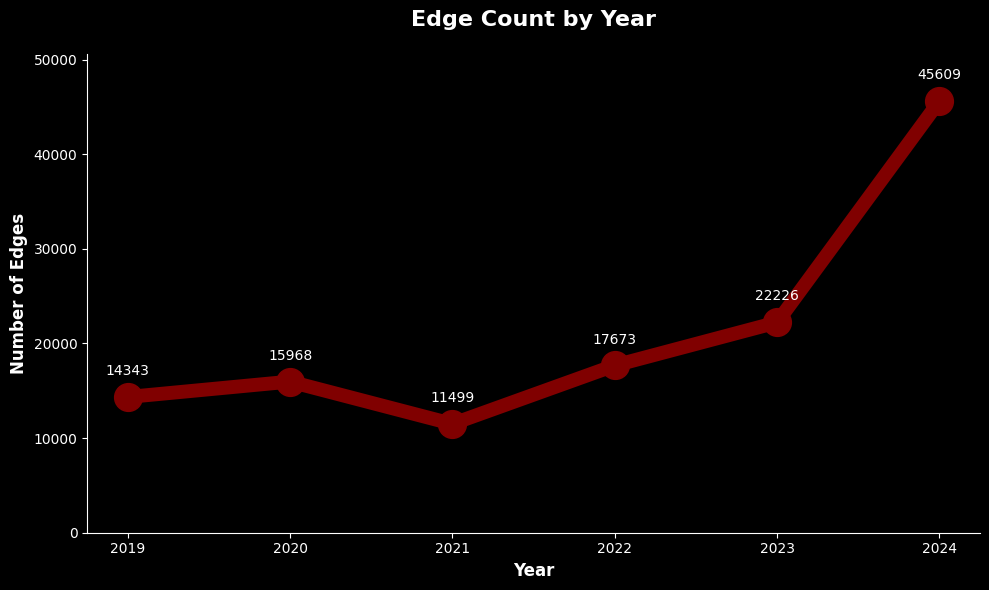

In [ ]:
import matplotlib.pyplot as plt

# Clear the current figure or close all previous plots
plt.clf()  # Alternatively, plt.close('all') can close all previous plots

# Set a style for the plot (dark background)
plt.style.use('dark_background')

# Group and sum the data once, then reuse it
grouped_data = temporal_network_df.groupby('year').agg({'value': 'sum'})

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data using matplotlib directly, not pandas
ax.plot(
    grouped_data.index,    # x-axis (years)
    grouped_data['value'], # y-axis (sum of values)
    marker='o',
    markersize=20,         # Increase marker size
    linewidth=10,          # Increase line width
    color='maroon',        # Set line color
    label='Edge Count'     # Add a label for potential future legend
)

# Customize the title and axis labels for better visibility
ax.set_title('Edge Count by Year', fontsize=16, weight='bold', pad=20)
ax.set_ylabel('Number of Edges', fontsize=12, weight='bold')
ax.set_xlabel('Year', fontsize=12, weight='bold')

# Add a y-axis range that starts at 0 for better context
ax.set_ylim(0, grouped_data['value'].max() + 5000)

# Add annotations for each point (showing the count of edges)
for x, y in zip(grouped_data.index, grouped_data['value']):
    ax.text(x, y + 2000, f'{y}', ha='center', va='bottom', fontsize=10, color='white')

# Remove the top and right spines to reduce clutter
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Disable the grid
ax.grid(False)

# Adjust layout for a cleaner look
plt.tight_layout()

# Show the plot
plt.show()


#### No. of nodes by year

year  no_of_nodes
0  2019         1403
1  2020         1759
2  2021         1650
3  2022         2106
4  2023         2772
5  2024         5284

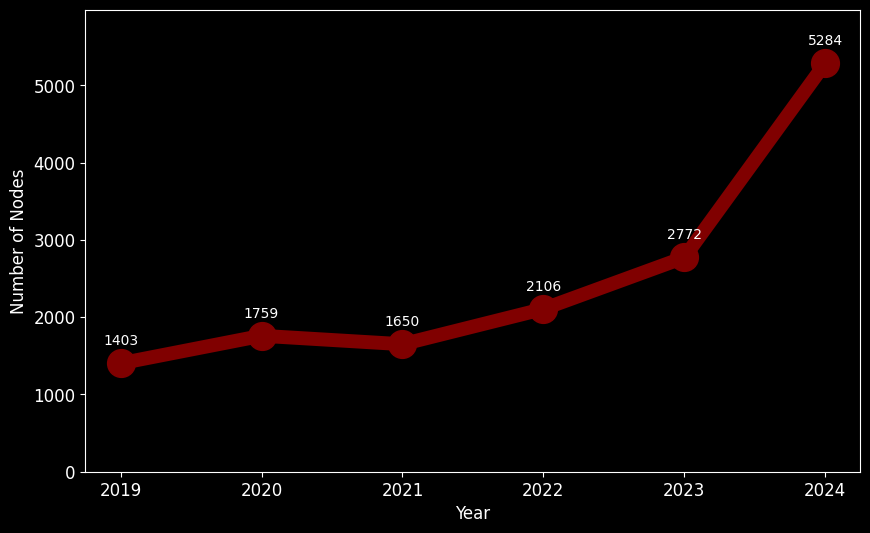

In [ ]:
df_nodes = temporal_network_df.copy()
node_dict = {}
for i, year in enumerate(years):
  #print('----------')
  #print(year)
  df = df_nodes[df_nodes['year'] == year]
  no_of_nodes = len(pd.concat([df['source'], df['target']]).unique())
  #print(no_of_nodes)
  node_dict[year] = no_of_nodes


df_plot_nodes = pd.DataFrame(list(node_dict.items()))
df_plot_nodes.columns = ['year', 'no_of_nodes']
display(df_plot_nodes)

plt.style.use('dark_background')  # Set the background to dark to make white text visible
df_plot_nodes.plot(
    x='year',  # Set 'year' as the x-axis
    y='no_of_nodes',  # Set 'no_of_nodes' as the y-axis
    kind='line',
    marker='o',
    color='maroon',  # Set the line color to maroon
    ylabel='Number of Nodes',
    xlabel='Year',
    markersize=20,  # Increase the marker size
    linewidth=10,  # Increase the line width
    #title='Node Count by Year',
    figsize=(10, 6),
    legend=False
)
# Add annotations for each point (showing the count of edges)
for x, y in df_plot_nodes.iterrows():
    plt.text(y['year'], y['no_of_nodes'] + 200, f"{y['no_of_nodes']}", ha='center', va='bottom', fontsize=10, color='white')  # Change color to white for visibility on dark background

plt.ylim(0, plt.ylim()[1] + 500)

plt.grid(visible=False)
# Customize the text color
plt.ylabel('Number of Nodes', color='white', fontsize=12)
plt.xlabel('Year', color='white', fontsize=12)
#plt.title('Node Count by Year', color='white')
plt.xticks(color='white', fontsize=12)
plt.yticks(color='white', fontsize=12)

plt.show()

In [ ]:
df_plot_nodes

year  no_of_nodes
0  2019         1403
1  2020         1759
2  2021         1650
3  2022         2106
4  2023         2772
5  2024         5284

#### Temporal Degree Centrality

In [ ]:
for year in years:
    df_year = temporal_network_df[temporal_network_df['year'] == year]
    G_year = nx.from_pandas_edgelist(df_year, source='source', target='target', create_using=nx.Graph())
    degree_centrality_year = nx.degree_centrality(G_year)
    print(f"Top 5 central nodes in {year}: {sorted(degree_centrality_year.items(), key=lambda x: x[1], reverse=True)[:5]}")

Top 5 central nodes in 2019: [('Trust', 0.2945791726105564), ('NHS', 0.06348074179743224), ('Board', 0.05206847360912981), ('The Hillingdon Hospitals NHS Foundation Trust', 0.03209700427960057), ('CQC', 0.026390870185449358)]
Top 5 central nodes in 2020: [('Williams', 0.07281001137656427), ('ESRC', 0.026734926052332193), ('Digital', 0.023321956769055744), ('EPSRC', 0.02218430034129693), ('NCSC', 0.015358361774744027)]
Top 5 central nodes in 2021: [('EPSRC', 0.023650697392359005), ('UKRI', 0.019405700424499697), ('EU', 0.01637355973317162), ('Digital', 0.01637355973317162), ('Innovation', 0.014554275318374773)]
Top 5 central nodes in 2022: [('NCSC', 0.022327790973871733), ('EU', 0.022327790973871733), ('Morello', 0.018052256532066508), ('SU Repository', 0.0166270783847981), ('SGN', 0.014726840855106888)]
Top 5 central nodes in 2023: [('EU', 0.02309635510645976), ('BT', 0.016239624684229518), ('AI', 0.013713460844460483), ('SGN', 0.012269938650306747), ('Lancaster University', 0.01154817

#### Degree Centrality of Specific Entity

In [ ]:
def degree_centrality_of_entity(df, entity):
  G_non_temporal_degree = nx.from_pandas_edgelist(non_temporal_network_df, source='source', target='target', create_using=nx.Graph())
  degree_centrality = nx.degree_centrality(G_non_temporal_degree)
  #print(f"Top 5 central nodes in {year}: {sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]}")
  print(f"Degree Centrality ({entity}): {degree_centrality[entity]:.5f}")
  return degree_centrality[entity]

degree_centrality_of_entity(non_temporal_network_df, 'Cyber Security')

Degree Centrality (Cyber Security): 0.00676


0.0067613252197430695

#### Yearly new edges

In [ ]:
# Finding new edges introduced each year
df_new_edges = temporal_network_df.copy()
df_new_edges['edge'] = temporal_network_df.apply(lambda row: (row['source'], row['target']), axis=1)

edges_by_year = df_new_edges.groupby('year')['edge'].apply(set)
for year in sorted(edges_by_year.index)[1:]:
  if year-1 in edges_by_year.index:
    new_edges = edges_by_year[year] - edges_by_year[year-1]
    print(f"New edges introduced in {year}: {len(new_edges)}")
  else:
    continue

New edges introduced in 2020: 2397
New edges introduced in 2021: 1901
New edges introduced in 2022: 2744
New edges introduced in 2023: 3496
New edges introduced in 2024: 7020


#### Top Common pairs of edges

In [ ]:
# Most common source-target pairs
common_pairs = non_temporal_network_df.copy()

common_pairs = common_pairs.head(100).reset_index().drop('index', axis=1)

common_pairs.head(100)

source  \
0                                          Department   
1                                              Google   
2                                               Board   
3                                                 CQC   
4                                          Commission   
5                                                 NHS   
6                                                FAME   
7                          UK Research and Innovation   
8                                                Levi   
9                                   Brooks Cunningham   
10                                Challenge Directors   
11                                         Innovation   
12                                            Society   
13                                              CHERI   
14                                               Rana   
15                                        StumbleUpon   
16                                              Skype   
17                                               Digg   
18                                               Digg   
19                                           Telegram   
20                                              Intel   
21  American Society of Criminology Annual Conference   
22                                        HM Treasury   
23                                              Sloan   
24                                              Apple   
25                                          Committee   
26                                              ENISA   
27      The Hillingdon Hospitals NHS Foundation Trust   
28                                 Cardiff University   
29                                            Codasip   
30                                         Department   
31                                                GFA   
32                                               KPMG   
33                                              CHERI   
34                                              CHERI   
35                                     Akshaya Asokan   
36                                               NHSI   
37                                      Shane DeGaris   
38                                               DASA   
39                                     Akshaya Asokan   
40                                               Wall   
41                                              CHERI   
42               Commonwealth and Development Affairs   
43                                              CHERI   
44                     British Journal of Criminology   
45                                                SGN   
46                                                EVP   
47                   Biological Physics Across Scales   
48                                               CISO   
49                                              Trust   
50                                     Project Report   
51                                              CHERI   
52                                               GCHQ   
53                                              CHERI   
54                                            Codasip   
55                                           Facebook   
56                                               Fund   
57                             Healthwatch Hillingdon   
58                                                EEC   
59                                              CHERI   
60                                           Alechina   
61                                                ICO   
62                                               NATO   
63                                               DHSC   
64                                          Childcare   
65                                              Javed   
66                                                EEA   
67                                          Microsoft   
68                                         Innovation   
69                                  Door Security LTD   


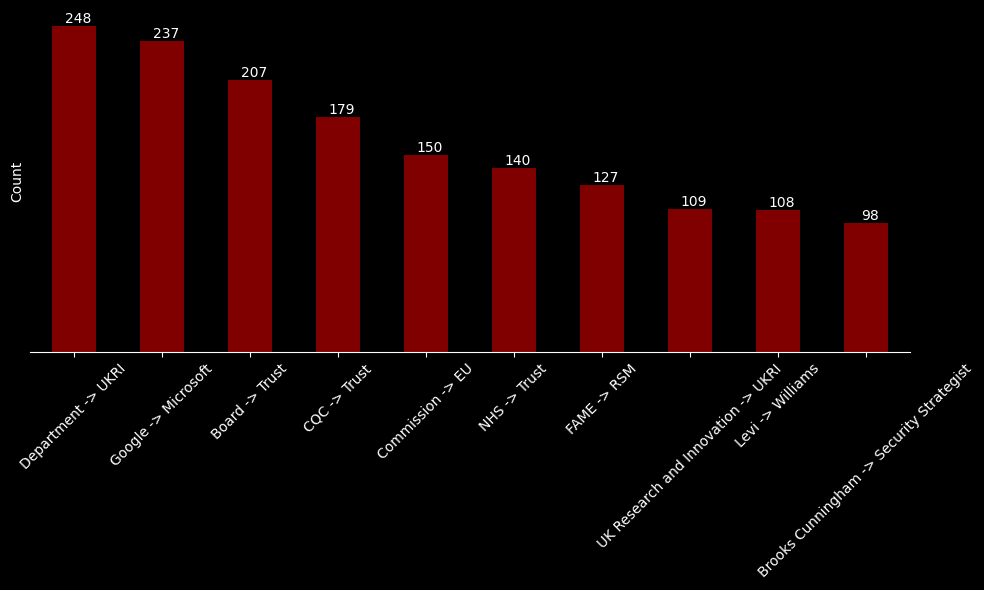

In [ ]:
# Most common source-target pairs
common_pairs = non_temporal_network_df.copy()

common_pairs = common_pairs.head(10).reset_index().drop('index', axis=1)

# Plot the bar chart
ax = common_pairs.plot(kind='bar', figsize=(10, 6), ylabel="Count", color='maroon')

# Add value labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.3, p.get_height()), ha='center', va='bottom')

# Rotate x-axis labels for better visibility
ax.set_xticklabels([f"{common_pairs['source'].iloc[index]} -> {common_pairs['target'].iloc[index]}" for index in common_pairs.index], rotation=45, ha='center')

# Remove x-axis and y-axis lines (spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)

# Optionally, remove the y-axis ticks if needed
ax.yaxis.set_ticks([])
ax.grid(axis='x', which='both', visible=False)  # This turns off the vertical grids only
ax.legend().remove()  # Remove the legend


# Display the plot
plt.tight_layout()
plt.show()


In [35]:
for node in G_non_temporal.nodes():
  if type(node) == float:
    print(f"Node: {node}, Type: {type(node)}")

In [ ]:
G_non_temporal

#### Greedy Modularity Communities - Non temporal network

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
communities = greedy_modularity_communities(G_non_temporal)
for i, community in enumerate(communities):
    print(f"Community {i+1}: {list(community)}")

Community 1: ['AI       Systems', 'Innovation Practice', 'Menu         Home Projects Services Blog About Jobs Contact DE Press', 'The University of Manchester                                                                 University home        Events                                                                     Home         Bicentenary', 'Compromising Microsoft Exchange', 'OSR', 'Disentangling AI Framework', 'Digital Innovation Security  Hub DiSH', 'University of Manchester  AI', 'First Derivatives', 'Siraj Shaikh', 'Digital World', 'Microsoft Exchange', 'Central Government', 'Digital Markets Regime', 'Discribe Hub', 'Abhaya Sumanasena', 'Smart Approaches to Consolidating', 'Safe and Secure Software Systems', 'Telecoms Infrastructure', 'Interactive Artificial Intelligence', 'Independent Monitoring Authority', 'UK Blockchain Influencer', 'De Mey', 'The Discribe Hub', 'Sociotechnical Cyber Security', 'Automotive  Historical', 'InitAll', 'Broadcom', 'Tim Silversides', 'Department 

In [ ]:
from networkx.algorithms.community import louvain_communities
communities = louvain_communities(G_non_temporal)
for i, community in enumerate(communities):
    print(f"Community {i+1}: {list(community)}")

Community 1: ['Wang', 'Shoshana Zuboff', 'Curran', 'Patterson', 'Folgate', 'Sebastian Schuon', 'Online Safety and Cyber Security']
Community 2: ['The Digital Security', 'AI       Systems', 'Innovation Practice', 'Menu         Home Projects Services Blog About Jobs Contact DE Press', 'Compromising Microsoft Exchange', 'Swansea University Wales Swansea University', 'East Suffolk Council Community Partnership Board', 'Siraj Shaikh', 'Digital World', 'Microsoft Exchange', 'Central Government', 'José Ignacio Torreblanca', 'Discribe Hub', 'Smart Approaches to Consolidating', 'Telecoms Infrastructure', 'Interactive Artificial Intelligence', 'De Mey', 'Safe Browsing', 'The Discribe Hub', 'Automotive  Historical', 'InitAll', 'Broadcom', 'Tim Silversides', 'Regions Sustainability Team Contact', 'Postgraduate Research Projects', 'Defence and Security Creative industries Energy and Utilities Government and Public sector Investors', 'SRI International', 'Syneto', 'Leda Blackwood', 'High  Software  

#### Top Common Nodes - Degrees

Node  Degree
0                                            Trust   426.0
1                                               AI   306.0
2                                               EU   236.0
3                                          Digital   148.0
4                                            CHERI   141.0
5                                              NHS   138.0
6                                             NCSC   133.0
7                                         Williams   128.0
8                                        Microsoft   124.0
9                                             UKRI   111.0
10                                         Morello   108.0
11                                           EPSRC   105.0
12                                Digital Security    91.0
13                                  Cyber Security    90.0
14                                          Google    89.0
15                                           Board    89.0
16                                             SME    80.0
17                                            DSbD    77.0
18                                      University    70.0
19                                              BT    65.0
20                                            ESRC    60.0
21                                            GCHQ    54.0
22                                Digital Catapult    53.0
23                            Lancaster University    51.0
24                                         Defence    49.0
25                                             SGN    48.0
26                               Startups Magazine    48.0
27                                            DCMS    46.0
28                                             RSM    45.0
29   The Hillingdon Hospitals NHS Foundation Trust    45.0
30                      UK Research and Innovation    44.0
31                                      Manchester    41.0
32                                           Ofcom    40.0
33                                   Cybersecurity    39.0
34                                        Facebook    38.0
35                                          Oxford    38.0
36                                         Quantum    38.0
37                                             CQC    37.0
38                         University of Cambridge    37.0
39                                   SU Repository    35.0
40                                      Commission    35.0
41                                            Bada    34.0
42                                       Instagram    34.0
43                                         Twitter    34.0
44                                     Innovate UK    34.0
45                                          Amazon    34.0
46                                         Codasip    33.0
47                                           Intel    33.0
48                                     HM Treasury    32.0
49                                             NCF    32.0
50                                      Department    31.0
51                      Digital Security by Design    31.0
52                                       Committee    30.0
53                                           Apple    29.0
54                                           Cisco    29.0
55                             European Commission    29.0
56                                             NCA    29.0
57                                   John Goodacre    29.0
58                                         FinTech    28.0
59                            University of Oxford    28.0
60                                            SMBs    28.0
61                                        Deloitte    28.0
62                                         Project    27.0
63                         Artificial Intelligence    27.0
64                                      Government    27.0
65                                           State    27.0
66                                        Security    27.0
67                                

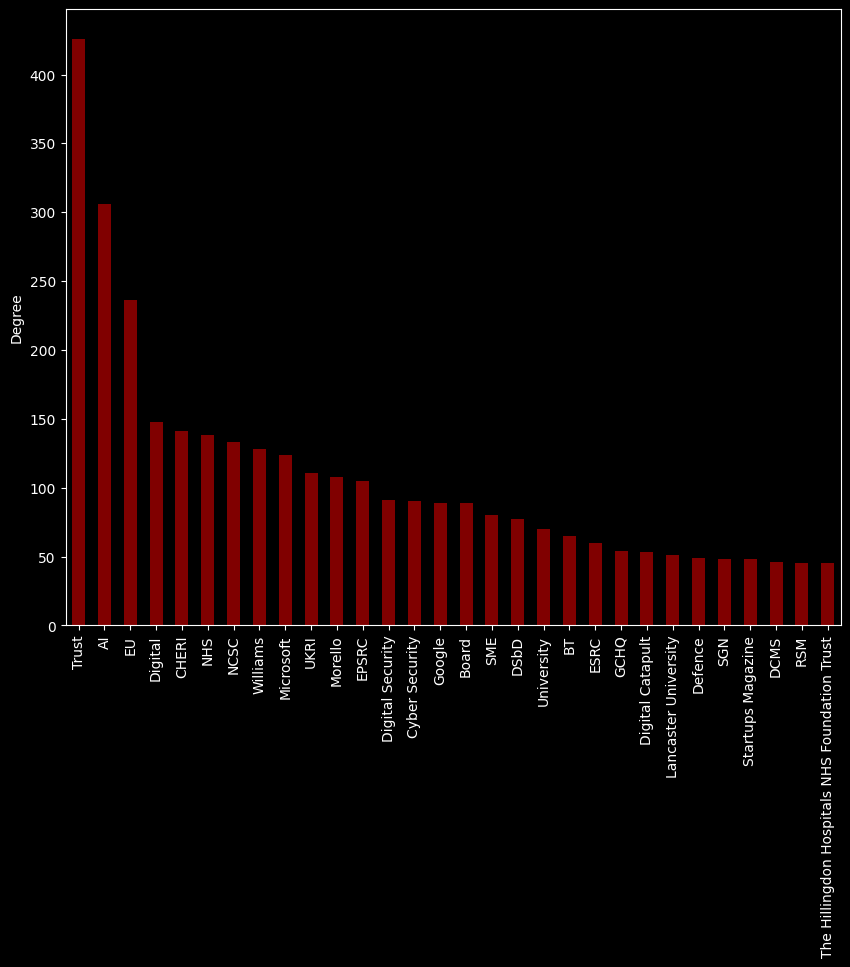

In [ ]:
df_most_degrees = largest_degree_nodes(non_temporal_network_df)
df_most_degrees.drop('index', axis=1, inplace=True)
df_most_degrees = df_most_degrees[(df_most_degrees['Node'] != 'Nielsen Book Services Ltd') & (df_most_degrees['Node'] != 'BIC')]
display(df_most_degrees.head(200))
# Sort by 'Degree' and plot the top 30 nodes
ax = df_most_degrees.sort_values(by='Degree', ascending=False).head(30).plot(
    kind='bar', x='Node', y='Degree', ylabel='Degree',
    figsize=(10, 8), color='maroon'
)

# Remove x-axis and y-axis lines (spines)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# Turn off the vertical grid lines
ax.grid(visible=False)

ax.legend().remove()  # Remove the legend

# Remove the xlabel
ax.set_xlabel('')

# Show the plot
plt.show()

In [ ]:
G_non_temporal_network = nx.from_pandas_edgelist(non_temporal_network_df, source='source', target='target', edge_attr='value', create_using=nx.Graph())
degree_centrality = nx.degree_centrality(G_non_temporal_network)
closeness_centrality = nx.closeness_centrality(G_non_temporal_network)
#betweenness_centrality = nx.betweenness_centrality(G_non_temporal_network, weight='value')
clustering_coefficient = nx.clustering(G_non_temporal_network)

metrics_df = pd.DataFrame({
        'Node': list(G_non_temporal_network.nodes()),
        'Degree Centrality': pd.Series(degree_centrality),
        'Closeness Centrality': pd.Series(closeness_centrality),
        #'Betweenness Centrality': pd.Series(betweenness_centrality),
        'Clustering Coefficient': pd.Series(clustering_coefficient)
}).set_index('Node')

metrics_df.head(20)

Degree Centrality  Closeness Centrality  \
Node                                                                  
Department                           0.002329              0.187376   
UKRI                                 0.008339              0.199718   
Google                               0.006686              0.199431   
Microsoft                            0.009316              0.198780   
Board                                0.006686              0.173124   
Trust                                0.032004              0.196223   
CQC                                  0.002780              0.172234   
Commission                           0.002629              0.173729   
EU                                   0.017730              0.206562   
NHS                                  0.010367              0.198985   
FAME                                 0.000676              0.171278   
RSM                                  0.003381              0.185276   
UK Research and Innovation           0.003306              0.186686   
Levi                                 0.001277              0.156081   
Williams                             0.009616              0.185299   
Brooks Cunningham                    0.000225              0.098171   
Security Strategist                  0.000526              0.109297   
Challenge Directors                  0.000225              0.165633   
Innovation                           0.001953              0.174797   
Society                              0.001277              0.179212   

                            Clustering Coefficient  
Node                                                
Department                                0.111828  
UKRI                                      0.030303  
Google                                    0.015832  
Microsoft                                 0.011277  
Board                                     0.022472  
Trust                                     0.003866  
CQC                                       0.073574  
Commission                                0.043697  
EU                                        0.003642  
NHS                                       0.012377  
FAME                                      0.277778  
RSM                                       0.036364  
UK Research and Innovation                0.065539  
Levi                                      0.102941  
Williams                                  0.013410  
Brooks Cunningham                         0.333333  
Security Strategist                       0.142857  
Challenge Directors                       0.333333  
Innovation                                0.098462  
Society                                   0.044118

#### Closeness Centrality

In [ ]:
metrics_df.sort_values(by='Closeness Centrality', ascending=False).head(300)['Closeness Centrality']

Node
AI                                                                            0.214888
EU                                                                            0.206562
Digital                                                                       0.204980
Cyber Security                                                                0.202050
CHERI                                                                         0.199798
UKRI                                                                          0.199718
Google                                                                        0.199431
EPSRC                                                                         0.199152
NHS                                                                           0.198985
Microsoft                                                                     0.198780
University                                                                    0.197855
NCSC                                                                          0.197798
SME                                                                           0.197482
Digital Catapult                                                              0.197152
Morello                                                                       0.197001
Trust                                                                         0.196223
Amazon                                                                        0.194645
Digital Security                                                              0.193803
DCMS                                                                          0.193785
DSbD                                                                          0.192692
Lancaster University                                                          0.192129
Facebook                                                                      0.191111
Quantum                                                                       0.190689
Industrial Strategy                                                           0.189905
Apple                                                                         0.189899
Cybersecurity                                                                 0.189118
BT                                                                            0.189022
CMA                                                                           0.188406
ESRC                                                                          0.187763
Deloitte                                                                      0.187643
Department                                                                    0.187376
Data                                                                          0.187367
Rust                                                                          0.187226
Twitter                                                                       0.186810
UK Research and Innovation                                                    0.186686
Software                                                                      0.186242
KPMG                                                                          0.186082
ChatGPT                                                                       0.186032
Airbus                                                                        0.186012
Telecoms                                                                      0.185552
SGN                                                                           0.185318
IBM                                                                           0.185301
Williams                                                                      0.185299
RSM                                                                           0.185276
State                                                                         0.185019
UK Research                                                                   0.

In [ ]:
df_most_degrees = largest_degree_nodes(df_final)
df_most_degrees.drop('index', axis=1, inplace=True)
df_most_degrees = df_most_degrees[(df_most_degrees['Node'] != 'Nielsen Book Services Ltd') & (df_most_degrees['Node'] != 'BIC')]
display(df_most_degrees.head(1000))

Node  Degree
0                                                Trust  4126.0
1                                             Williams  2264.0
2                                                   EU  2041.0
3                                                   AI  1823.0
4                                                 UKRI  1635.0
5                                                CHERI  1526.0
6                                            Microsoft  1359.0
7                                                 NCSC  1075.0
8                                              Morello  1073.0
9                                                  NHS  1040.0
10                                              Google   972.0
11                                             Digital   916.0
12                                               EPSRC   803.0
13                                               Board   726.0
14                                    Digital Security   621.0
15                                      Cyber Security   586.0
16                                                DSbD   576.0
17                                          Department   559.0
18                                             Codasip   553.0
19                                                  BT   542.0
20                          UK Research and Innovation   491.0
21                                    Digital Catapult   491.0
22                                                 RSM   475.0
23                                             Defence   466.0
24                                                 CQC   461.0
25                                                 SME   461.0
26                                                ESRC   460.0
27                                                GCHQ   447.0
28                                          University   447.0
29                                       SU Repository   430.0
30                                                 SGN   425.0
31                                               Intel   392.0
32                                          Commission   385.0
33       The Hillingdon Hospitals NHS Foundation Trust   371.0
34                                                 NCA   366.0
35                                                DCMS   356.0
36                                         HM Treasury   353.0
37                                               Ofcom   336.0
38                                Lancaster University   327.0
39                                University of Oxford   316.0
40                                              Oxford   314.0
41                                             Twitter   307.0
42                                            Facebook   296.0
43                                             Samsung   286.0
44                             University of Cambridge   285.0
45                                               Apple   281.0
46                                                 NCF   272.0
47                                          Innovation   272.0
48                                               Sloan   264.0
49                                              Amazon   260.0
50                                   Startups Magazine   259.0
51                                         Innovate UK   259.0
52                                             Quantum   258.0
53                                          Manchester   242.0
54                                           Committee   239.0
55                                  Cardiff University   239.0
56                                                Levi   236.0
57                                            Telegram   233.0
58                                                DASA   229.0
59                                               State   227.0
60                                                  NI   227.0
61                                            Deloitte   221.0
62                                                Bada   218.0
63                

In [ ]:
#getting degrees for entity with all edges where entity is a source in the edge
source_df = temporal_network_df[((temporal_network_df['year']) == year) & ((temporal_network_df['source']) == 'CHERI')] \
          .sort_values(by='value').groupby(['year', 'source']).agg({'value': 'sum'}).reset_index()
#getting degrees for entity with all edges where entity is a target in the edge
target_df = temporal_network_df[((temporal_network_df['year']) == year) & ((temporal_network_df['target']) == 'CHERI')] \
          .sort_values(by='value').groupby(['year', 'target']).agg({'value': 'sum'}).reset_index()

#changing column names for both from source/target --> entity
source_df.columns = ['year', 'entity', 'value']
target_df.columns = ['year', 'entity', 'value']
#getting single dataframe for that year
df = pd.concat([source_df, target_df], ignore_index=True).groupby(['year', 'entity']).agg({'value': 'sum'}).reset_index()

#### Entity-Wise Temporal Degree Analysis

year entity value
0  2019    NHS   688
1  2020    NHS    29
2  2021    NHS    33
3  2022    NHS    44
4  2023    NHS    18
5  2024    NHS   202

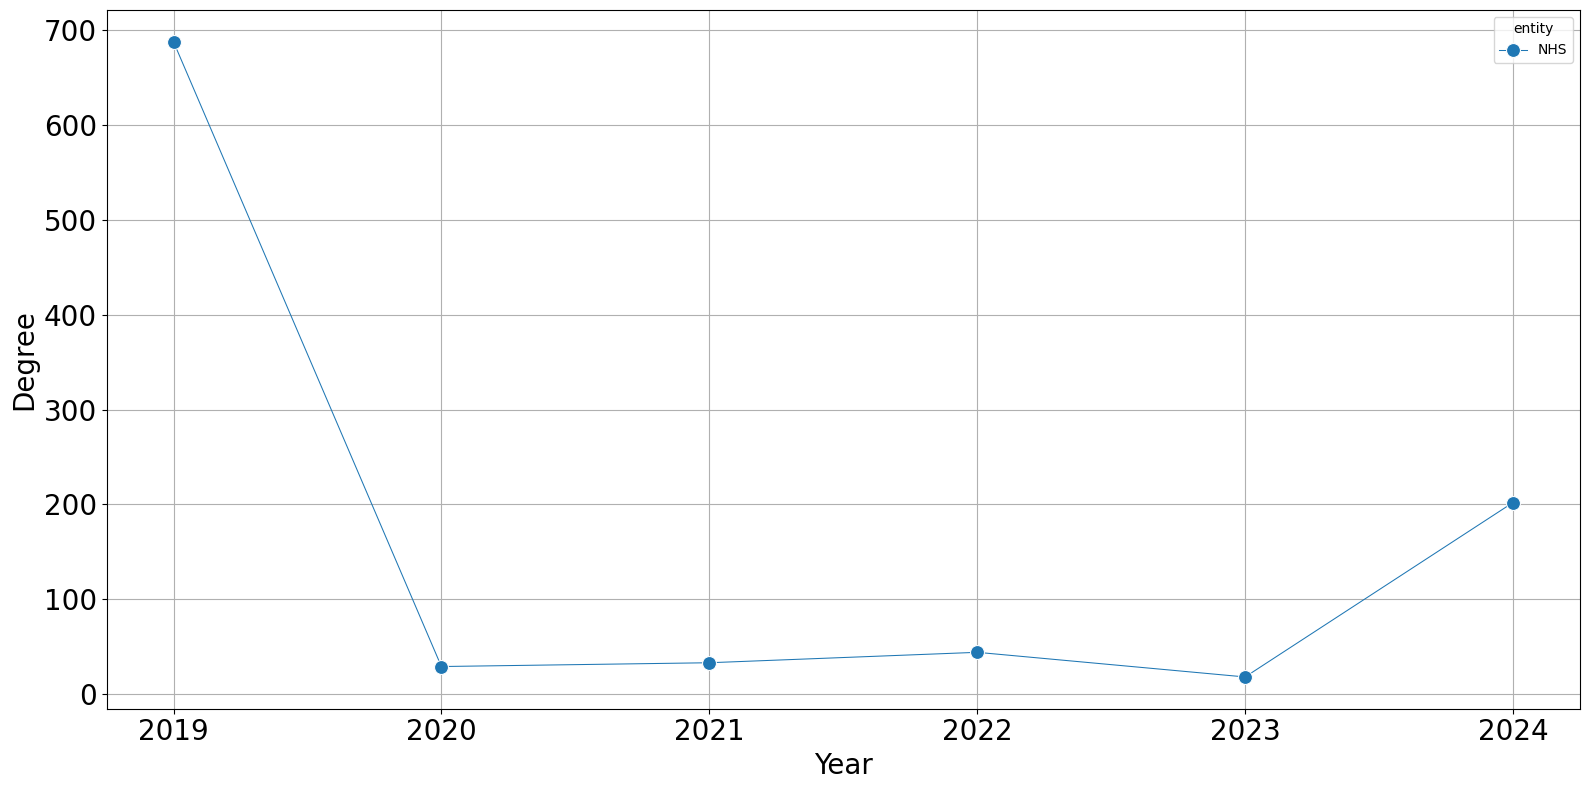

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
#entity_list = ['CHERI', 'Morello', 'AI', 'UKRI', 'DSbD', 'RSM', 'EU', 'ESRC', 'NHS', 'EPSRC', 'NCSC']
entity_list = ['NHS', 'Board', 'CQC', 'ESRC', 'EPSRC', 'AI', 'EU', 'UKRI', 'Morello', 'SGN', 'CHERI', 'Codasip', 'arm', 'Thales', 'Discribe']
node_trend_df = pd.DataFrame(columns=['year', 'entity', 'value'])
for entity in ['NHS']:
  for year in years:
    #getting degrees for entity with all edges where entity is a source in the edge
    source_df = temporal_network_df[((temporal_network_df['year']) == year) & ((temporal_network_df['source']) == entity)] \
              .sort_values(by='value').groupby(['year', 'source']).agg({'value': 'sum'}).reset_index()
    #getting degrees for entity with all edges where entity is a target in the edge
    target_df = temporal_network_df[((temporal_network_df['year']) == year) & ((temporal_network_df['target']) == entity)] \
              .sort_values(by='value').groupby(['year', 'target']).agg({'value': 'sum'}).reset_index()

    #changing column names for both from source/target --> entity
    source_df.columns = ['year', 'entity', 'value']
    target_df.columns = ['year', 'entity', 'value']
    #getting single dataframe for that year
    df = pd.concat([source_df, target_df], ignore_index=True).groupby(['year', 'entity']).agg({'value': 'sum'}).reset_index()

    if len(df) > 0:
      #print(True)
      #display(df)
      node_trend_df = pd.concat([node_trend_df, df], ignore_index=True)
    else:
      df = pd.DataFrame(columns=['year', 'entity', 'value'])
      df.loc[0] = [year, entity, 0]
      #display(df)
      node_trend_df = pd.concat([node_trend_df, df], ignore_index=True)

display(node_trend_df)
# Plot using seaborn with node as the legend and degree against years
plt.figure(figsize=(16, 8))
sns.lineplot(data=node_trend_df, x='year', y='value', hue='entity', marker='o', legend='full', size='entity', linewidth=30, markersize=10)
# Adding aesthetic details
#plt.title('Degree Over The Years by Entity', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Degree', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#entity_list = ['CHERI', 'Morello', 'AI', 'UKRI', 'DSbD', 'RSM', 'EU', 'ESRC', 'NHS', 'EPSRC', 'NCSC']
entity_list = ['NHS', 'Board', 'CQC', 'ESRC', 'EPSRC', 'AI', 'EU', 'UKRI', 'Morello', 'SGN', 'CHERI', 'Codasip', 'arm', 'Thales', 'Discribe']
node_trend_df = pd.DataFrame(columns=['year', 'source', 'target', 'value'])
for entity in ['NHS']:
  for year in years:
    #getting degrees for entity with all edges where entity is a source in the edge
    df = temporal_network_df[((temporal_network_df['year']) == year) & (((temporal_network_df['source']) == entity) | ((temporal_network_df['target']) == entity))] \
              .sort_values(by='value').groupby(['year', 'source', 'target']).agg({'value': 'sum'}).reset_index()


    if len(df) > 0:
      #print(True)
      #display(df)
      node_trend_df = pd.concat([node_trend_df, df], ignore_index=True)
    else:
      df = pd.DataFrame(columns=['year', 'source', 'target', 'value'])
      df.loc[0] = [year, entity, np.nan, 0]
      #display(df)
      node_trend_df = pd.concat([node_trend_df, df], ignore_index=True).sort_values(by=['year', 'value'], ascending=[False, True])

display(node_trend_df)

year                                             source  \
0    2019                                Advice and Guidance   
1    2019                          Assurance Standards Board   
2    2019                           Audit and Risk Committee   
3    2019                                            Beddays   
4    2019  Better  Payment Practice Code The Non NHS Trad...   
5    2019                                   Better Care Fund   
6    2019                                              Board   
7    2019                           Business Continuity Team   
8    2019                                                CQC   
9    2019                                              CQUIN   
10   2019                           Central Alerting  System   
11   2019                      Clinical Commissioning Groups   
12   2019                                          Committee   
13   2019                                               DHSC   
14   2019                                       Deloitte LLP   
15   2019                                            Digital   
16   2019                                      EMIS EMIS Web   
17   2019                                          Education   
18   2019                   EoLC Resources Improvement Group   
19   2019                                                FFT   
20   2019                                               FReM   
21   2019                                             Foster   
22   2019          Foundation Trust FT NHS Foundation Trusts   
23   2019                                     Francis Report   
24   2019                                                 GP   
25   2019                      General Medical Practice Code   
26   2019                               Governance The Trust   
27   2019                              HEALTHCARE  NHS TRUST   
28   2019                                        HM Treasury   
29   2019                                          Health DH   
30   2019                                         Healthcare   
31   2019                                  Healthier  Future   
32   2019                             Healthwatch Hillingdon   
33   2019                             Hillingdon Care Record   
34   2019                  Hospital  Standardised  Mortality   
35   2019             IMPERIAL  COLLEGE HEALTHCARE NHS TRUST   
36   2019                               Improvement Strategy   
37   2019                            International Financial   
38   2019        International Financial Reporting Standards   
39   2019                                 Inventory Movement   
40   2019                                         Jacqueline   
41   2019                                       John Gerrard   
42   2019                                               LIFT   
43   2019                                  Local Authorities   
44   2019                                      London Trusts   
45   2019                                                MDT   
46   2019                                     Model Hospital   
47   2019                                   NCEPOD  Children   
48   2019                                                NHS   
49   2019                                                NHS   
50   2019                                                NHS   
51   2019                                                NHS   
52   2019                                                NHS   
53   2019                                                NHS   
54   2019                                                NHS   
55   2019                                                NHS   
56   2019                                                NHS   
57   2019                                                NHS   
58   2019                                                NHS   
59   2019                                                NHS   
60   2019                                                NHS   
61   2019                            

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#entity_list = ['CHERI', 'Morello', 'AI', 'UKRI', 'DSbD', 'RSM', 'EU', 'ESRC', 'NHS', 'EPSRC', 'NCSC']
entity_list = ['NHS', 'Board', 'CQC', 'ESRC', 'EPSRC', 'AI', 'EU', 'UKRI', 'Morello', 'SGN', 'CHERI', 'Codasip', 'arm', 'Thales', 'Discribe']
node_trend_df = pd.DataFrame(columns=['entity', 'value'])
for entity in ['Digital Security']:
  #getting degrees for entity with all edges where entity is a source in the edge
  source_df = non_temporal_network_df[((non_temporal_network_df['source']) == entity)] \
            .sort_values(by='value').groupby(['source']).agg({'value': 'sum'}).reset_index()
  #getting degrees for entity with all edges where entity is a target in the edge
  target_df = non_temporal_network_df[((non_temporal_network_df['target']) == entity)] \
            .sort_values(by='value').groupby(['target']).agg({'value': 'sum'}).reset_index()
  #changing column names for both from source/target --> entity
  source_df.columns = ['entity', 'value']
  target_df.columns = ['entity', 'value']
  #getting single dataframe for that year
  df = pd.concat([source_df, target_df], ignore_index=True).groupby(['entity']).agg({'value': 'sum'}).reset_index()
  if len(df) > 0:
    #print(True)
    #display(df)
    node_trend_df = pd.concat([node_trend_df, df], ignore_index=True)
  else:
    df = pd.DataFrame(columns=['entity', 'value'])
    df.loc[0] = [entity, 0]
    #display(df)
    node_trend_df = pd.concat([node_trend_df, df], ignore_index=True)

display(node_trend_df)
# Plot using seaborn with node as the legend and degree against years
#plt.figure(figsize=(20, 12))
#sns.lineplot(data=node_trend_df, x='year', y='value', hue='entity', marker='o', legend='full', size='entity', linewidth=30, markersize=10)
## Adding aesthetic details
##plt.title('Degree Over The Years by Entity', fontsize=20)
#plt.xlabel('Year', fontsize=20)
#plt.ylabel('Degree', fontsize=20)
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
#plt.grid(True)
#plt.tight_layout()
#
## Display the plot
#plt.show()

entity value
0  Digital Security   621

In [ ]:
df_degree_centrality = pd.DataFrame(columns=['year', 'Node', 'Degree'])
for year in years:
  print('-------------------')
  print(f"Working on year: {year}")
  df = temporal_network_df[temporal_network_df['year'] == year]
  source_counts = df[df['source'] == 'CHERI']['value']
  #print(source_counts)
  target_counts = df[df['target'] == 'CHERI']['source'].value_counts()
  #print(target_counts)

  # Combine the counts for source and target to get the total degree
  degree_series = source_counts.add(target_counts, fill_value=0)

  degree_df = degree_series.reset_index()
  degree_df.columns = ['Node', 'Degree']
  #degree_df = degree_df.sort_values(by='Degree', ascending=False).reset_index()
  #display(degree_df)
  degree_df['year'] = year
  df_degree_centrality = pd.concat([df_degree_centrality, degree_df], ignore_index=True)

df_degree_centrality.sort_values(by=['year', 'Degree'], ascending=[True, False], inplace=True)
df_degree_centrality.reset_index(inplace=True)
df_degree_centrality.drop('index', axis=1, inplace=True)
display(df_degree_centrality)

-------------------
Working on year: 2019
-------------------
Working on year: 2020
-------------------
Working on year: 2021
-------------------
Working on year: 2022
-------------------
Working on year: 2023
-------------------
Working on year: 2024


<ipython-input-46-1475d61dcb97>:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_degree_centrality = pd.concat([df_degree_centrality, degree_df], ignore_index=True)


year                                               Node  Degree
0    2019                                                252    12.0
1    2019                                                253    12.0
2    2019                                                263    10.0
3    2019                                               2476     6.0
4    2019                                                262     5.0
5    2019                                               2475     3.0
6    2019                                                269     2.0
7    2022                                               3802    11.0
8    2022                                                424     6.0
9    2022                                                425     6.0
10   2022                                              11611     6.0
11   2022                                              11610     4.0
12   2022                                               3801     2.0
13   2022                                               3823     2.0
14   2023                                                190    12.0
15   2023                                              12047     6.0
16   2023                                              12048     6.0
17   2023                                                139     5.0
18   2023                                                140     5.0
19   2023                                                158     5.0
20   2024                                               3503    92.0
21   2024                                               3134    62.0
22   2024                                               1268    58.0
23   2024                                              11114    52.0
24   2024                                               3250    51.0
25   2024                                               3077    46.0
26   2024                                               3293    45.0
27   2024                                               3139    44.0
28   2024                                              11104    37.0
29   2024                                              11163    35.0
30   2024                                              11151    30.0
31   2024                                               3316    26.0
32   2024                                              11150    24.0
33   2024                                              11216    21.0
34   2024                                               3320    18.0
35   2024                                              11103    18.0
36   2024                                               3338    17.0
37   2024                                               3529    17.0
38   2024                                              11149    17.0
39   2024                                              11190    16.0
40   2024                                               3259    15.0
41   2024                                               3292    12.0
42   2024                                              11263    12.0
43   2024                                                524    11.0
44   2024                                              11105    11.0
45   2024                                              11188    11.0
46   2024                                              11200    11.0
47   2024                                              11110    10.0
48   2024                                              11160    10.0
49   2024                                              11213    10.0
50   2024                                               3172     9.0
51   2024                                               3314     9.0
52   2024                                               3528     9.0
53   2024                                              11122     9.0
54   2024                                              11128     9.0
55   2024                                              11269     9.0
56   2024                                              11206     8.0
57 

Node  Degree
0      Trust  4126.0
1   Williams  2264.0
2         EU  2041.0
3         AI  1823.0
4       UKRI  1635.0
5      CHERI  1526.0
6  Microsoft  1359.0
7       NCSC  1075.0
8    Morello  1073.0
9        NHS  1040.0

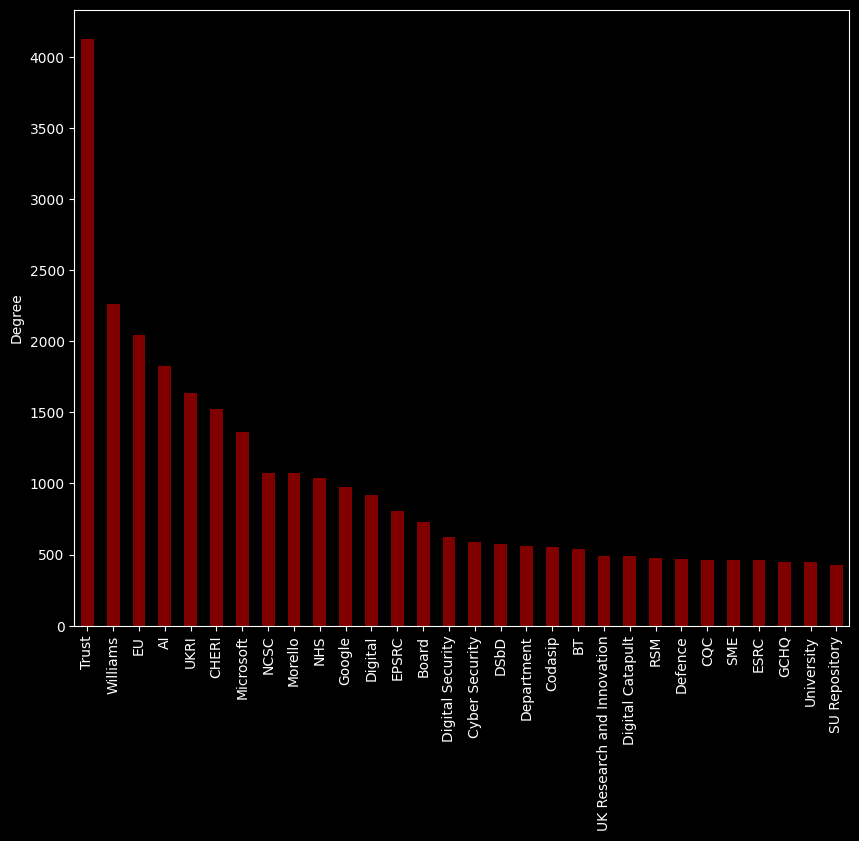

In [ ]:
df_most_degrees = largest_degree_nodes(df_final)
df_most_degrees.drop('index', axis=1, inplace=True)
df_most_degrees = df_most_degrees[(df_most_degrees['Node'] != 'Nielsen Book Services Ltd') & (df_most_degrees['Node'] != 'BIC')]
display(df_most_degrees.head(10))
# Sort by 'Degree' and plot the top 30 nodes
ax = df_most_degrees.sort_values(by='Degree', ascending=False).head(30).plot(
    kind='bar', x='Node', y='Degree', ylabel='Degree',
    figsize=(10, 8), color='maroon'
)

# Remove x-axis and y-axis lines (spines)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# Turn off the vertical grid lines
ax.grid(visible=False)

ax.legend().remove()  # Remove the legend

# Remove the xlabel
ax.set_xlabel('')

# Show the plot
plt.show()

In [ ]:
df_results[df_results['searched_keyword'].isin(['"dsbd"', '"digital security by design"'])]['site_domain'].value_counts()

site_domain
.uk    125
.eu     10
Name: count, dtype: int64

In [ ]:
df_results[df_results['searched_keyword'].isin(['dsbd', 'digital security by design'])]

Empty DataFrame
Columns: [searched_keyword, site_domain, result_title, result_date, result_url, result_text, result_year, result_month, result_day]
Index: []

#### Temporal Analysis

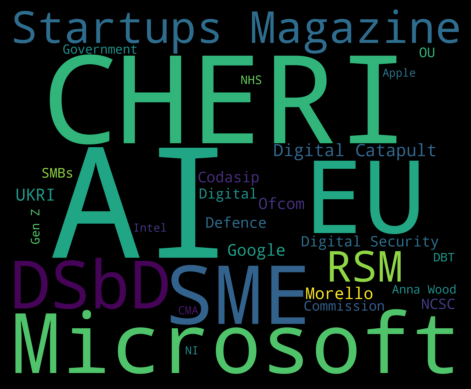

In [ ]:
df_wordcloud = degree_df.drop('index', axis=1)
d = dict(zip(df['Node'], df['Degree']))
wordcloud = WordCloud(width=2200,height=1800, max_words=30,normalize_plurals=False, background_color='black').generate_from_frequencies(d)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Trend for Year: 2020-2024
Number of edges: 17862
Number of nodes: 12088
Top 5 keywords


index       Node  Degree
0     49         AI   310.0
1   3464         EU   241.0
2   2991    Digital   147.0
3   1516      CHERI   145.0
4   7326       NCSC   143.0
5   7077  Microsoft   134.0
6  11860   Williams   128.0
7  11195       UKRI   121.0
8   7224    Morello   118.0
9   3419      EPSRC   110.0

	index	Node	Degree
0	49	AI	310.0
1	3464	EU	241.0
2	2991	Digital	147.0
3	1516	CHERI	145.0
4	7326	NCSC	143.0
5	7077	Microsoft	134.0
6	11860	Williams	128.0
7	11195	UKRI	121.0
8	7224	Morello	118.0
9	3419	EPSRC	110.0



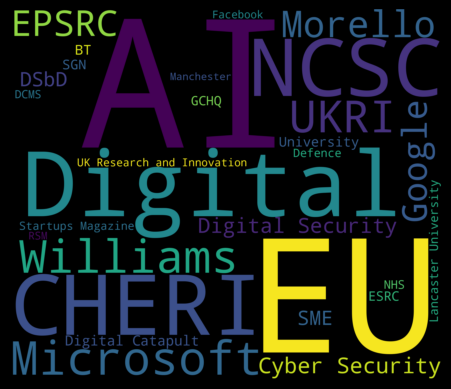

---------------------------------------
Trend for Year: 2019
Number of edges: 2237
Number of nodes: 1403
Top 5 keywords


index                                           Node  Degree
0   1335                                          Trust   413.0
1    830                                            NHS    89.0
2     97                                          Board    73.0
3   1284  The Hillingdon Hospitals NHS Foundation Trust    45.0
4    157                                            CQC    37.0
5    241                                      Committee    28.0
6    835                          NHS  Foundation Trust    25.0
7    473                                             GP    22.0
8    570                            Hillingdon Hospital    21.0
9    546                                    Healthwatch    20.0

	index	Node	Degree
0	1335	Trust	413.0
1	830	NHS	89.0
2	97	Board	73.0
3	1284	The Hillingdon Hospitals NHS Foundation Trust	45.0
4	157	CQC	37.0
5	241	Committee	28.0
6	835	NHS  Foundation Trust	25.0
7	473	GP	22.0
8	570	Hillingdon Hospital	21.0
9	546	Healthwatch	20.0



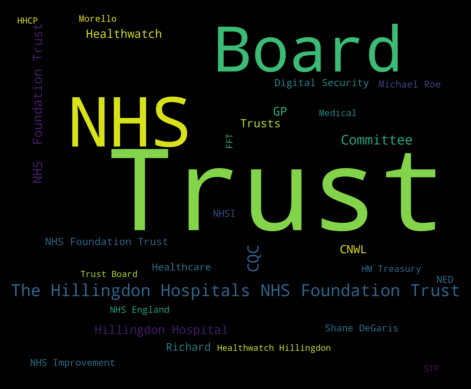

---------------------------------------
Trend for Year: 2020
Number of edges: 2408
Number of nodes: 1759
Top 5 keywords


index                Node  Degree
0   1724            Williams   128.0
1    513                ESRC    47.0
2    458             Digital    41.0
3    506               EPSRC    39.0
4   1035                NCSC    27.0
5    347      Cyber Security    25.0
6    231  Cardiff University    24.0
7    648              Google    23.0
8   1644          University    23.0
9     11                  AI    21.0

	index	Node	Degree
0	1724	Williams	128.0
1	513	ESRC	47.0
2	458	Digital	41.0
3	506	EPSRC	39.0
4	1035	NCSC	27.0
5	347	Cyber Security	25.0
6	231	Cardiff University	24.0
7	648	Google	23.0
8	1644	University	23.0
9	11	AI	21.0



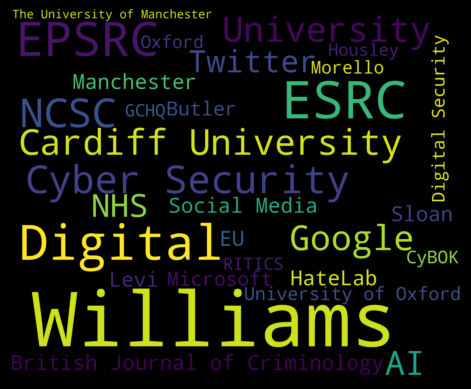

---------------------------------------
Trend for Year: 2021
Number of edges: 1916
Number of nodes: 1650
Top 5 keywords


index                 Node  Degree
0    449                EPSRC    39.0
1   1502                 UKRI    32.0
2    400              Digital    27.0
3    455                   EU    27.0
4    766           Innovation    24.0
5   1330            Shujun Li    22.0
6   1008                 NCSC    22.0
7    383           Department    20.0
8    521  European Commission    19.0
9     30       Abusaleh Jabir    17.0

	index	Node	Degree
0	449	EPSRC	39.0
1	1502	UKRI	32.0
2	400	Digital	27.0
3	455	EU	27.0
4	766	Innovation	24.0
5	1330	Shujun Li	22.0
6	1008	NCSC	22.0
7	383	Department	20.0
8	521	European Commission	19.0
9	30	Abusaleh Jabir	17.0



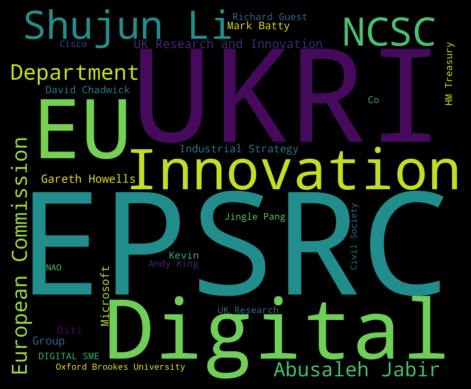

---------------------------------------
Trend for Year: 2022
Number of edges: 2763
Number of nodes: 2106
Top 5 keywords


index            Node  Degree
0    633              EU    47.0
1   1283            NCSC    47.0
2   1260         Morello    38.0
3   1660   SU Repository    35.0
4   1639             SGN    31.0
5    153            Bada    31.0
6   1279             NCA    24.0
7    419  Cyber Security    24.0
8      7              AI    24.0
9    809          Google    23.0

	index	Node	Degree
0	633	EU	47.0
1	1283	NCSC	47.0
2	1260	Morello	38.0
3	1660	SU Repository	35.0
4	1639	SGN	31.0
5	153	Bada	31.0
6	1279	NCA	24.0
7	419	Cyber Security	24.0
8	7	AI	24.0
9	809	Google	23.0



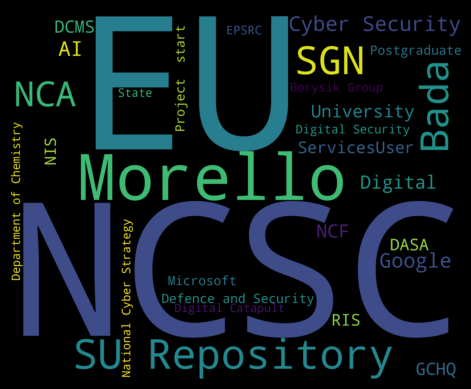

---------------------------------------
Trend for Year: 2023
Number of edges: 3576
Number of nodes: 2772
Top 5 keywords


index                  Node  Degree
0    815                    EU    64.0
1    208                    BT    45.0
2      9                    AI    38.0
3   2131                   SGN    34.0
4   1444  Lancaster University    32.0
5    674               Digital    31.0
6   1660             Microsoft    29.0
7    705      Digital Security    28.0
8   2583                  UKRI    27.0
9    546        Cyber Security    26.0

	index	Node	Degree
0	815	EU	64.0
1	208	BT	45.0
2	9	AI	38.0
3	2131	SGN	34.0
4	1444	Lancaster University	32.0
5	674	Digital	31.0
6	1660	Microsoft	29.0
7	705	Digital Security	28.0
8	2583	UKRI	27.0
9	546	Cyber Security	26.0



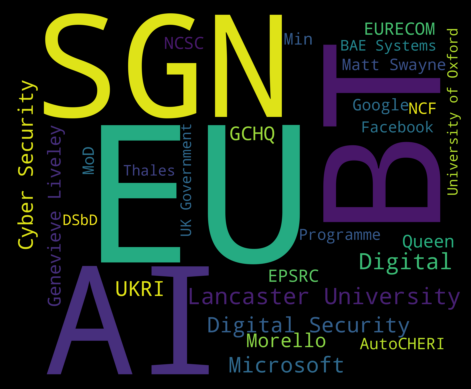

---------------------------------------
Trend for Year: 2024
Number of edges: 7199
Number of nodes: 5284
Top 5 keywords


index               Node  Degree
0     19                 AI   223.0
1    709              CHERI   132.0
2   1496                 EU    86.0
3   3078          Microsoft    62.0
4   3988                SME    59.0
5   1159               DSbD    54.0
6   4340  Startups Magazine    48.0
7   3778                RSM    45.0
8   1304   Digital Catapult    44.0
9   4868               UKRI    42.0

	index	Node	Degree
0	19	AI	223.0
1	709	CHERI	132.0
2	1496	EU	86.0
3	3078	Microsoft	62.0
4	3988	SME	59.0
5	1159	DSbD	54.0
6	4340	Startups Magazine	48.0
7	3778	RSM	45.0
8	1304	Digital Catapult	44.0
9	4868	UKRI	42.0



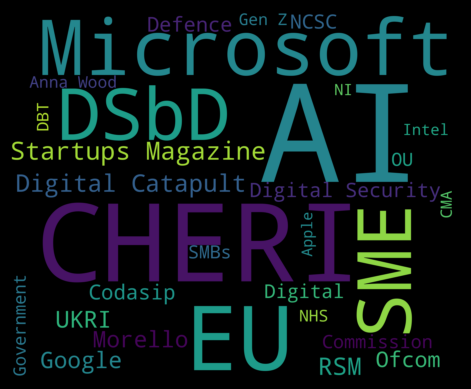

---------------------------------------


In [ ]:
import csv
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df = temporal_network_df[temporal_network_df['year']>2019]
min_year = df['year'].min()
max_year = df['year'].max()
print(f'Trend for Year: {min_year}-{max_year}')
print(f'Number of edges: {len(df)}')
no_of_nodes = len(pd.concat([df['source'], df['target']]).unique())
print(f'Number of nodes: {no_of_nodes}')
print('Top 5 keywords')
degree_df = largest_degree_nodes(df)
display(degree_df.head(10))
degree_df.head(10).to_csv("test.csv", sep="\t")
with open("test.csv", 'r') as f:
  data = f.read()

#printable_df = pd.read_csv("test.csv", sep="\t", index_col=False)
#printable_df.drop(['Unnamed: 0', 'index'], axis=1, inplace=True)
#print(printable_df)
print(data)

df_wordcloud = degree_df.drop('index', axis=1)
d = dict(zip(df_wordcloud['Node'], df_wordcloud['Degree']))
wordcloud = WordCloud(width=2100,height=1800, max_words=30,normalize_plurals=False, background_color='black').generate_from_frequencies(d)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
print('---------------------------------------')

for year in years[-6:]:#[2016, 2019, 2020, 2021, 2022, 2023, 2024]:
  print(f'Trend for Year: {year}')
  df = temporal_network_df[temporal_network_df['year'] == year]
  print(f'Number of edges: {len(df)}')
  no_of_nodes = len(pd.concat([df['source'], df['target']]).unique())

  print(f'Number of nodes: {no_of_nodes}')
  print('Top 5 keywords')
  degree_df = largest_degree_nodes(df)
  display(degree_df.head(10))
  degree_df.head(10).to_csv("test.csv", sep="\t")
  with open("test.csv", 'r') as f:
    data = f.read()
  print(data)
  #line_plot(degree_df.head(5).reset_index())

  df_wordcloud = degree_df.drop('index', axis=1)
  d = dict(zip(df_wordcloud['Node'], df_wordcloud['Degree']))
  wordcloud = WordCloud(width=2200,height=1800, max_words=30,normalize_plurals=False, background_color='black').generate_from_frequencies(d)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()
  print('---------------------------------------')

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

def line_plot(df):
  # Sort values (optional for better aesthetics in the plot)
  df = df.sort_values(by='Degree', ascending=True)

  # Remove ggplot style for a clean white background
  plt.style.use('default')

  # Create the line plot
  fig, ax = plt.subplots(figsize=(10, 6))

  # Plotting with maroon color and no grid
  ax.plot(df['Node'], df['Degree'], color='maroon', marker='o', markersize=30, linewidth=3)

  # Add annotations for each point
  for i, (source, count) in enumerate(zip(df['Node'], df['Degree'])):
    ax.text(i, count -100, f'{source}', ha='center', va='top', fontsize=30, color='black')

  # Remove spines for a cleaner look
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

  # Remove grid lines and set background color to white
  ax.grid(False)
  ax.set_facecolor('white')  # Explicitly set face color to white

  ax.yaxis.set_ticks([])
  ax.xaxis.set_ticks([])

  # Adjust layout for cleaner spacing
  plt.tight_layout()

  # Show the plot
  plt.show()


### Findings

####Size
####Density
####Reciprocity/mutuality
####Triadic census/transitivity
####Average path length
####Clustering
####Centralization
####Core-periphery
####Clustering coefficient (or Transitivity)


In [ ]:
largest_cc = max(nx.connected_components(G.to_undirected()), key=len)
G_largest = G.subgraph(largest_cc)
print(G_largest.nodes())

['Digital Security by Design News Events Applications', 'Funded Projects Technology Access Programme Participants', 'Technical resources Back Technical resources', 'Digital Security by Design', 'Digital Security by Design DSbD', 'Google', 'Thales', 'University of Edinburgh', 'Hewlett Packard', 'University of Oxford', 'Microsoft', 'University of Manchester', 'Digital Catapult', 'Linaro', 'National Cyber Security Centre', 'UK Research and Innovation', 'Technology Access Programme', 'The Digital Security', 'ScienceScope', 'BMS', 'Company type Startups', 'Cybersecurity Quantum', 'Newsletter', 'Digital Catapult Newsletter Digital Security by Design Newsletter Marketing Permissions Please', 'Mailchimp', 'Social Media', 'Digital Security', 'UKRI', 'Functional  Functional   Functional', 'GDPR Cookie Consent', 'Analytics  Analytics', 'Advertisement  Advertisement   Advertisement', 'International Press', 'Regions Sustainability Team Contact', 'Back Aerospace', 'Defence and Security Creative indu